# Solving Classical Dynamics (Hamiltonian)

In [1]:
#Load necessary packages
# %pylab notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pylab as pl
from matplotlib.animation import FuncAnimation
import scipy as sp
from scipy.sparse import linalg as ln
from IPython.display import HTML
from random import choices

try:
    plt.style.use('classic')
except:
    pass

# Use ODEINT to solve the differential equations defined by the vector field
# from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Setting up the system

beta= 0.21441648788803616
T= 4.663820445199062
n_xq= 1885
n_pq= 3001
Plots_W/JJ_CM_eps0.3_potential.png


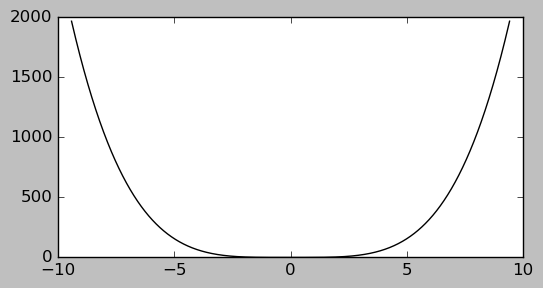

In [5]:
#Define parameters, potential and vector potential
m, omega , sigma, delta, Phi =  1., 1., 1., .2, 0.
eps = 0.3
a = 0

levelSpace = 0.46638204451990617 # eps = 0.5
beta = 0.1/ (levelSpace)

print("beta=", beta)
print("T=", 1/beta)

Ed = 0.01
omegaD = Ed / eps

def confin(x): 
    left = 20*(1+np.tanh(20*(x-3*np.pi)))
    right = 20*(1-np.tanh(20*(x+3*np.pi)))
    return left + right

def V(x):
#     return omega/2 * x**2
    return omega/4 * (x**4 - a*x)
#     return omega*(1-np.cos(x)) + confin(x)

def V_sym(x):
    return omega/4 * (x**4 - x)

#Define range of x
x_max = 3*np.pi
x_min = -3*np.pi
dx = 0.01
x_range_q = np.append(np.flip(-1*np.arange(0+dx,x_max,dx)), np.arange(0,x_max,dx))
n_xq = len(x_range_q); 
print("n_xq=",n_xq )

#Define range of p
p_max = 15
p_min = -15
dp = 0.01
p_range_q = np.arange(p_min,p_max+dp,dp)
n_pq = len(p_range_q); 
print("n_pq=",n_pq )


##Plotting checking of Potential
a_range = [0.01, 0.1, 1, 2, 5, 10]

fig1 = plt.figure(figsize = (6,3), dpi=100)
ax1 = fig1.add_subplot(111)
# for a_1 in a_range: 
#     ax1.plot(x_range_q,omega/4 * (x_range_q**4 - a_1*x_range_q), label=str(a_1))
ax1.plot(x_range_q,V(x_range_q), color='k')
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_potential.png"
# fig1.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

## Compute quasi-Density matrix, $\mathcal{W}$

To begin investigating the QM-Liouville correspondence, we look at the quasi-Density matrix, $\mathcal{W}$. It is defined as
\begin{equation}
    \mathcal{W}(x + \xi/2, x - \xi/2) = \int dp \exp\left[ -i\frac{p\xi}{\epsilon} \right] P(x, p)
\end{equation}
where $P(x, p)$ is the classical probability distribution. We would then switch to variables $(x_1, x_2) = (x + \xi/2, x - \xi/2)$ and write
\begin{equation}
    \mathcal{W}(x_1, x_2) = \sum_n w_n\psi^*_n(x_1)\psi_n(x_2)
\end{equation}
where $\sum_n w_n = 1$. 

Note, the variable change is also $(x, \xi) = (\frac{x_1+x_2}{2}, x1-x2)$

### Set up system and functions

In [6]:
def compStates(beta_list): 
    """
    Compute, plot, and return the weights from diagonalizing 
    the W-function (of the classical Gibbs distributions at inverse-temp beta)
    
    Arguments
        beta : inverse temperature. 
    """
    w_alph_list = []
    psi_alph_list = []
    
    for beta_i, beta in enumerate(beta_list): 
        sigma_x = np.sqrt(beta*eps**2 / m)
        dx = 0.01

        #Define extended range of x1
        x1_max = np.pi
        x1_min = -np.pi
        x1_range_q = np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx))
        x2_range_q = x1_range_q.copy()
        n_x1q = len(x1_range_q); 
        n_x2q = len(x2_range_q);
        
        #Define range of x
        # Find the x-index where true x-range starts
        x_max = np.pi
        x_min = -np.pi
        x_range_q = np.append(np.flip(-1*np.arange(dx,x_max,dx)), np.arange(0,x_max,dx))
        n_xq = len(x_range_q);
        found_x_beg = np.where(x1_range_q ==x_range_q[0])[0][0]
        found_x_end = -1*(found_x_beg)
        
        ## Compute the W-function
        W_mat = np.zeros((n_x1q, n_x2q), dtype=complex)
        Z_x = np.sum(np.exp(-beta*V(x_range_q)))
        for x1_i, x1 in enumerate(x1_range_q): 
            for x2_i, x2 in enumerate(x2_range_q):
                x_x = (x1+x2)/2
                xi_x = x1-x2
                W_mat[x1_i, x2_i] = np.exp(-beta*V(x_x))*np.exp(-m*xi_x**2/(2.*eps**2*beta))/Z_x

        ## Diagonalize the W-function
        w_alph, psi_alph = np.linalg.eigh(W_mat)
        
        ## Sort based on energy values
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        sorted_psi_alph = np.zeros_like(psi_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]
            sorted_psi_alph[:, n_j] = psi_alph[:, n]
        
        w_alph_list += [sorted_w_alph]
        psi_alph_list += [sorted_psi_alph]
        
    return w_alph_list, psi_alph_list

### Computing W for $\beta$ range around the crossings

In [21]:
beta_list_fine = np.linspace(0.1, 4.0, 200)
step = beta_list_fine[2] - beta_list_fine[1]

beta_list_fine_1 = np.arange(0.1, 4.0+step, step)
beta_list_fine_ex = np.arange(4.0+step, 8.0, step)

print(len(beta_list_fine), len(beta_list_test))

np.append(beta_list_fine, beta_list_test)

200 204


array([0.1       , 0.11959799, 0.13919598, 0.15879397, 0.17839196,
       0.19798995, 0.21758794, 0.23718593, 0.25678392, 0.27638191,
       0.2959799 , 0.31557789, 0.33517588, 0.35477387, 0.37437186,
       0.39396985, 0.41356784, 0.43316583, 0.45276382, 0.47236181,
       0.4919598 , 0.51155779, 0.53115578, 0.55075377, 0.57035176,
       0.58994975, 0.60954774, 0.62914573, 0.64874372, 0.66834171,
       0.6879397 , 0.70753769, 0.72713568, 0.74673367, 0.76633166,
       0.78592965, 0.80552764, 0.82512563, 0.84472362, 0.86432161,
       0.8839196 , 0.90351759, 0.92311558, 0.94271357, 0.96231156,
       0.98190955, 1.00150754, 1.02110553, 1.04070352, 1.06030151,
       1.0798995 , 1.09949749, 1.11909548, 1.13869347, 1.15829146,
       1.17788945, 1.19748744, 1.21708543, 1.23668342, 1.25628141,
       1.2758794 , 1.29547739, 1.31507538, 1.33467337, 1.35427136,
       1.37386935, 1.39346734, 1.41306533, 1.43266332, 1.45226131,
       1.4718593 , 1.49145729, 1.51105528, 1.53065327, 1.55025

In [24]:
def comp_Write_Weights(beta_1): 
    beta_list_wide = np.array([beta_1]) 
    w_alph_wide_list, psi_alph_wide_list = compStates(beta_list_wide)

    ## Write the weights to a text file
#     filename = "diagW/SingleT_asym/JJ_CM_weights_nearMore" +str(round(beta_1, 6))+ ".txt"
    filename = "diagW/SingleT_quart_3eps/JJ_CM_weights_nearMore" +str(round(beta_1, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, w_alph_wide_list[0], delimiter=',')

    ## Write the states to a text file
#     filename = "diagW/SingleT_asym/JJ_CM_states_nearMore" +str(round(beta_1, 6))+ ".txt"
    filename = "diagW/SingleT_quart_3eps/JJ_CM_states_nearMore" +str(round(beta_1, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    psi_List = psi_alph_wide_list[0]
    np.savetxt(filename, psi_List[:,:100], delimiter=',', header=listToStr, comments='#')

beta_list_OG = np.linspace(0.1, 4.0, 200)
step = beta_list_OG[2] - beta_list_OG[1]
beta_list_fine = np.arange(0.1, 8.0+step, step)/ levelSpace
# beta_list_fine = np.linspace(1.85, 2.05, 100) / levelSpace

for beta_i, beta in enumerate(beta_list_fine): 
    print(beta_i, end=" ")
    comp_Write_Weights(beta)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

### Read-in data from files

In [23]:
## Read from file
def readInNew(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
#         w_alph = np.loadtxt("diagW/SingleT_asym/"+filename,dtype = "complex", delimiter=',', comments='#')
        w_alph = np.loadtxt("diagW/SingleT_JJ_3T/"+filename,dtype = "complex", delimiter=',', comments='#')
#         w_alph = np.loadtxt("diagW/SingleT_quartic/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]/np.sum(sorted_w_alph[:600])]
    return weights_list

beta_list_OG = np.linspace(0.1, 4.0, 200)
step = beta_list_OG[2] - beta_list_OG[1]
beta_list_fine = np.arange(0.1, 8.0+step, step)/ levelSpace

w_alph_list_fine = readInNew("JJ_CM_weights_nearMore", beta_list_fine)

print("Found this many weights:", np.shape(w_alph_list_fine))
print(np.sum(w_alph_list_fine))

Found this many weights: (200, 600)
(200+0j)


#### Weights at given T

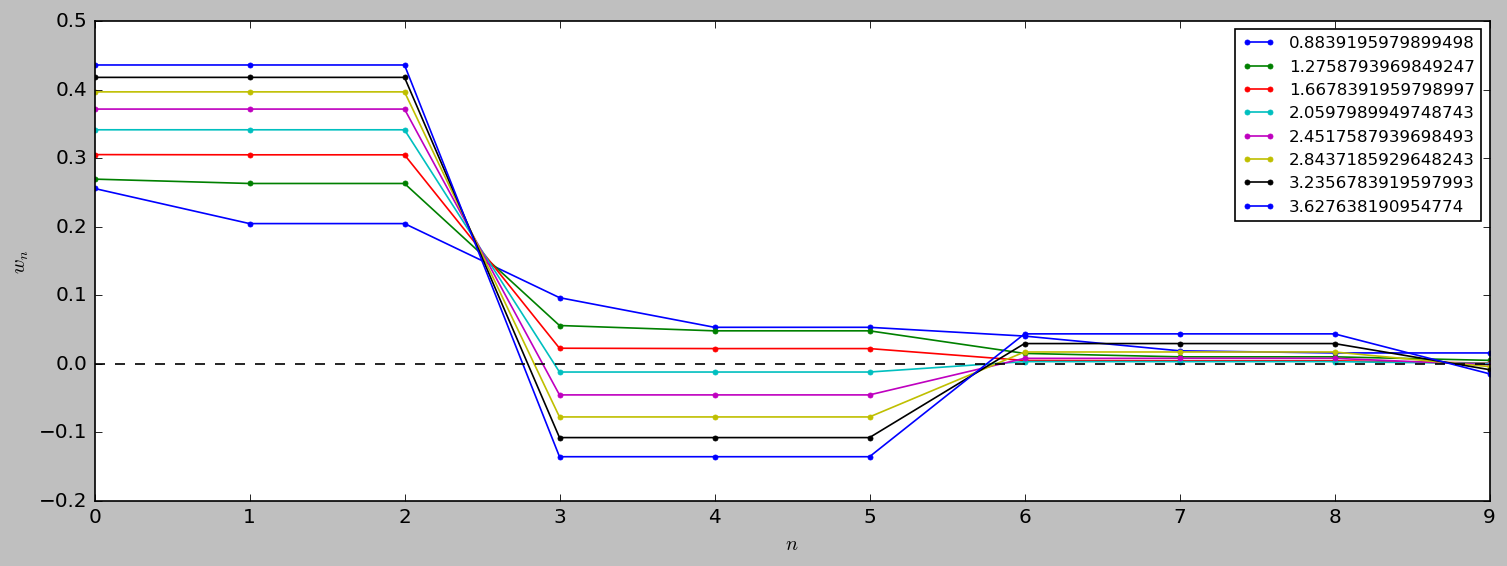

In [99]:
f, ax1 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

for beta_i, beta in enumerate(beta_list_fine):
    if 20 < beta_i < len(beta_list_fine) and beta_i%20==0:
        ax1.plot(weights_toPlot[beta_i, :10], '.-', label=str(beta*levelSpace))
ax1.plot(np.arange(0,10), 0*np.arange(0,10), 'k--')
ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$w_n$")
ax1.legend(fontsize=10)
filename = "Plots_W/CM_eps"+str(eps)+"_JJ3T_weights.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 

#### Weights and Energy spectrum

Plots_W/JJ_CM_eps0.5_energies_v_beta_quartAsym.png


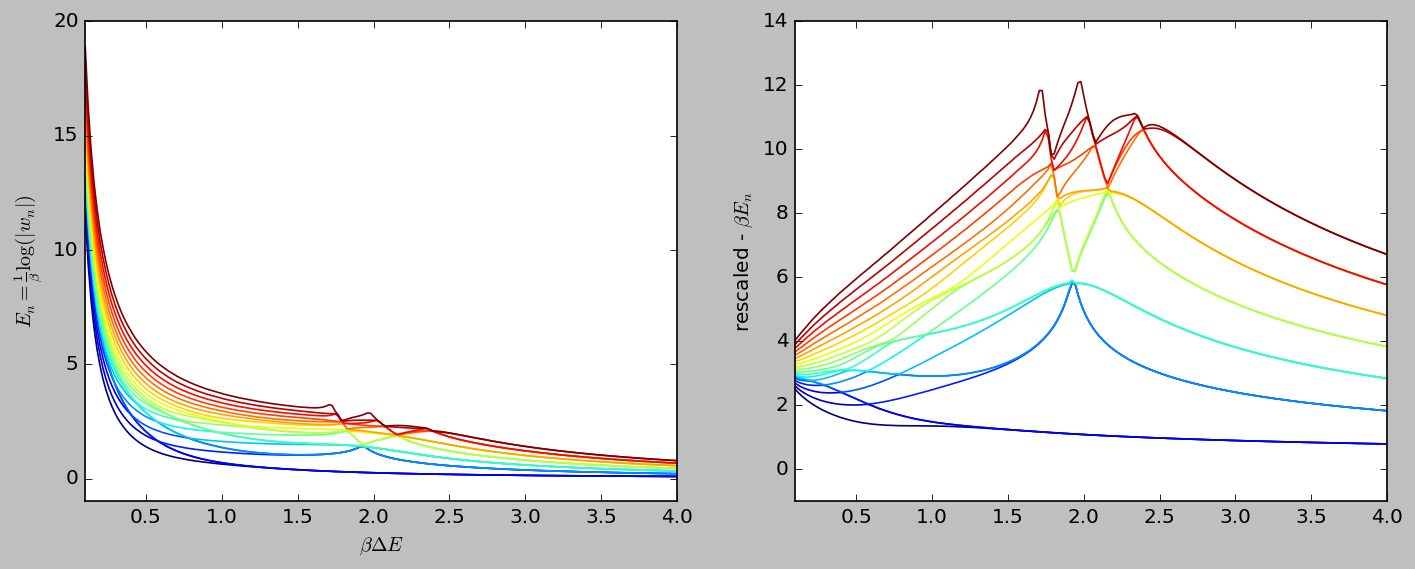

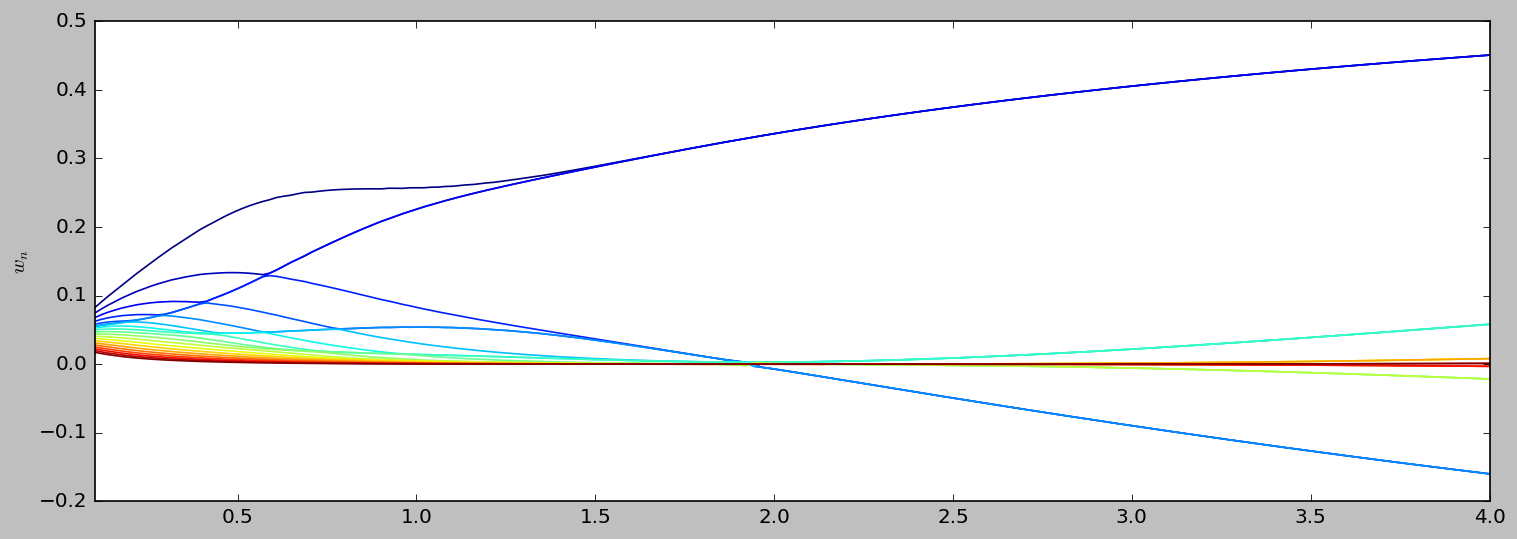

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), dpi=120, frameon=True)
f3, ax3 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

states_n = 20

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', color=colors[k], label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '-', color=colors[k], label="n="+str(k))
    ax3.plot(beta_list_fine*levelSpace, weights_toPlot[:,k], '-', color=colors[k], label="n="+str(k))

ax1.set_ylabel(r"$E_n = \frac{1}{\beta}\log(|w_n|)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax3.set_ylabel(r"$w_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax2.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax3.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax1.set_ylim(bottom=-1)
ax2.set_ylim(bottom=-1)

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energies_v_beta_quartAsym.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

Plots_W/JJ_CM_eps0.5_ERe_beta_asym_0.png


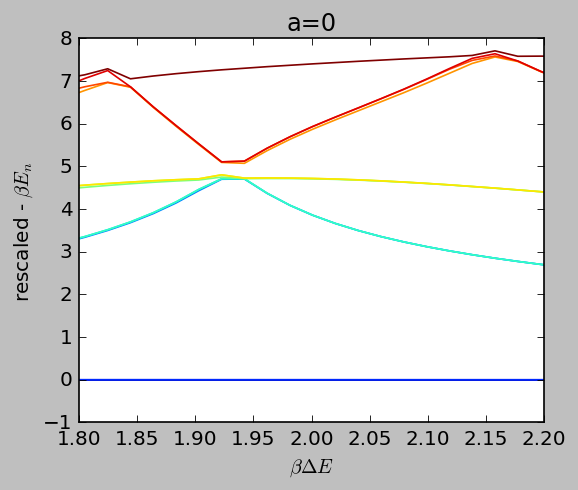

In [98]:
f, (ax2) = plt.subplots(1, 1, figsize = (5,4), dpi=120, frameon=True)

states_n = 13

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k] - EigEnergies_re[:,0], '-', color=colors[k], label="n="+str(k))

ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_xlim([1.8, 2.2])
ax2.set_ylim([-1, 8])
ax2.set_title("a=0")

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_ERe_beta_asym_0.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

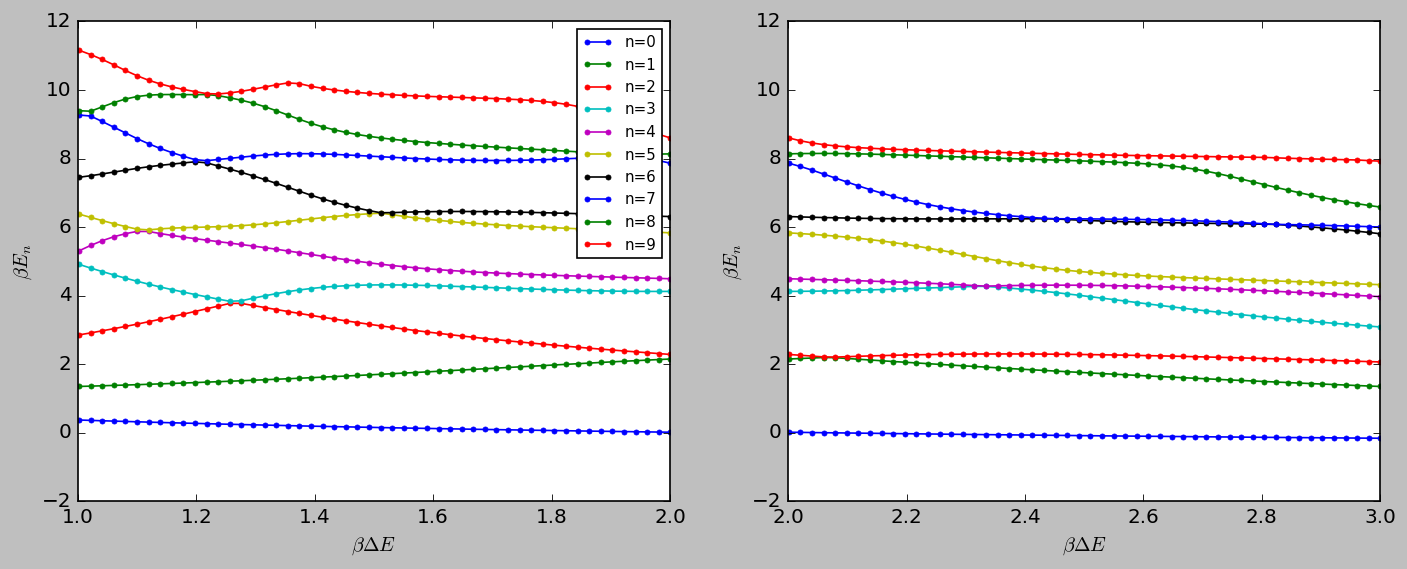

In [178]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), dpi=120, frameon=True)

states_n = 13

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '.-', label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '.-', label="n="+str(k))

ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_xlabel(r"$\beta \Delta E$")
ax1.set_ylabel(r"$\beta E_n$")
ax2.set_ylabel(r"$\beta E_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim([1,2])
ax2.set_xlim([2, 3])
# ax1.set_ylim(0,6)
# ax2.set_ylim(-0.5,5)
ax1.legend(fontsize=9)

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energies_v_beta_quartAsym_zoom.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 

#### Energies with weights sign marked

Plots_W/CM_eps0.5_JJ3T_enerSpec.png
pos - blue
neg - red


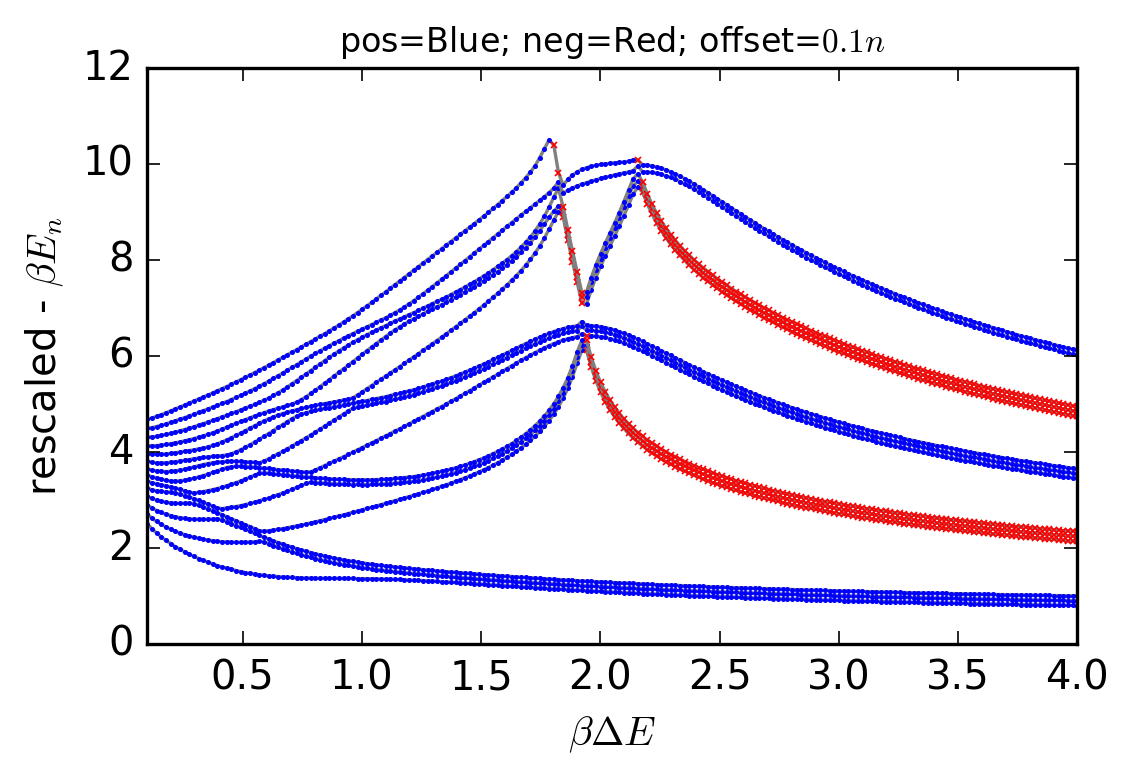

In [102]:
f, (ax2) = plt.subplots(1, 1, figsize = (5,3), dpi=240, frameon=False)
states_n = 14

colors = pl.cm.jet(np.linspace(0,1,states_n))

for k in range(0, states_n):

    EigEnergies_pos = np.array([])
    beta_list_pos = np.array([])
    EigEnergies_neg = np.array([])
    beta_list_neg = np.array([])
    EigEnergies_re = np.zeros((len(beta_list_fine)))

    for j_i, j in enumerate(beta_list_fine): 
        EigEnergies_re[j_i] = -np.log(np.abs(w_alph_list_fine[j_i][k]))

        if w_alph_list_fine[j_i][k] >= 0: 
            EigEnergies_pos = np.append(EigEnergies_pos, EigEnergies_re[j_i])
            beta_list_pos = np.append(beta_list_pos, beta_list_fine[j_i])
        else: 
            EigEnergies_neg = np.append(EigEnergies_neg, EigEnergies_re[j_i])
            beta_list_neg = np.append(beta_list_neg, beta_list_fine[j_i])

    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re +0.1*k, '-', color="grey")
    ax2.plot(beta_list_pos*levelSpace, EigEnergies_pos +0.1*k, ".", markersize=2, linewidth=0,color="b")
    ax2.plot(beta_list_neg*levelSpace, EigEnergies_neg +0.1*k, "x", markersize=2, linewidth=0,color="r")

ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax2.set_xlim([0.1, 4])
# ax2.set_ylim([-1, 12])
ax2.set_title("pos=Blue; neg=Red; offset=$0.1n$", fontsize=10)
filename = "Plots_W/CM_eps"+str(eps)+"_JJ3T_enerSpec.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

print("pos - blue")
print("neg - red")

#### Weights at certain $a$ and $\beta$

Plots_W/JJ_CM_eps0.5_energies_v_beta_quartAsym.png


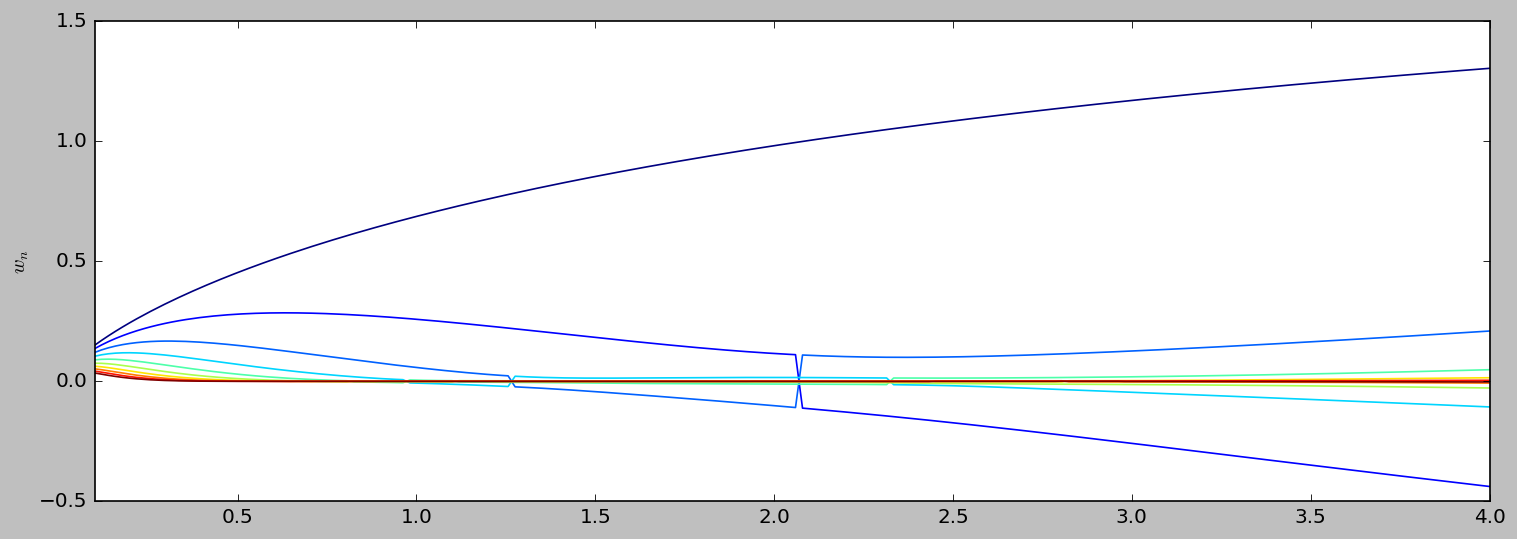

In [290]:
f3, ax3 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

states_n = 10

colors = pl.cm.jet(np.linspace(0,1,states_n))

weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax3.plot(beta_list_fine*levelSpace, weights_toPlot[:,k], '-', color=colors[k], label="n="+str(k))

ax3.set_ylabel(r"$w_n$")
ax3.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energies_v_beta_quartAsym.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

Plots_W/JJ_CM_eps0.5_energies_v_beta_asym_weights.png


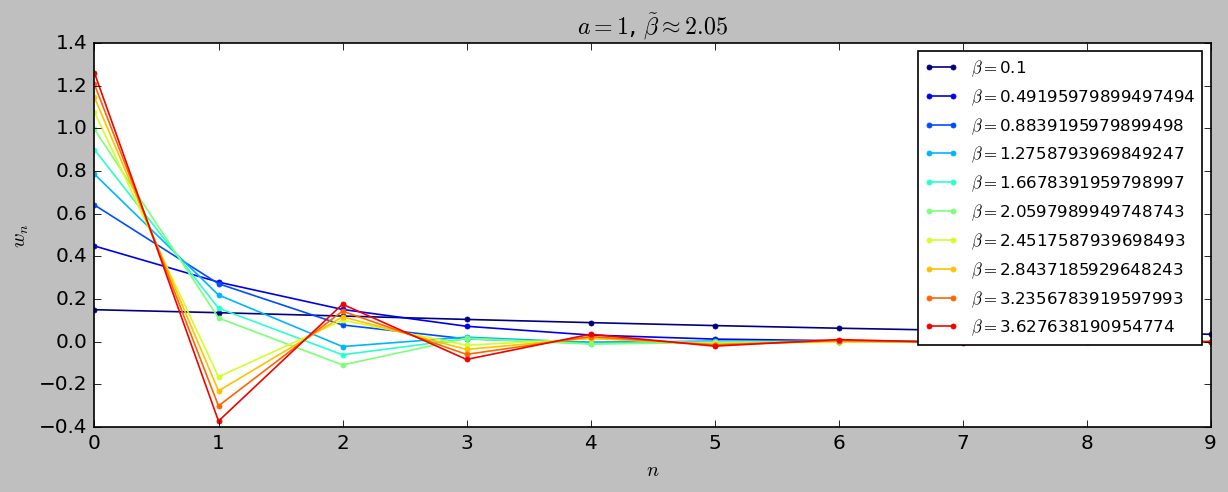

In [364]:
f3, ax3 = plt.subplots(1, 1, figsize = (12,4), dpi=120, frameon=True)

states_n = 10
colors = pl.cm.jet(np.linspace(0,1,len(beta_list_fine)))
for j_i, j in enumerate(beta_list_fine): 
    if j_i%20 ==0: 
        ax3.plot(np.real(w_alph_list_fine[j_i][:states_n]), '.-', color=colors[j_i], label=r"$\beta=$"+str(j*levelSpace))

ax3.set_xlabel(r"$n$")
ax3.set_ylabel(r"$w_n$")
ax3.legend(loc=1, fontsize=10)
ax3.set_title(r"$a=1$, $\tilde{\beta} \approx 2.05$")
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energies_v_beta_asym_weights.png"
f3.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

#### Entropy

Plots_W/JJ_CM_eps0.5_entropy_quart.png
minimums: [43 53 60 65 69 72] [0 1 1 1 1 1]
vN: 95 1.9814070351758797


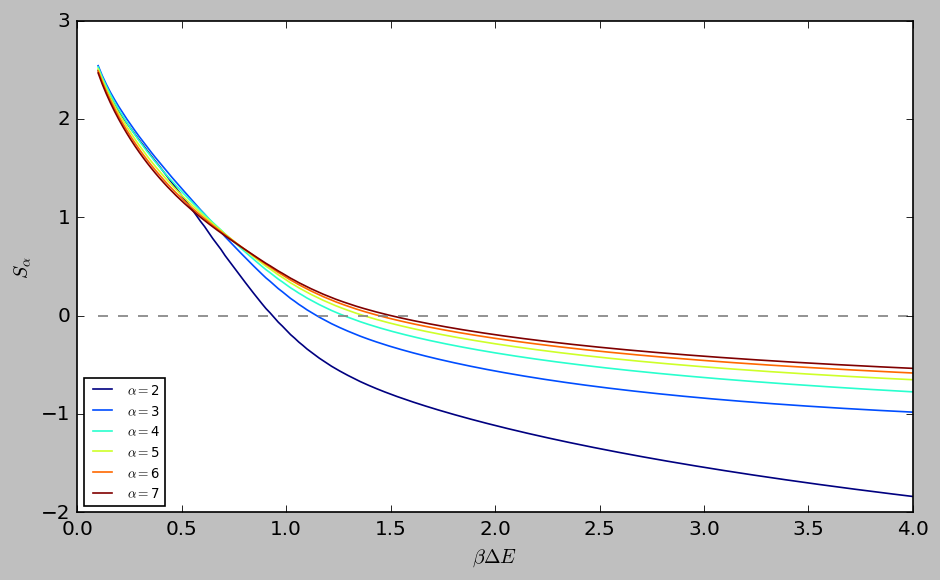

In [87]:
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)

powerRange = np.arange(2, 8, 1)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
# powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
    ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '-', color=colors[power_i],
             label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_list_fine[int(minS_point[power_i])]*levelSpace

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
# ax1.plot(beta_list_fine*levelSpace, np.real(entropyV), '-', color='black', label=r"$\alpha=vN$")

ax1.plot(beta_list_fine*levelSpace, beta_list_fine*levelSpace*0, '--', color='gray')
# ax1.plot(beta_list_fine*0+beta_list_fine[np.int(minS_point[1])]*levelSpace, np.linspace(-.1,.2,len(beta_list_fine)), '--', color='gray')

ax1.set_ylabel(r"$S_\alpha$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.legend(fontsize=8, loc=3)
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_quart.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)
print("minimums:", minS_point, minS_beta)
print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace)


#### Plot some states

In [113]:
def readInWF(filename_base, filename_base_s, beta):     
    
    filename_weights = filename_base + str(round(beta,6)) + ".txt"
    filename_states = filename_base_s + str(round(beta,6)) + ".txt"
    
    ## Read the weights and states from text files
    w_alph = np.loadtxt("diagW/"+filename_weights, dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/"+filename_states, dtype = "complex", delimiter=',', comments='#')
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx)), 3)
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    return x1_range_q, w_alph, psi_alph

SingleT_JJ_3T/JJ_CM_weights_nearMore 3.1559090101711456
1519 1519


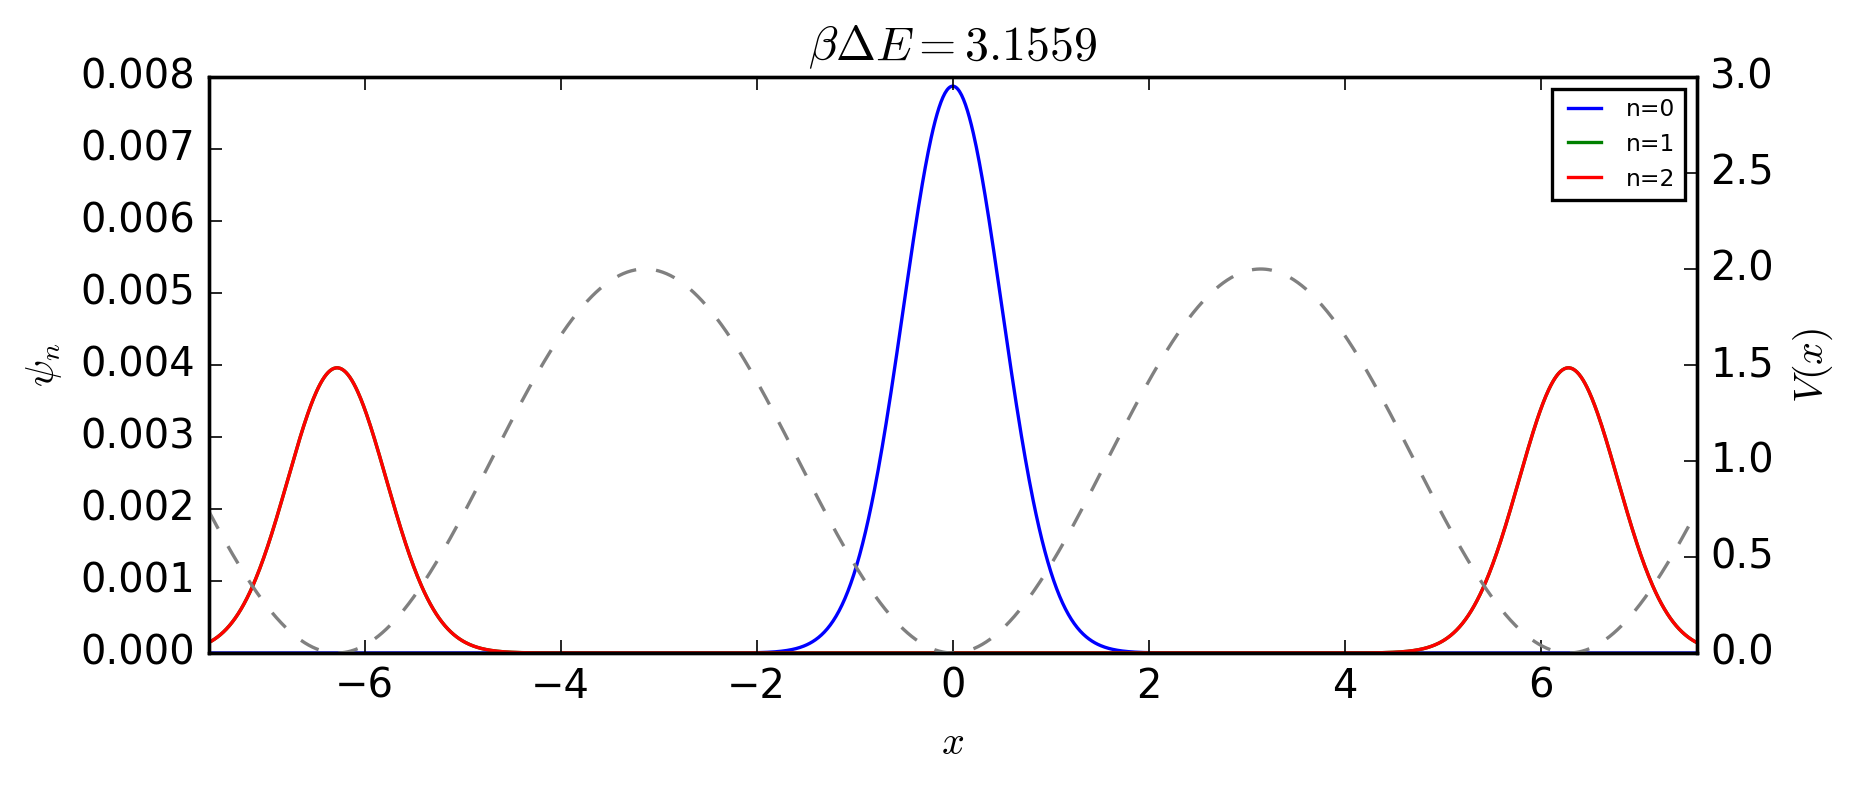

In [114]:
filename_base = "SingleT_JJ_3T/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_JJ_3T/JJ_CM_states_nearMore"

i=70
beta = beta_list_fine[i]
print(filename_base, beta)
x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)

print(len(psi_alph), len(x_range_q))


##Plot eigenstates
f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
ax1.plot(x_range_q, np.abs(psi_alph[:,0])**2, label="n=0")
ax1.plot(x_range_q, np.abs(psi_alph[:,1])**2, label="n=1")
ax1.plot(x_range_q, np.abs(psi_alph[:,2])**2, label="n=2")
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$\psi_n$")
ax1.set_xlabel(r"$x$")
ax1.set_xlim([x_range_q[0], x_range_q[-1]])
ax1.set_title(r"$\beta \Delta E = "+str(round(beta_list_fine[i], 4))+"$")

ax2 = ax1.twinx()
ax2.plot(x_range_q,V(x_range_q), '--',color='grey')
ax2.set_ylabel(r"$V(x)$")
ax2.set_ylim([0,3])

filename = "Plots_W/CM_eps"+str(eps)+"_JJ3T_groundStates.png"
f.savefig(filename, dpi=200, bbox_inches='tight') 

#### 3x3 W Sub-Matrix 

In [97]:
def readInWF(filename_base, beta):     
    filename = filename_base + str(round(beta,6)) + ".txt"
    filename_weights = "JJ_CM_weights_nearMore" + str(round(beta,6)) + ".txt"
    ## Read the histogram array using Numpy commands. 
    w_alph = np.loadtxt("diagW/SingleT_mid/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/SingleT_mid/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx)), 3)
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    return x1_range_q, sorted_w_alph, sorted_psi_alph

def reconstruct_W(beta): 
    ## Read-in weights/states for given inverse-temperature
    x1_range_q, w_alph, psi_alph = readInWF("JJ_CM_states_nearMore", beta)
    
    ## Construct the W-matrix from weights/states
    n_x1q = len(x1_range_q); 
    P = np.zeros((n_x1q,n_x1q))
    D = np.zeros((n_x1q,n_x1q))

    for i in range(n_x1q): 
        D[i,i] += np.real(w_alph[i])
        P[:,i] += np.real(psi_alph[:,i])

    W_mat_recon =  P@D@np.linalg.inv(P)
    return x1_range_q, w_alph, psi_alph, W_mat_recon

##Define the states for the subspace
chosen_state_j = 20; print(beta_list_fine[chosen_state_j]*levelSpace)
state_range = [1, 2, 3, 4, 5]
new_eig_list = np.zeros((len(state_range), len(beta_list_fine)))
old_eig_list = np.zeros((len(state_range), len(beta_list_fine)))
new_psi_list = np.zeros((len(state_range), len(beta_list_fine), len(state_range)))

##Get eigensystem of W at chosen T
x_range_q, w_alph_j, psi_alph_j, W_mat_recon_j = reconstruct_W(beta_list_fine[chosen_state_j])
x_end_j = np.where(x_range_q == 3.14)[0][0]
x_beg_j = np.where(x_range_q == -3.14)[0][0]
print(x_range_q[x_beg_j], x_range_q[x_end_j])

##Compute the W sub-matrix 
for beta_i, beta in enumerate(beta_list_fine): 
    print(beta_i, "/",len(beta_list_fine), end='\r')
    x1_range_q, w_alph, psi_alph, W_mat_recon = reconstruct_W(beta)
    x_end = np.where(x1_range_q == 3.14)[0][0]; x_beg = np.where(x1_range_q == -3.14)[0][0]
    
    W_sub = np.zeros((len(state_range), len(state_range)))
    for j_i, j in enumerate(state_range): 
        for k_i, k in enumerate(state_range): 
            W_sub[j_i, k_i] = np.real(psi_alph_j[x_beg_j:x_end_j,k]@W_mat_recon[x_beg:x_end, x_beg:x_end]@psi_alph_j[x_beg_j:x_end_j,j])
    [w_alph_sub, psi_alph_sub] = np.linalg.eigh(W_sub)
    new_eig_list[:,beta_i] += w_alph_sub
    old_eig_list[:,beta_i] += np.real(w_alph[state_range[0]:state_range[-1]+1])
    new_psi_list[:,beta_i,:] += psi_alph_sub

1.702020202020202
-3.14 3.14


Plots_W/JJ_CM_eps0.5_Wsub_weights_12345.png


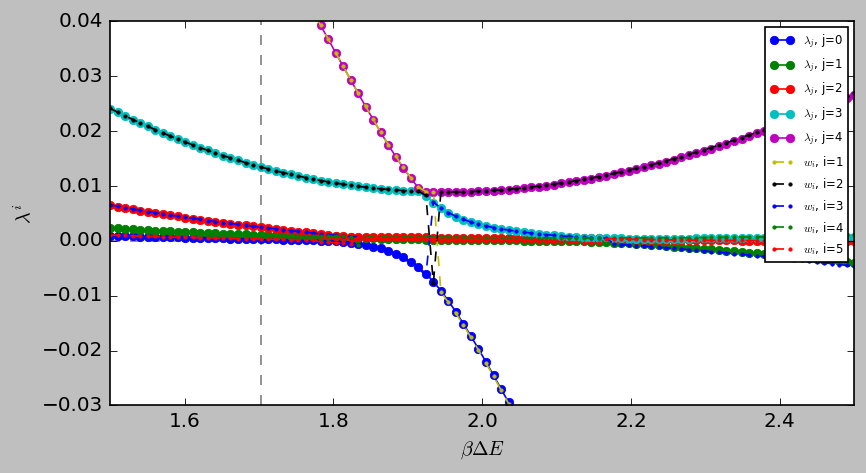

In [110]:
##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=120, frameon=True)
ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.03,0.04,100), '--', color='grey')

for s_i, s in enumerate(state_range): 
    ax1.plot(beta_list_fine*levelSpace, new_eig_list[s_i,:], '.-', markersize=10, label=r"$\lambda_j$, j="+str(s_i))
    
for s_i, s in enumerate(state_range): 
    ax1.plot(beta_list_fine*levelSpace, old_eig_list[s_i,:], '.--', markersize=4, label=r"$w_i$, i="+str(s))
    
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$\lambda^i$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax1.set_ylim([-0.03, 0.04])

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_weights_12345.png"
f.savefig(filename, dpi=200, bbox_inches='tight')
print(filename)

Plots_W/JJ_CM_eps0.5_Wsub12345_vector0.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector1.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector2.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector3.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector4.png


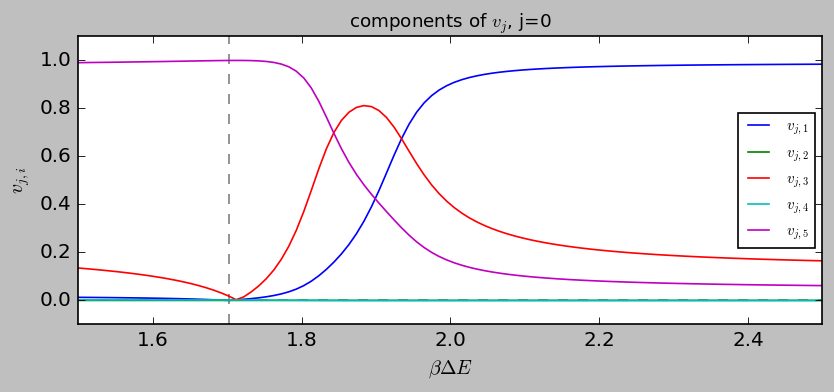

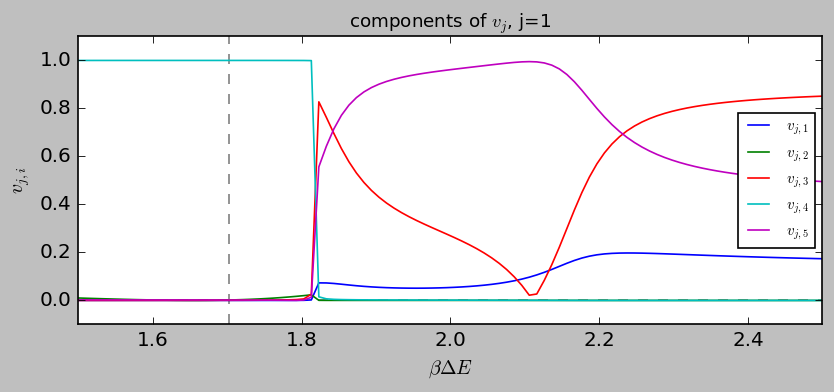

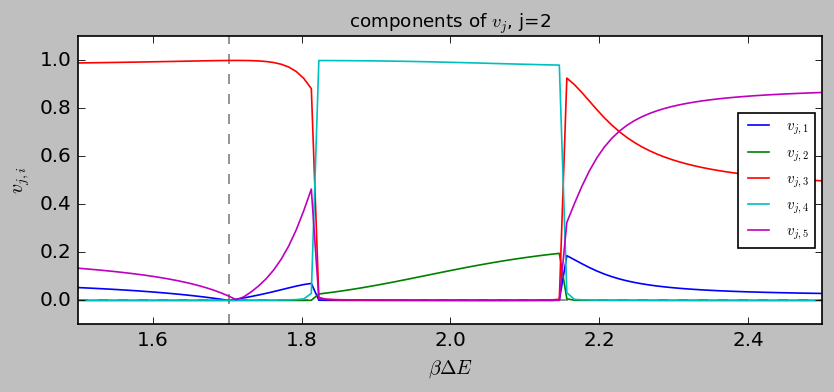

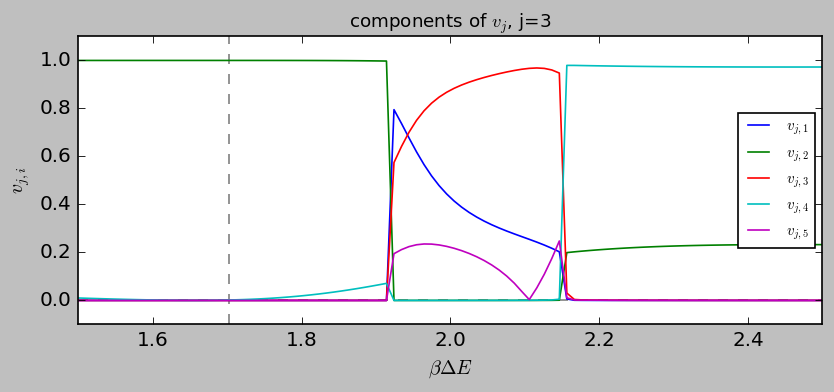

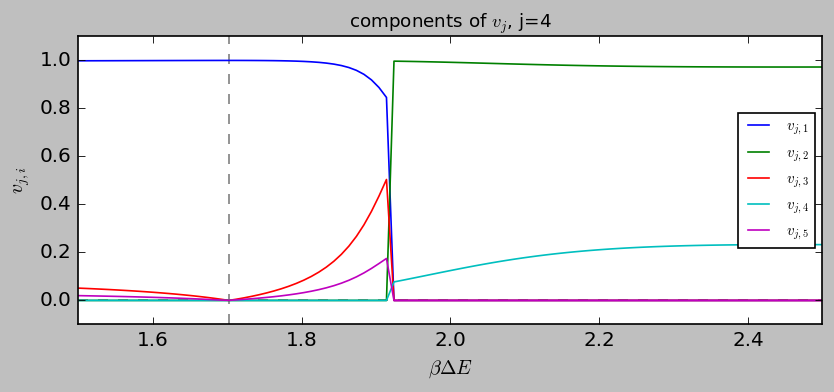

In [103]:
for j in range(len(state_range)): 
    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=120, frameon=True)
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
    ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.1,1.1,100), '--', color='grey')

    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[0,:,j]), '-', label=r"$v_{j,1}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[1,:,j]), '-', label=r"$v_{j,2}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[2,:,j]), '-', label=r"$v_{j,3}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[3,:,j]), '-', label=r"$v_{j,4}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[4,:,j]), '-', label=r"$v_{j,5}$")
    # ax1.plot(beta_list_fine*levelSpace, new_eig_list[3,:], '.-', label=r"$\lambda_3$")
    ax1.legend(fontsize=9, loc=7)

    ax1.set_title("components of $v_j$, j="+str(j), fontsize=11)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_ylabel(r"$v_{j,i}$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
#     ax1.set_yscale('log')

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub12345_vector"+str(j)+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight')                           
    print(filename)

Plots_W/JJ_CM_eps0.5_Wsub_diff0.png
Plots_W/JJ_CM_eps0.5_Wsub_diff1.png
Plots_W/JJ_CM_eps0.5_Wsub_diff2.png


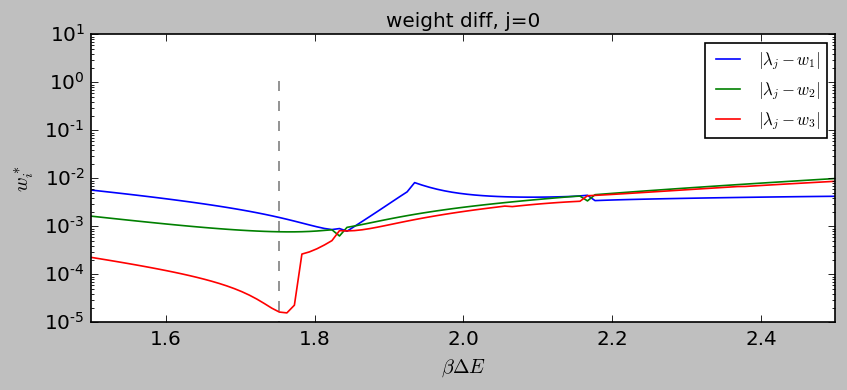

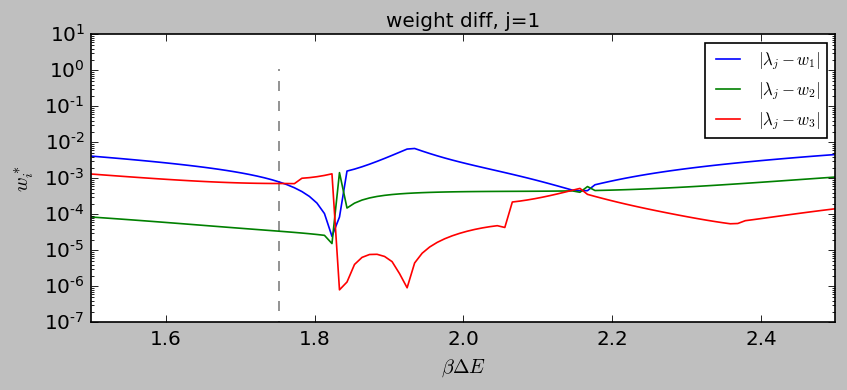

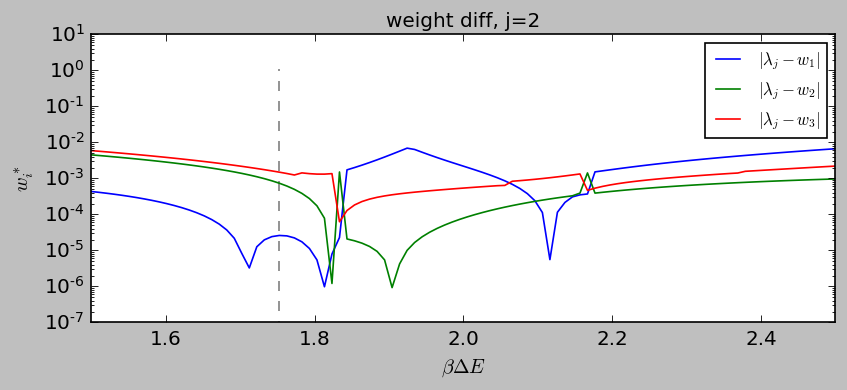

In [72]:
for j in range(len(state_range)): 
    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=120, frameon=True)
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
    ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.1,1.1,100), '--', color='grey')

    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[0,:]), '-', label=r"$|\lambda_j-w_1|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[1,:]), '-', label=r"$|\lambda_j-w_2|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[2,:]), '-', label=r"$|\lambda_j-w_3|$")

    ax1.legend(fontsize=10)
    ax1.set_ylabel(r"$w^*_i$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax1.set_yscale("log")
    ax1.set_title("weight diff, j="+str(j), fontsize=12)
    ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_diff"+str(j)+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight')
    print(filename)

### Asymmetric Investigation

In [205]:
def comp_Write_Weights(beta_1): 
    beta_list_wide = np.array([beta_1]) 
    w_alph_wide_list, psi_alph_wide_list = compStates(beta_list_wide)

    ## Write the weights to a text file
    filename = "diagW/SingleT_asym_2e-1/JJ_CM_weights_nearMore" +str(round(beta_1, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, w_alph_wide_list[0], delimiter=',')

    ## Write the states to a text file
#     filename = "diagW/SingleT_asym/JJ_CM_states_nearMore" +str(round(beta_1, 6))+ ".txt"
#     listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
#     np.savetxt(filename, psi_alph_wide_list[0], delimiter=',', header=listToStr, comments='#')

beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace

for beta_i, beta in enumerate(beta_list_fine): 
    print(beta_i, end=" ")
    comp_Write_Weights(beta)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [403]:
def comp_Write_Weights_a(beta_1, filename_base, filename_base_s): 

    beta_list_wide = np.array([beta_1]) 
    w_alph_wide_list, psi_alph_wide_list = compStates(beta_list_wide)

    ## Write the weights to a text file
    filename = "diagW/" + filename_base +str(round(beta_1, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, w_alph_wide_list[0], delimiter=',')

    ## Write the states to a text file
    filename = "diagW/" + filename_base_s +str(round(beta_1, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    psi_list = psi_alph_wide_list[0]
    np.savetxt(filename, psi_list[:,:10], delimiter=',', header=listToStr, comments='#')

    
beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace

a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]
for a_q in a_Range: 
    a = float(a_q)
    print(a)
    
    def V(x):
        return omega/4 * (x**4 - a*x)
    
    for beta_i, beta in enumerate(beta_list_fine): 
        print(beta_i, end=" ")
        filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
        filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"
        comp_Write_Weights_a(beta, filename_base, filename_base_s)
    print("\n")

0.0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.01
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.05
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38

In [63]:
## Read from file
def readInNew(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
        w_alph = np.loadtxt("diagW/SingleT_asym_1e0/"+filename,dtype = "complex", delimiter=',', comments='#')
#         w_alph = np.loadtxt("diagW/SingleT_quartic/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]]
    return weights_list

beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace
w_alph_list_fine = readInNew("JJ_CM_weights_nearMore", beta_list_fine)

print("Found this many weights:", np.shape(w_alph_list_fine))

Found this many weights: (100, 600)


In [5]:
## Read from file
def readInNew_all_a(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
        w_alph = np.loadtxt("diagW/"+filename,dtype = "complex", delimiter=',', comments='#')
#         w_alph = np.loadtxt("diagW/SingleT_quartic/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]]
    return weights_list

beta_list_fine = np.linspace(2.0, 3.0, 100) / levelSpace

a_Range = ["1e-2", "1e-1", "1e0", "2", "5", "1e1"]
for a_q in a_Range: 
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    print(filename_base)

# w_alph_list_fine = readInNew("SingleT_asym_1e0/JJ_CM_weights_nearMore", beta_list_fine)

# print("Found this many weights:", np.shape(w_alph_list_fine))

SingleT_asym_1e-2/JJ_CM_weights_nearMore
SingleT_asym_1e-1/JJ_CM_weights_nearMore
SingleT_asym_1e0/JJ_CM_weights_nearMore
SingleT_asym_2/JJ_CM_weights_nearMore
SingleT_asym_5/JJ_CM_weights_nearMore
SingleT_asym_1e1/JJ_CM_weights_nearMore


#### Weights and Energy spectrum

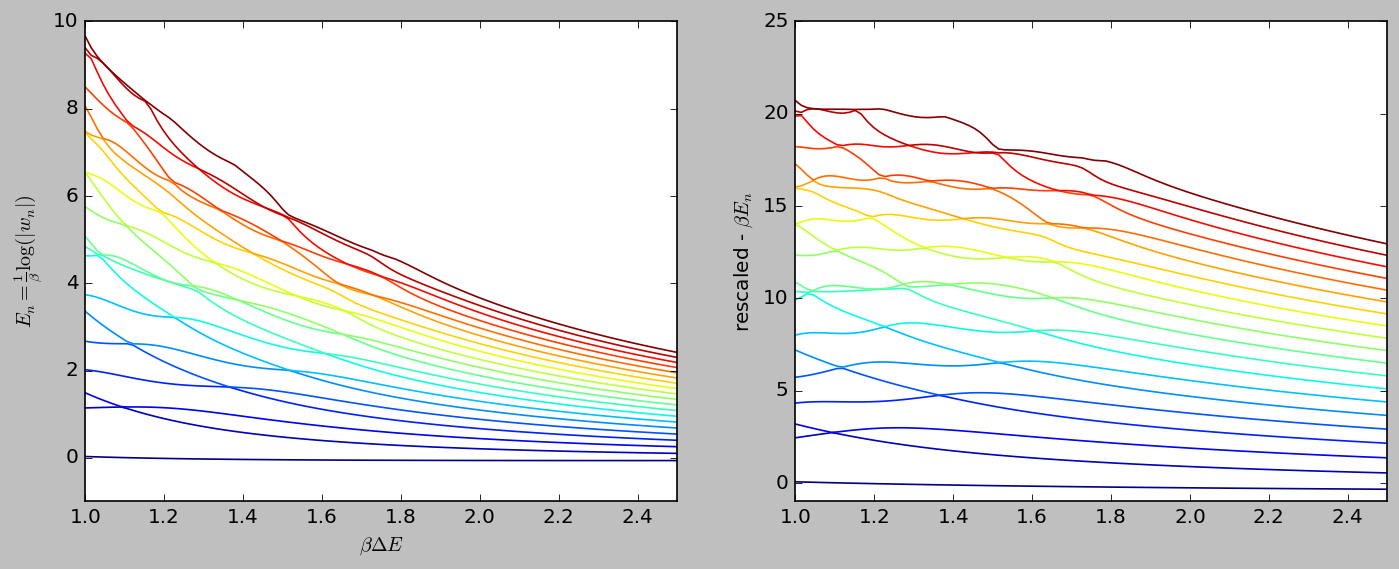

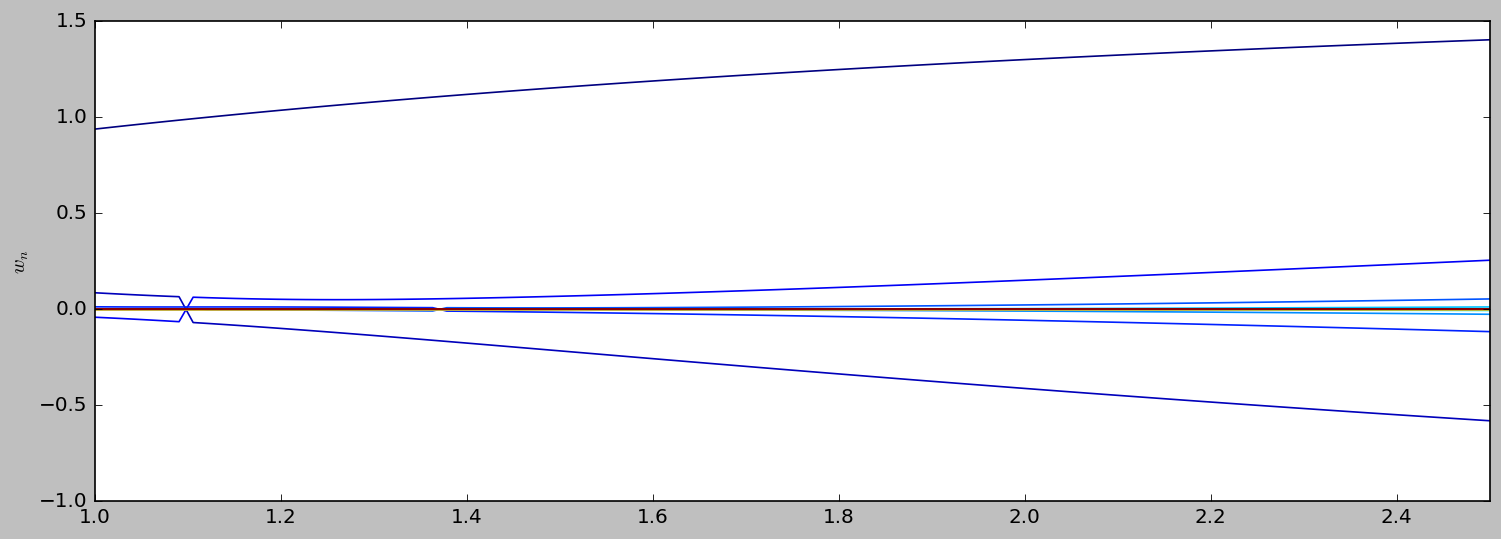

In [264]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), dpi=120, frameon=True)
f3, ax3 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

states_n = 20

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', color=colors[k], label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '-', color=colors[k], label="n="+str(k))
    ax3.plot(beta_list_fine*levelSpace, weights_toPlot[:,k], '-', color=colors[k], label="n="+str(k))

ax1.set_ylabel(r"$E_n = \frac{1}{\beta}\log(|w_n|)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax3.set_ylabel(r"$w_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax2.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax3.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax1.set_ylim(bottom=-1)
ax2.set_ylim(bottom=-1)

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energies_v_beta_quartAsym.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
# print(filename)

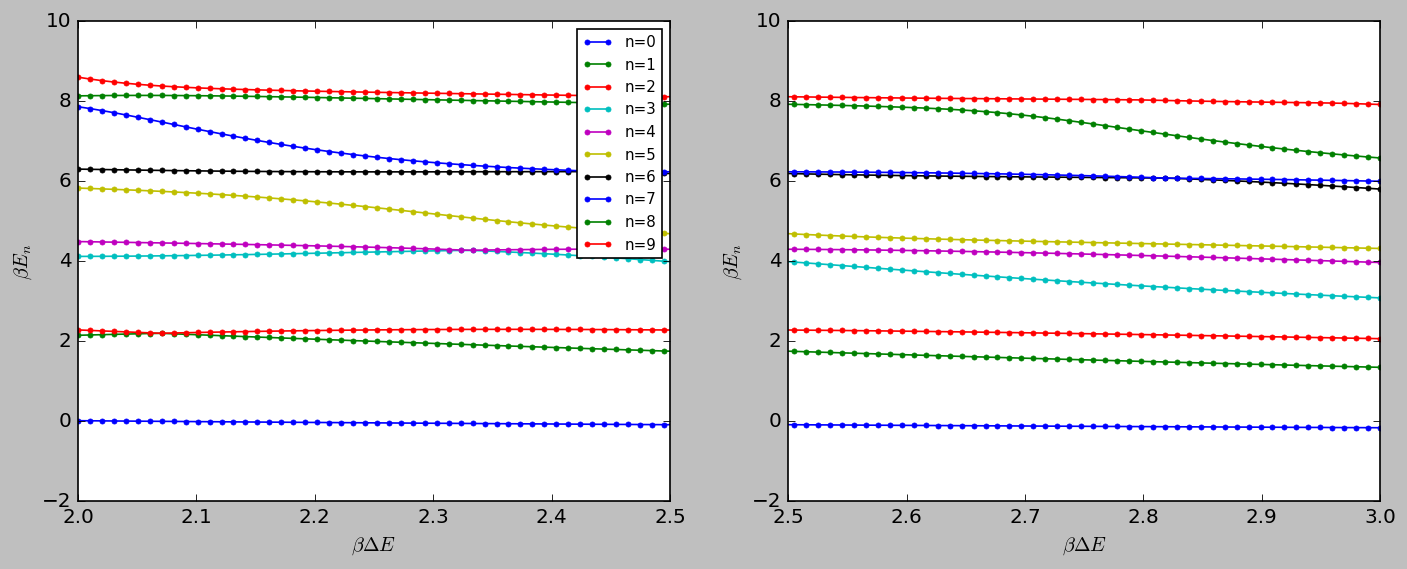

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), dpi=120, frameon=True)

states_n = 10

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '.-', label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '.-', label="n="+str(k))

ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_xlabel(r"$\beta \Delta E$")
ax1.set_ylabel(r"$\beta E_n$")
ax2.set_ylabel(r"$\beta E_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim([2,2.5])
ax2.set_xlim([2.5, 3])
# ax1.set_ylim(0,6)
# ax2.set_ylim(-0.5,5)
ax1.legend(fontsize=9)

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energies_v_beta_quart_zoom.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 

#### Energy for all $a$

SingleT_asym_1e-2/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_1e-2.png
SingleT_asym_1e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_1e-1.png
SingleT_asym_2e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_2e-1.png
SingleT_asym_5e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_5e-1.png
SingleT_asym_1e0/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_1e0.png
SingleT_asym_2/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_2.png
SingleT_asym_5/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_E_beta_asym_5.png


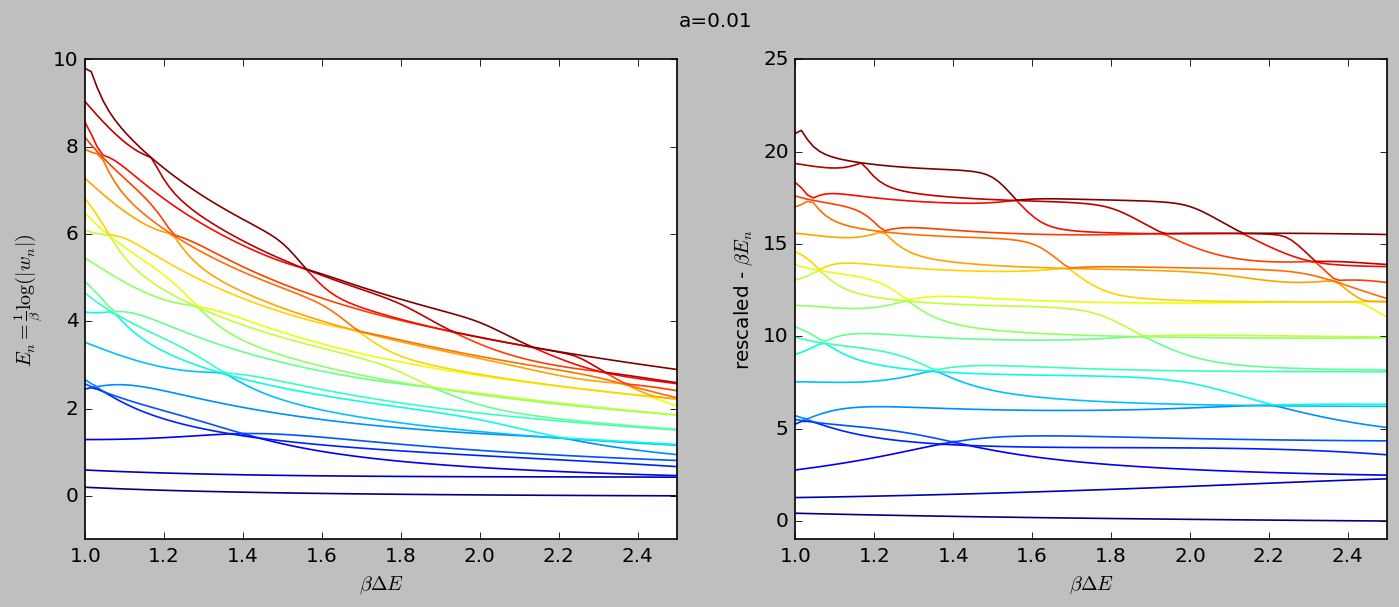

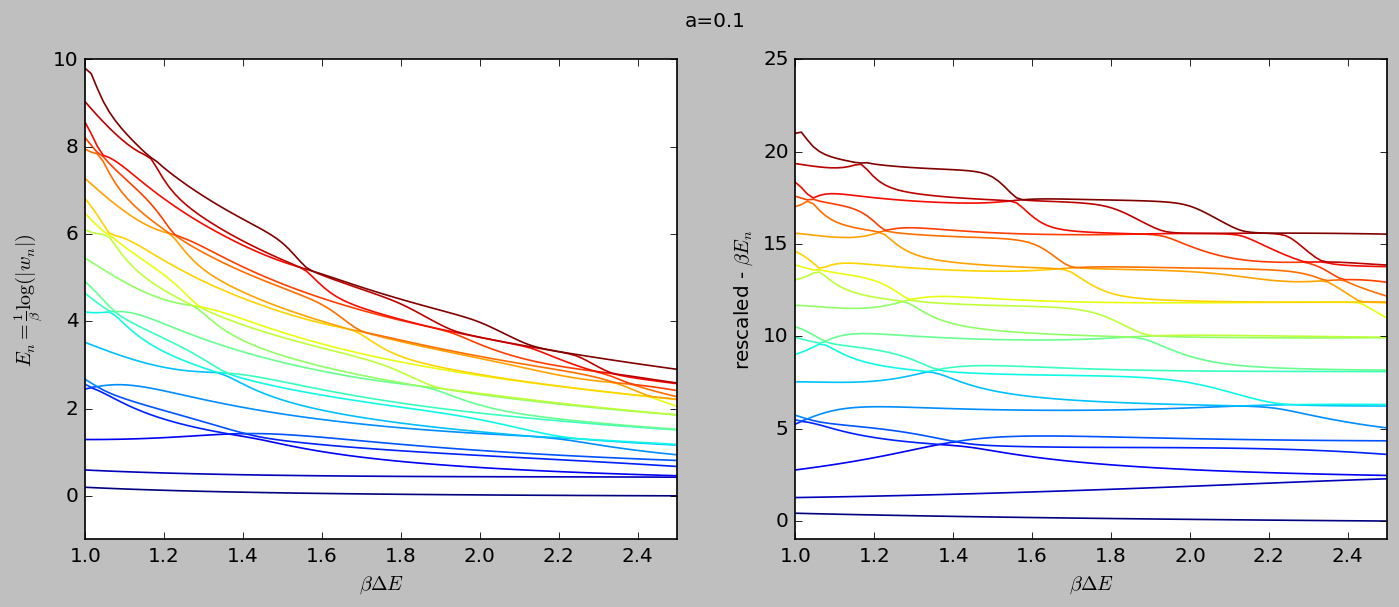

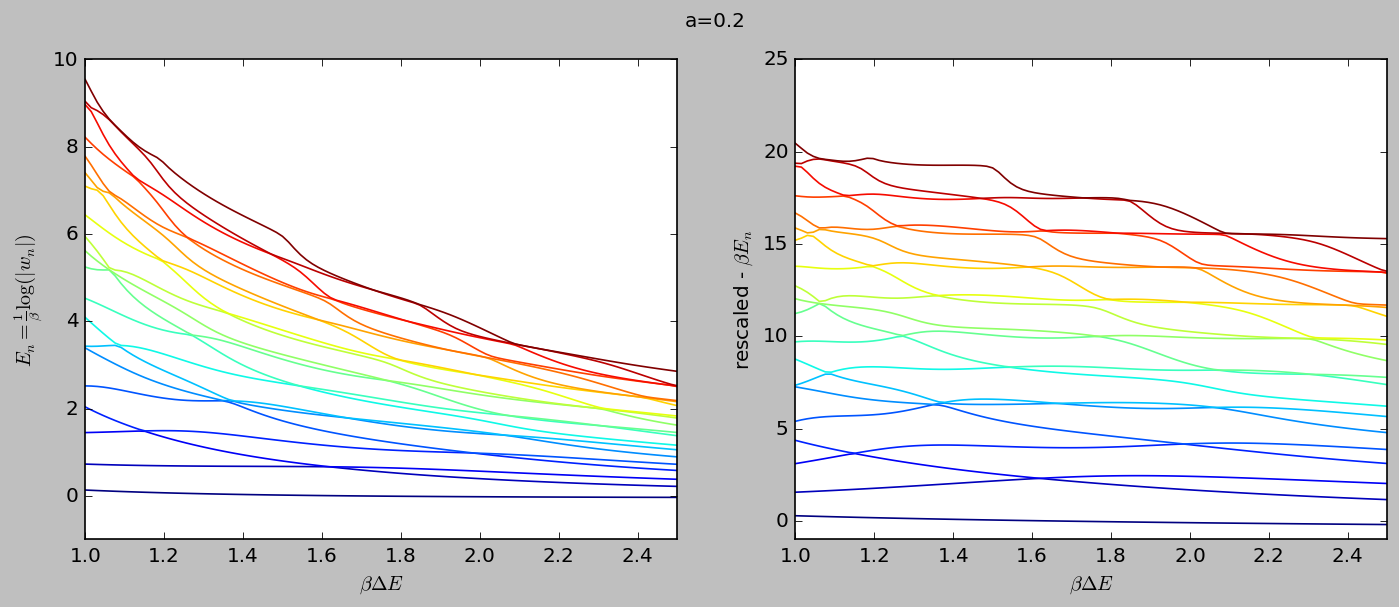

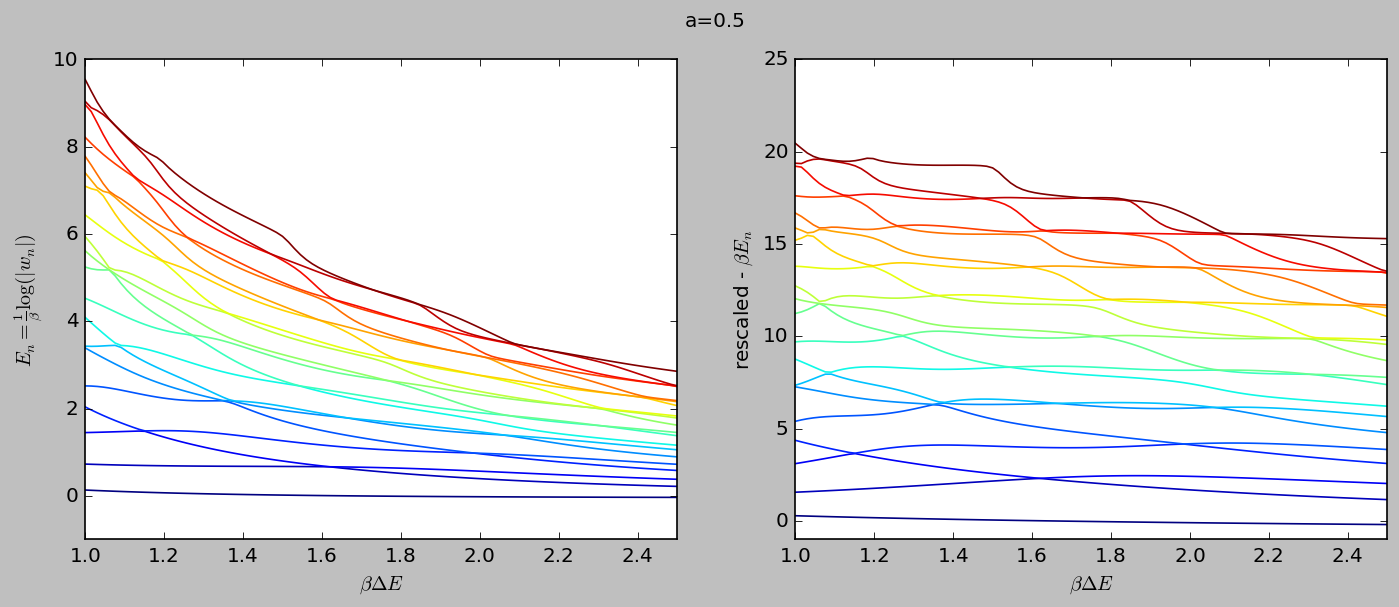

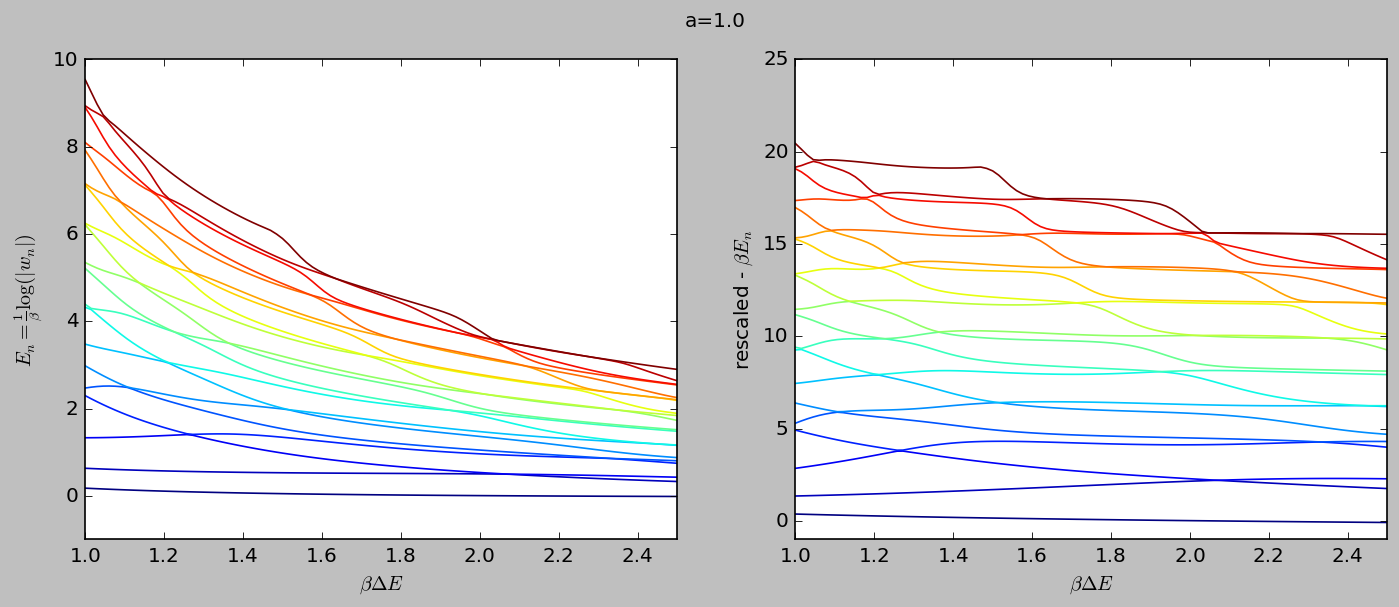

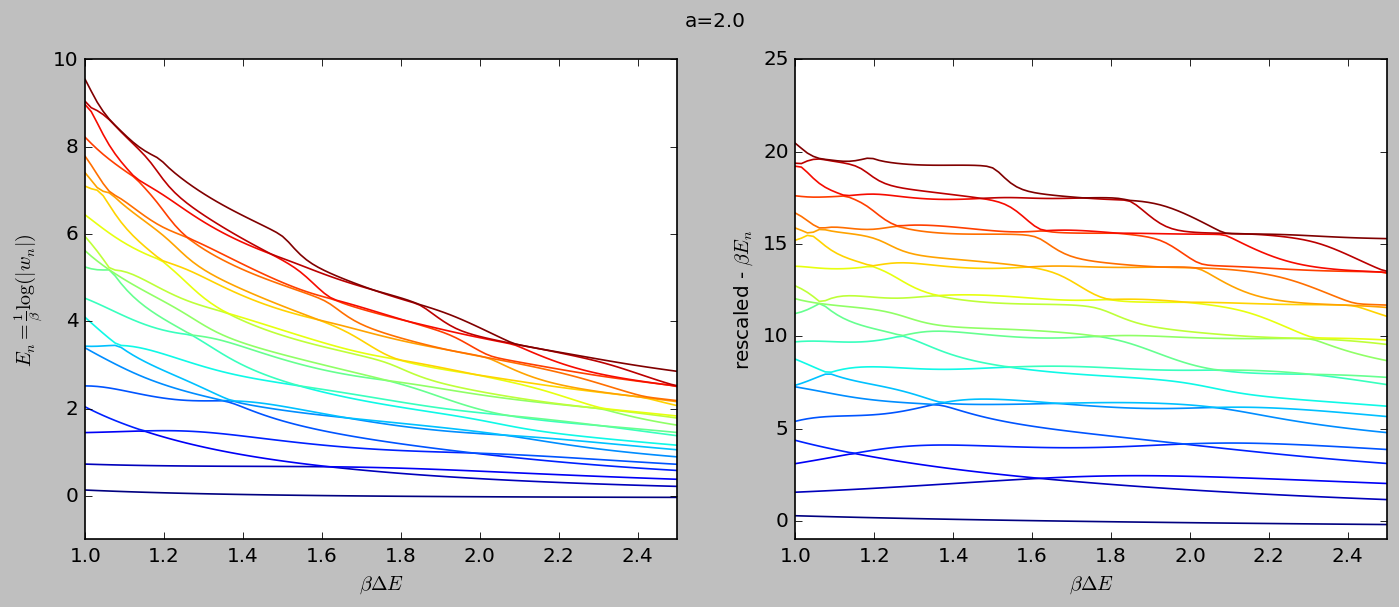

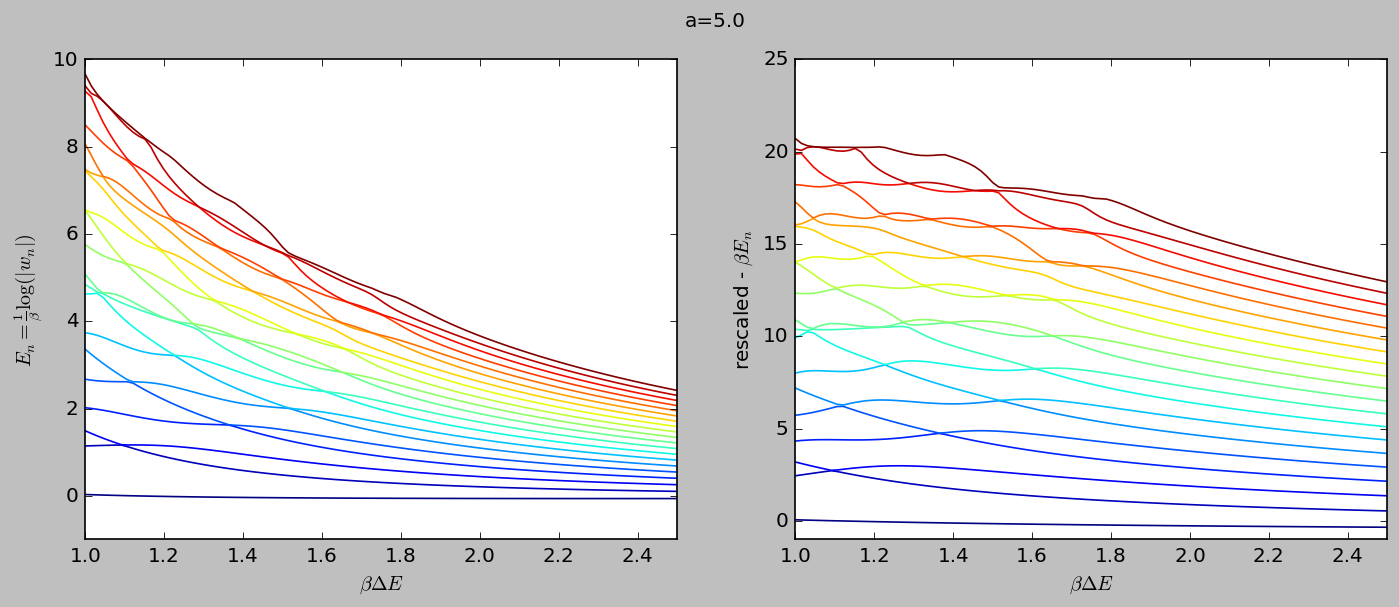

In [207]:
beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace
a_Range = ["1e-2", "1e-1", "2e-1", "5e-1", "1e0", "2", "5"]
for a_q in a_Range: 
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    print(filename_base, end=' ')

    w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), dpi=120, frameon=True)
    states_n = 20

    colors = pl.cm.jet(np.linspace(0,1,states_n))

    EigEnergies = np.zeros((len(beta_list_fine), states_n))
    EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
    weights_toPlot = np.zeros((len(beta_list_fine), states_n))

    for j_i, j in enumerate(beta_list_fine): 
        for k in range(0,states_n): 
            EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
            EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
            weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])

    for k in range(0, states_n):
        ax1.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', color=colors[k], label="n="+str(k))
        ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '-', color=colors[k], label="n="+str(k))

    ax1.set_ylabel(r"$E_n = \frac{1}{\beta}\log(|w_n|)$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax2.set_xlabel(r"$\beta \Delta E$")
    ax2.set_ylabel(r"rescaled - $\beta E_n$")
    ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
    ax2.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
    ax1.set_ylim(bottom=-1)
    ax2.set_ylim(bottom=-1)
    f.suptitle("a="+str(float(a_q)))
    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_E_beta_asym_"+ a_q +".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)

SingleT_asym_0/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_0.png
SingleT_asym_1e-2/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_1e-2.png
SingleT_asym_5e-2/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_5e-2.png
SingleT_asym_1e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_1e-1.png
SingleT_asym_2e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_2e-1.png
SingleT_asym_3e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_3e-1.png
SingleT_asym_4e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_4e-1.png
SingleT_asym_5e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_5e-1.png
SingleT_asym_6e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_6e-1.png
SingleT_asym_7e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_7e-1.png
SingleT_asym_8e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_asym_8e-1.png
SingleT_asym_9e-1/JJ_CM_weights_nearMore Plots_W/JJ_CM_eps0.5_ERe_beta_

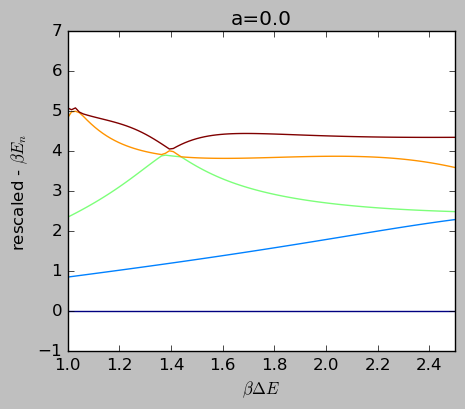

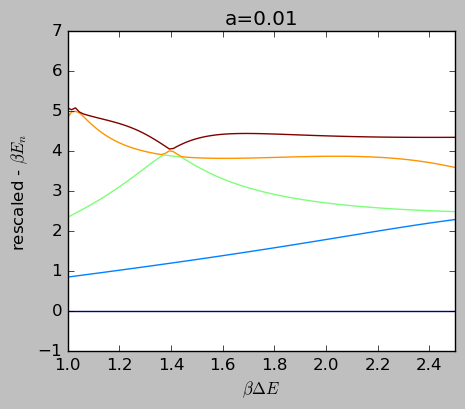

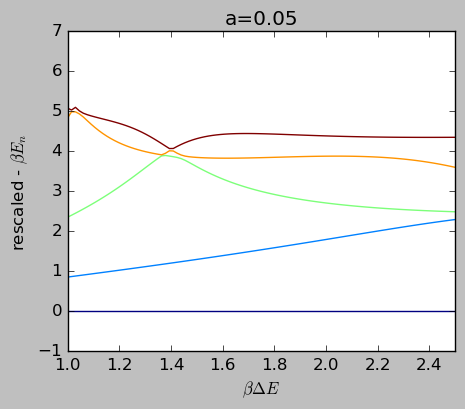

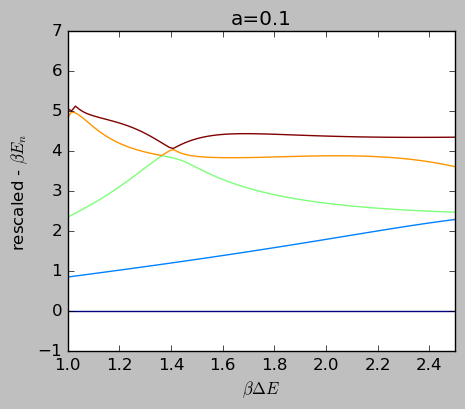

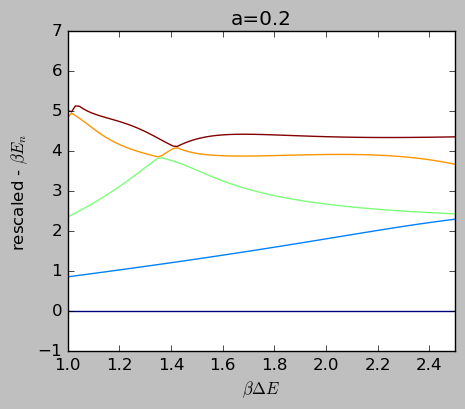

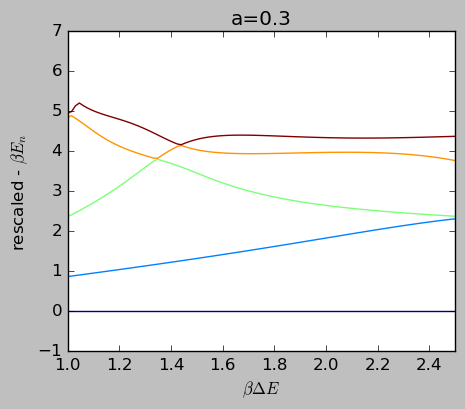

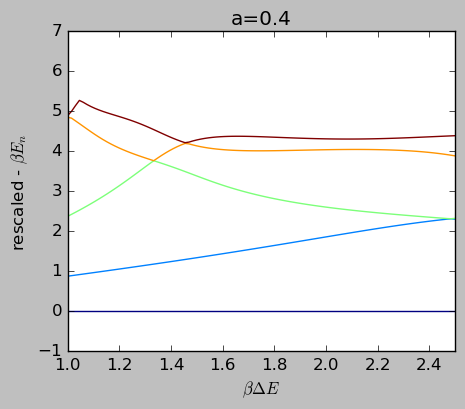

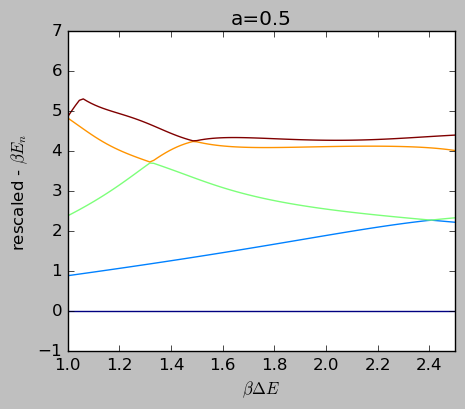

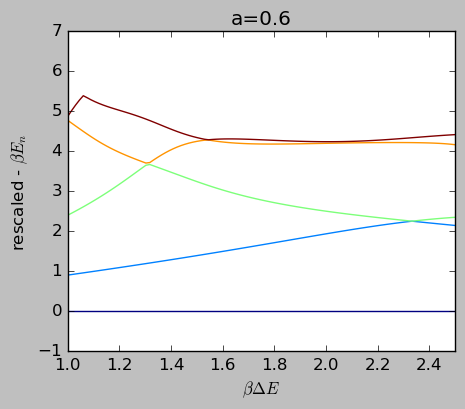

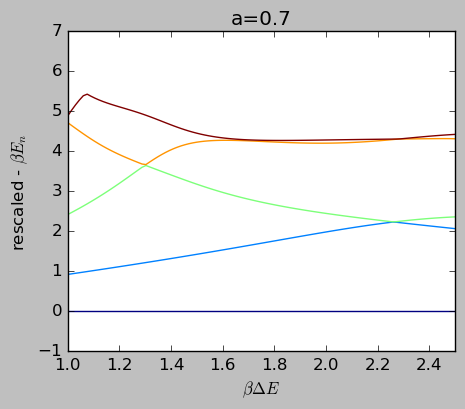

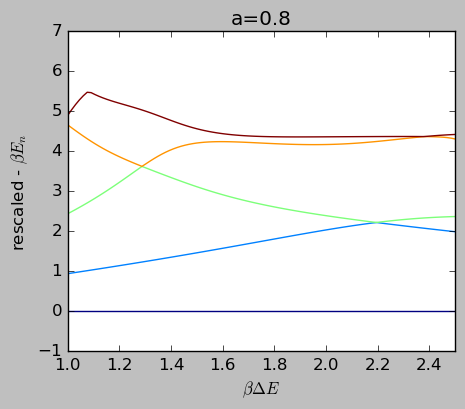

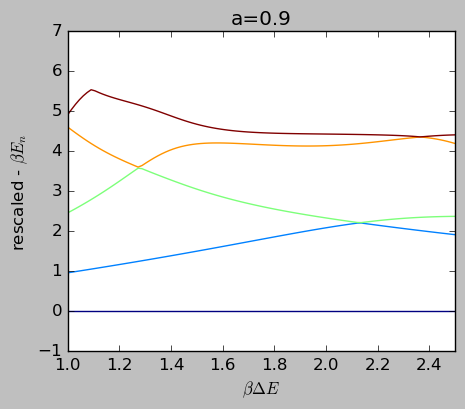

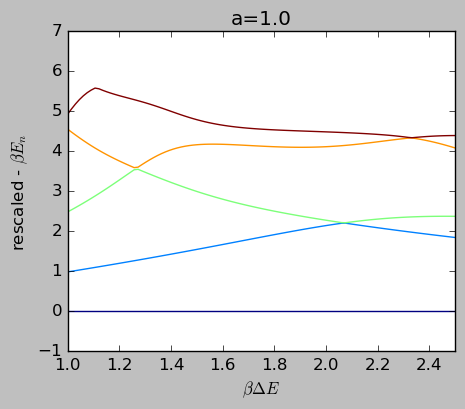

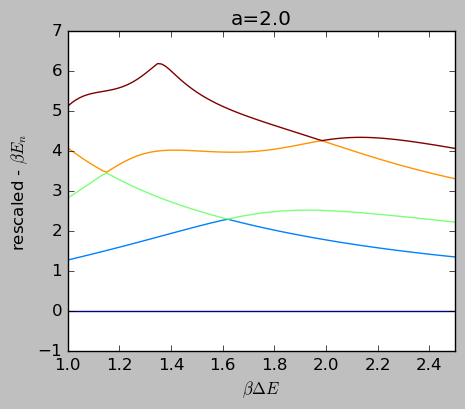

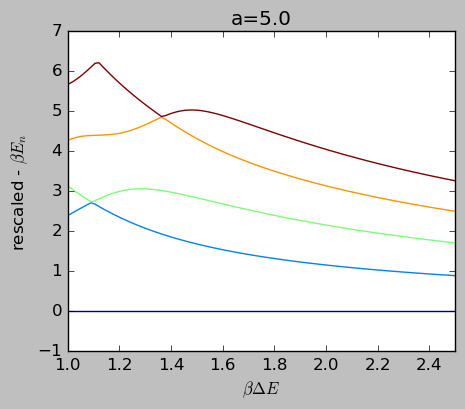

In [250]:
beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace
a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]
for a_q in a_Range: 
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    print(filename_base, end=' ')

    w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

    f, (ax2) = plt.subplots(1, 1, figsize = (5,4), dpi=100, frameon=True)
    states_n = 5

    colors = pl.cm.jet(np.linspace(0,1,states_n))

    EigEnergies = np.zeros((len(beta_list_fine), states_n))
    EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
    weights_toPlot = np.zeros((len(beta_list_fine), states_n))

    for j_i, j in enumerate(beta_list_fine): 
        for k in range(0,states_n): 
            EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
            EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
            weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])

    for k in range(0, states_n):
        ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k] - EigEnergies_re[:,0], '-', color=colors[k], label="n="+str(k))

    ax2.set_xlabel(r"$\beta \Delta E$")
    ax2.set_ylabel(r"rescaled - $\beta E_n$")
    ax2.set_xlim([1, 2.5])
    ax2.set_ylim([-1, 7])
    ax2.set_title("a="+str(float(a_q)))
    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_ERe_beta_asym_"+ a_q +".png"
    f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)

#### Energies for all $a$ with pos/neg weights marked

SingleT_asym_0/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_0.png
SingleT_asym_1e-2/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_1e-2.png
SingleT_asym_5e-2/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_5e-2.png
SingleT_asym_1e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_1e-1.png
SingleT_asym_2e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_2e-1.png
SingleT_asym_3e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_3e-1.png
SingleT_asym_4e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_4e-1.png
SingleT_asym_5e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_5e-1.png
SingleT_asym_6e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_6e-1.png
SingleT_asym_7e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_7e-1.png
SingleT_asym_8e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_8e-1.png
SingleT_asym_9e-1/JJ_CM_weights_nearMore Plots_W/CM_eps0.5_energy_asym_9e-1.png
SingleT_asym_1e0/JJ_CM_weights_nearMore Plots_

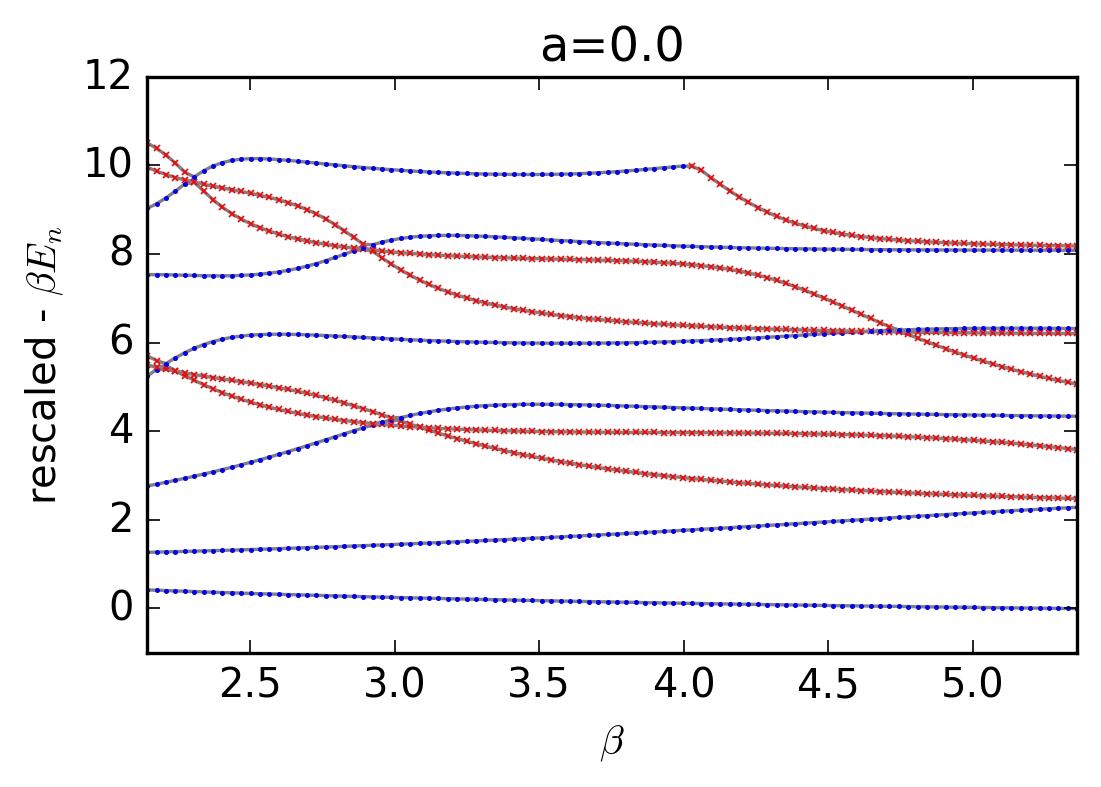

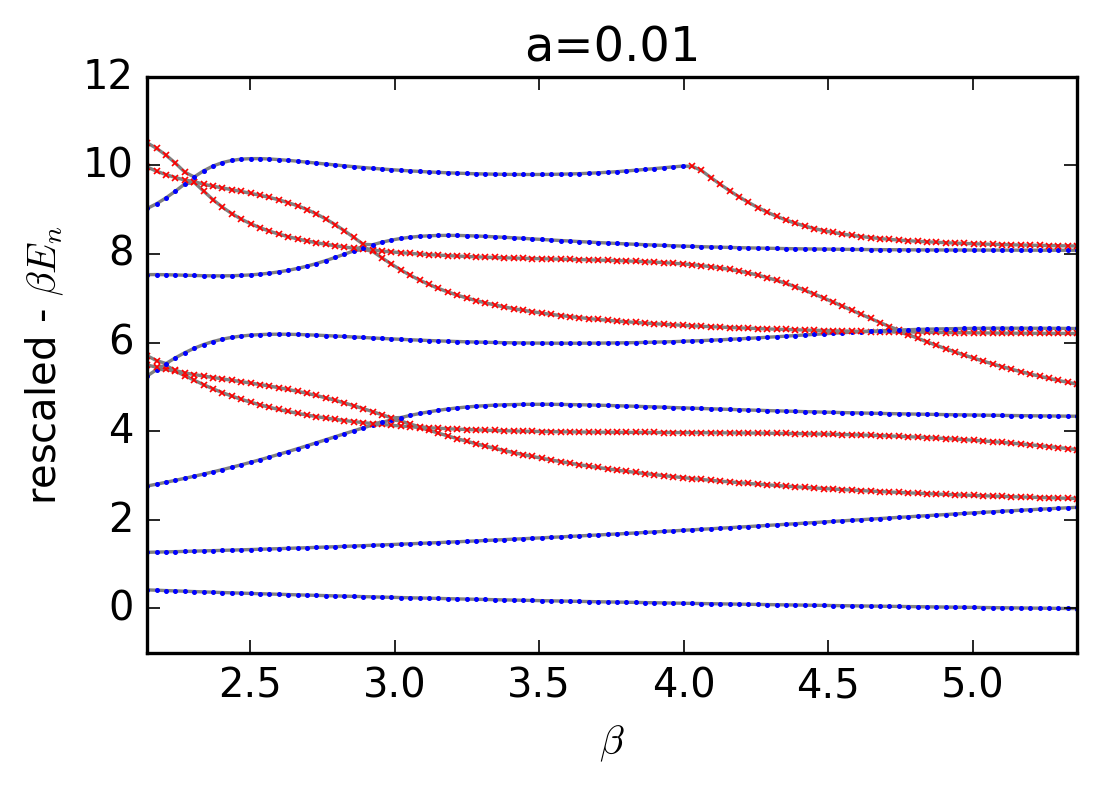

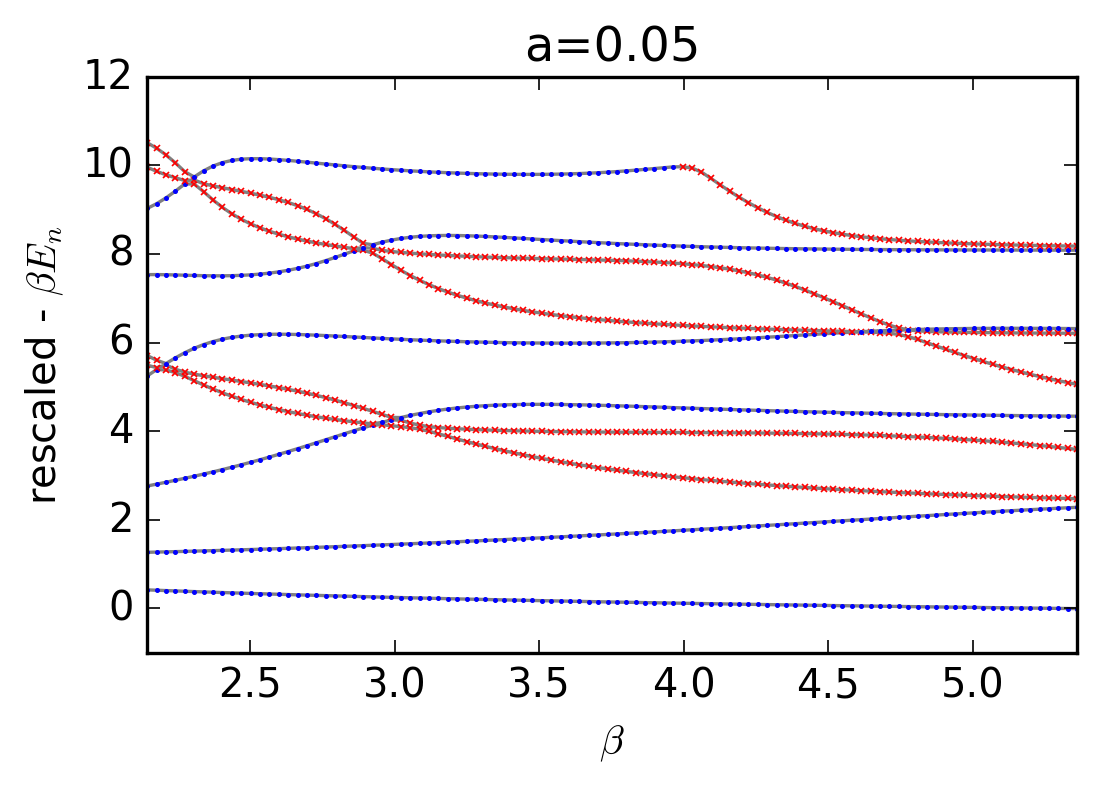

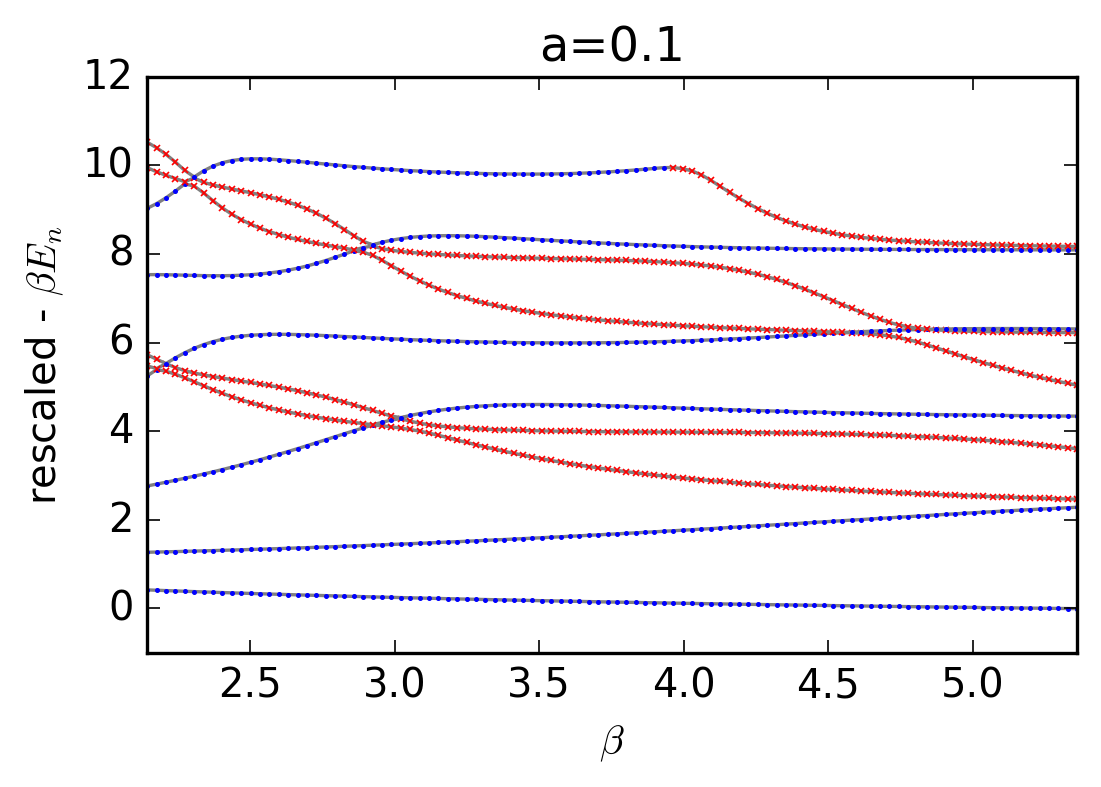

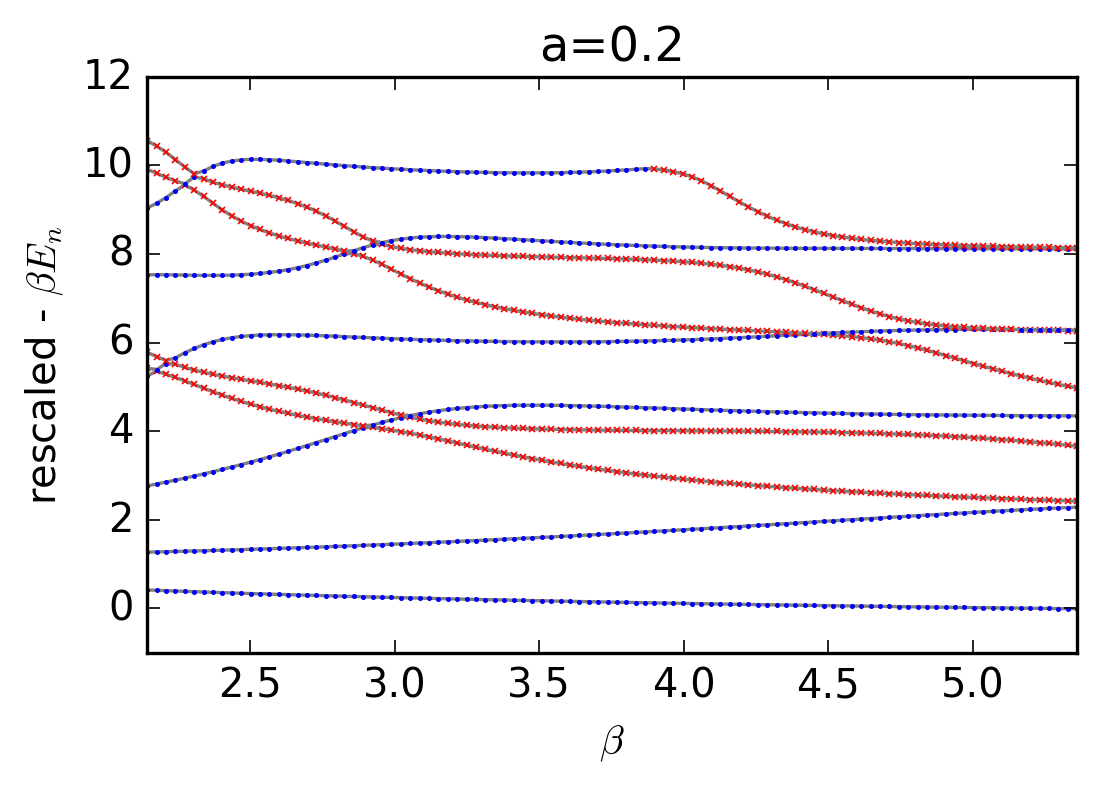

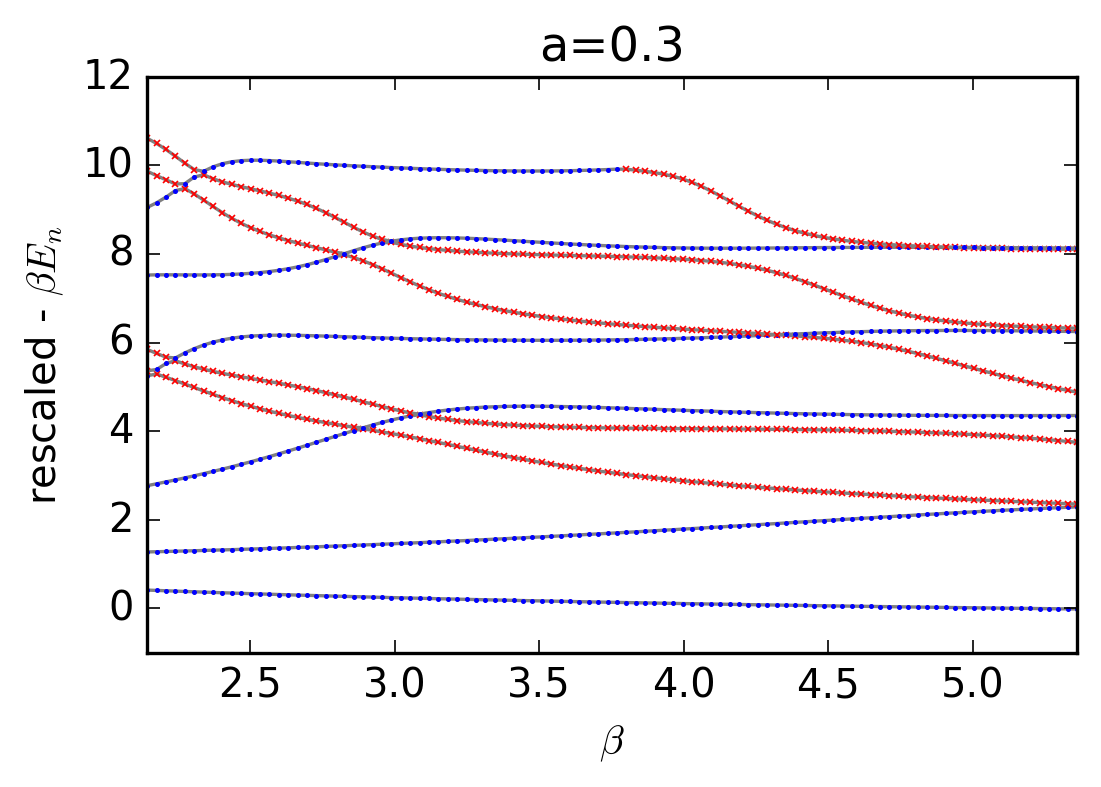

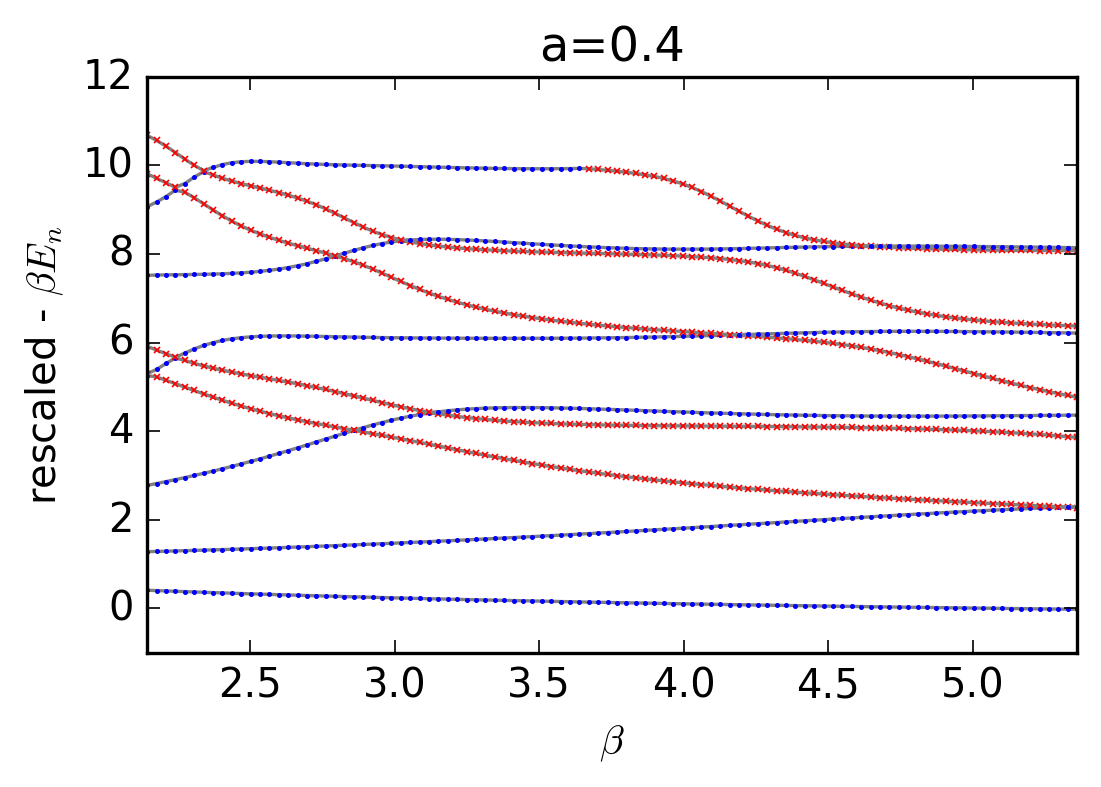

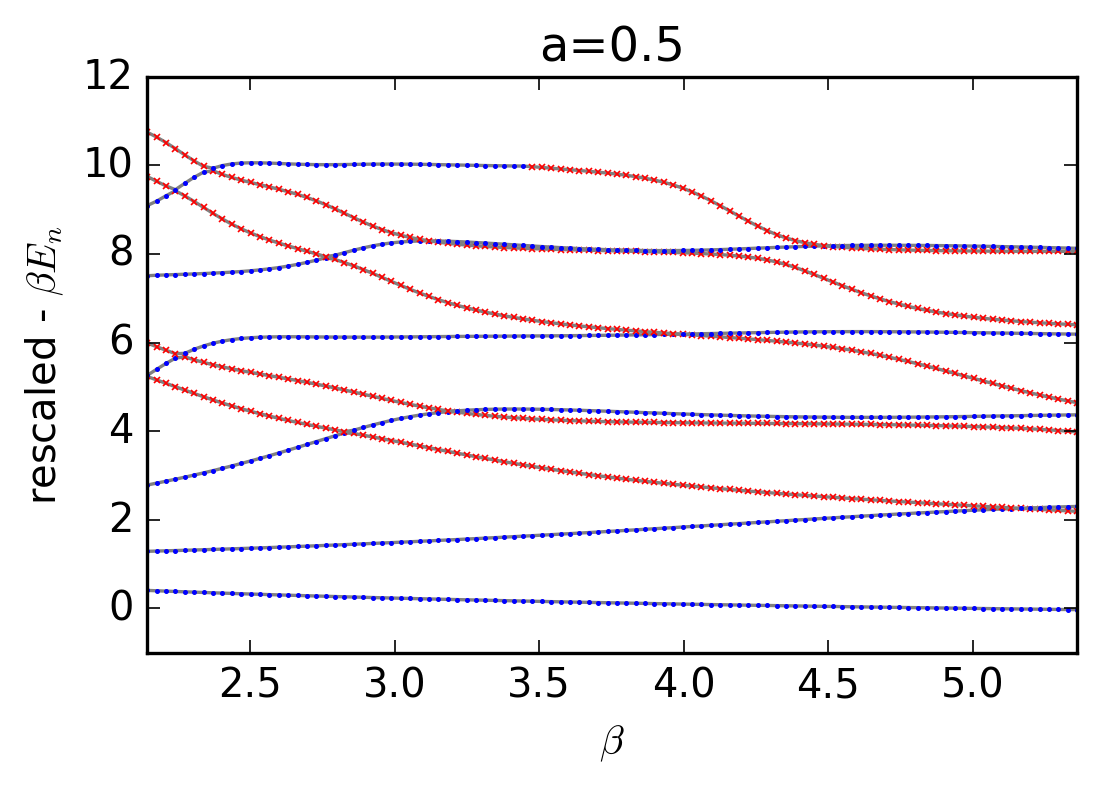

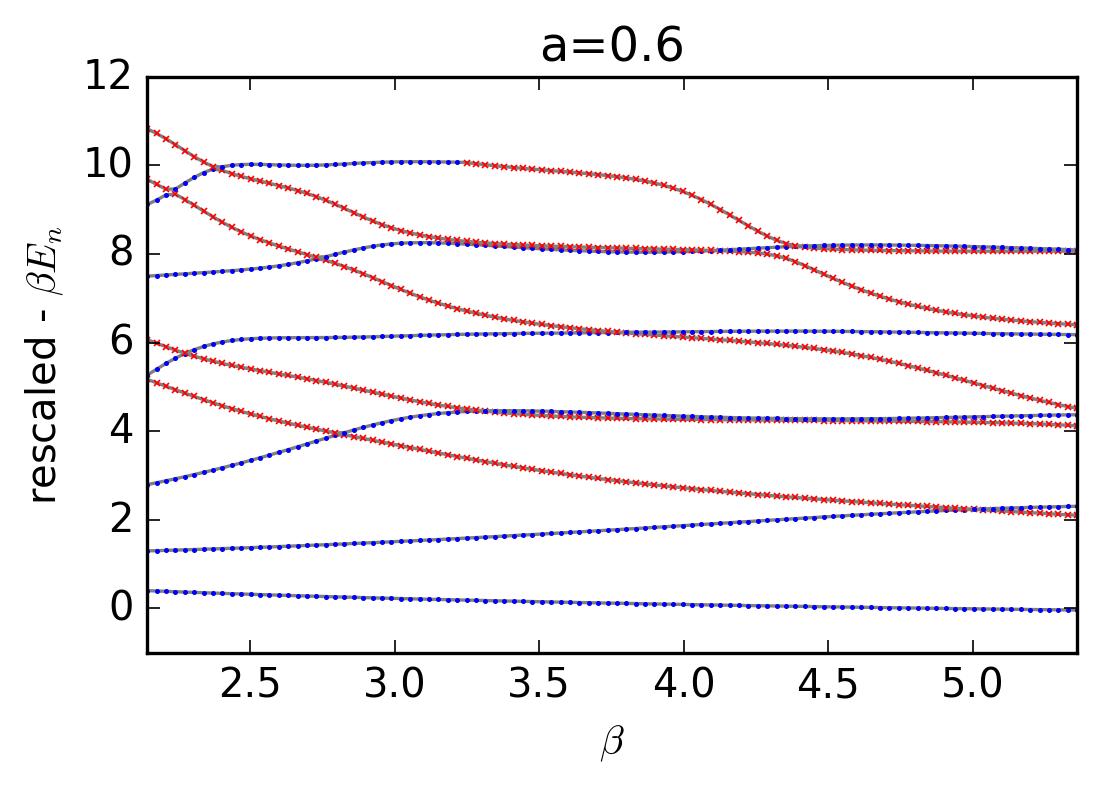

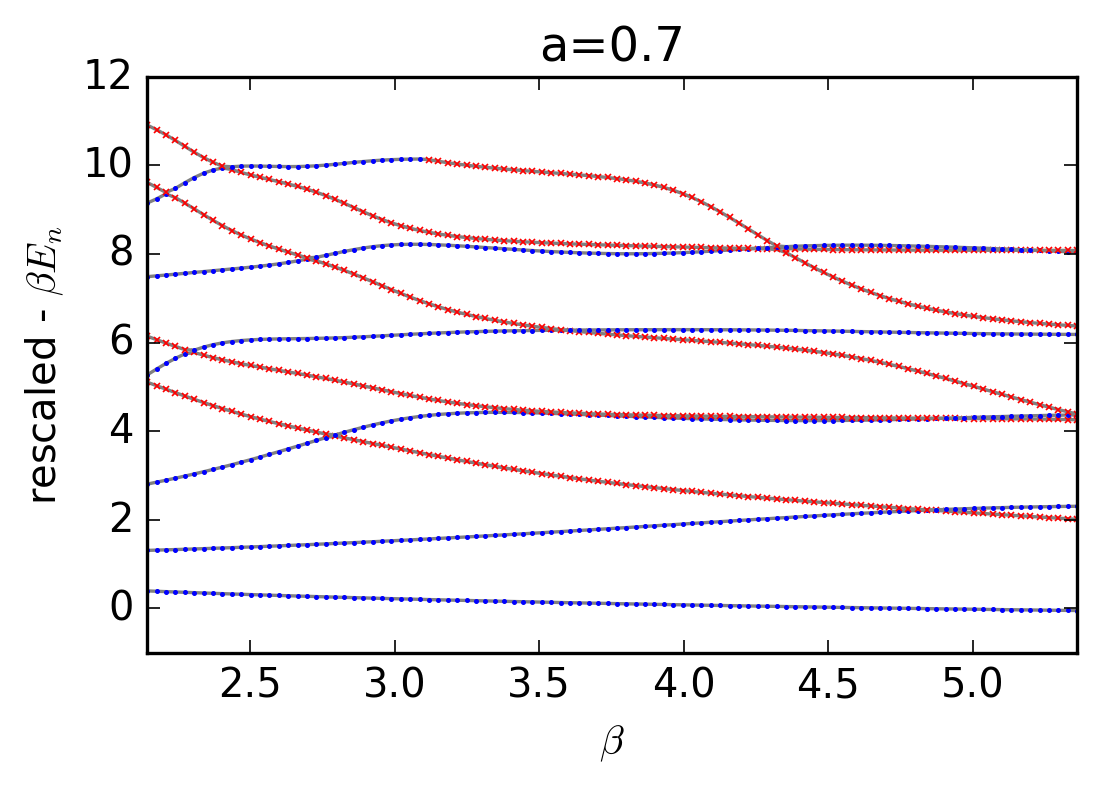

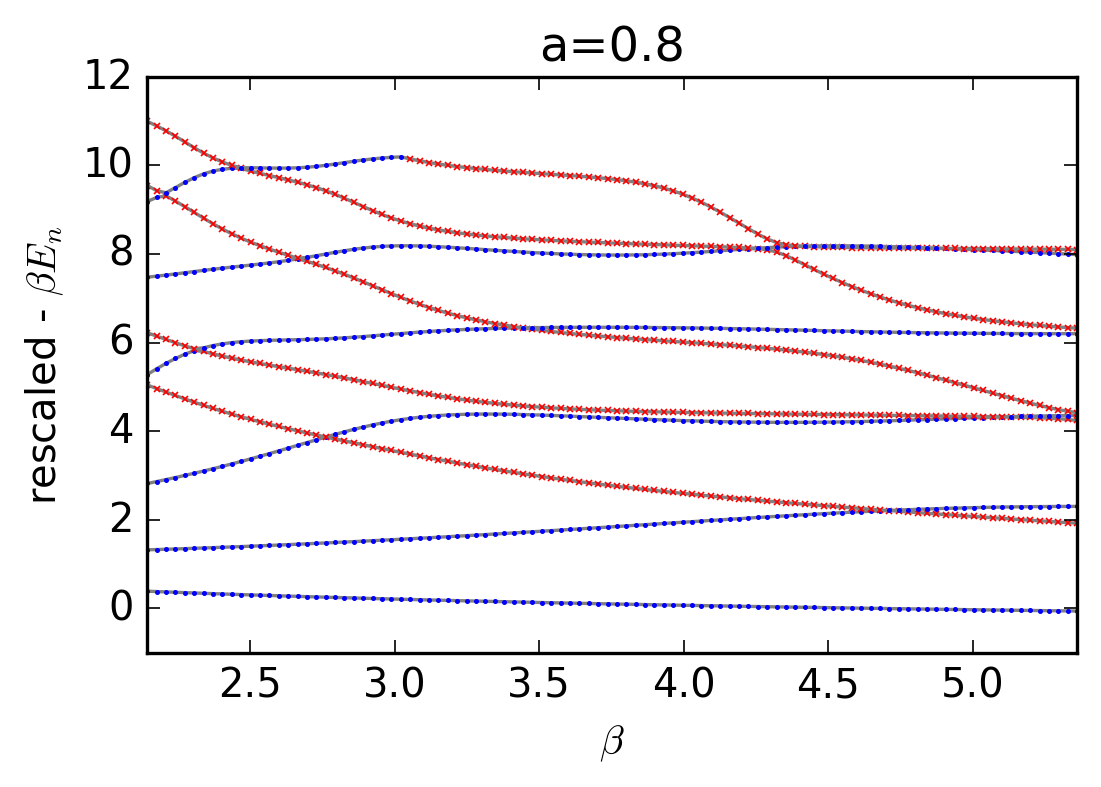

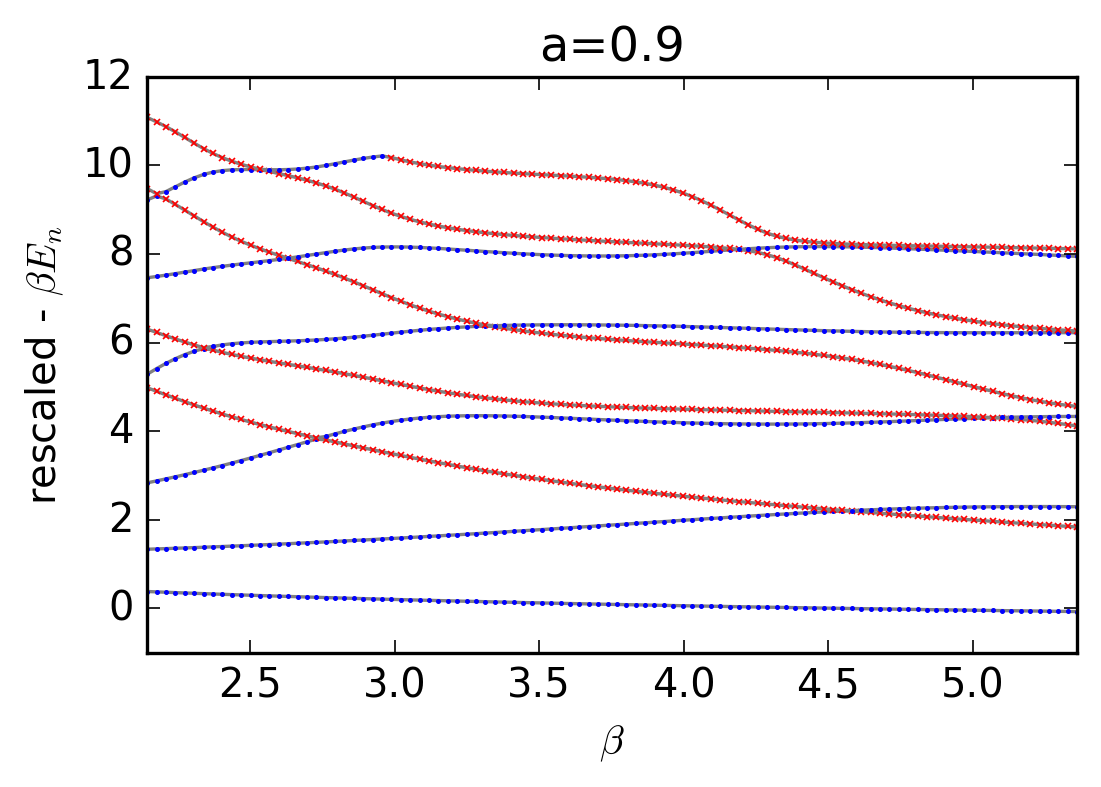

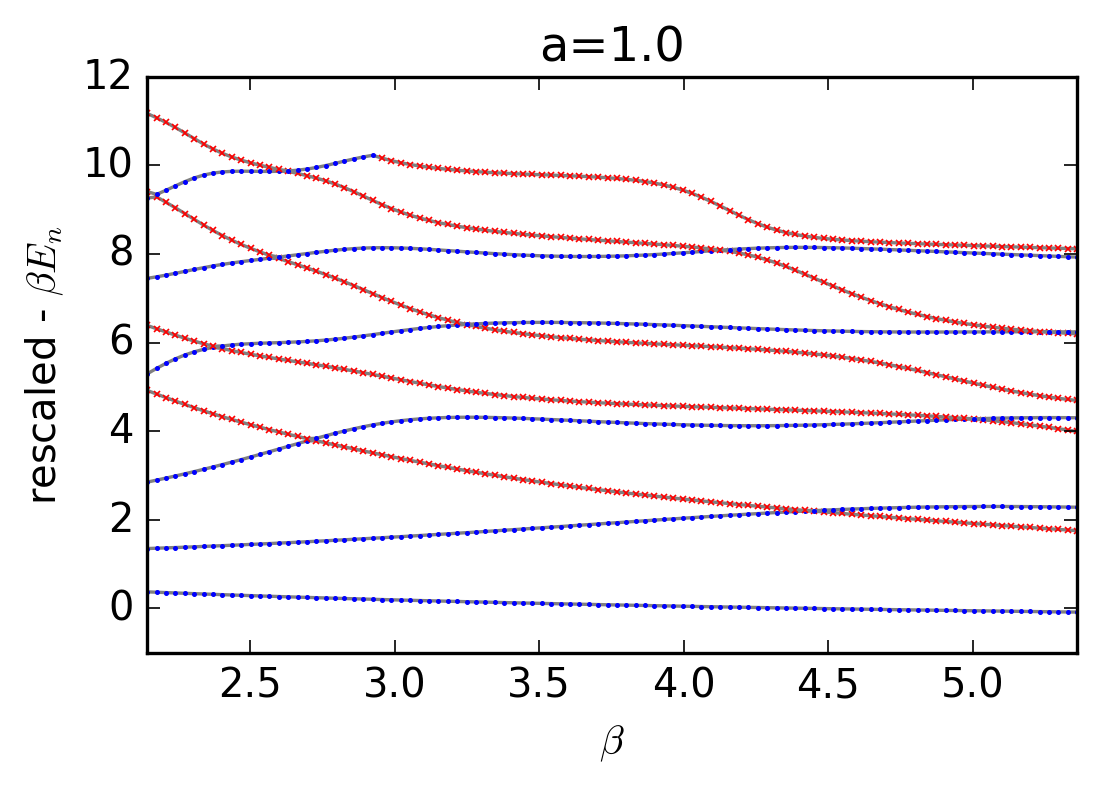

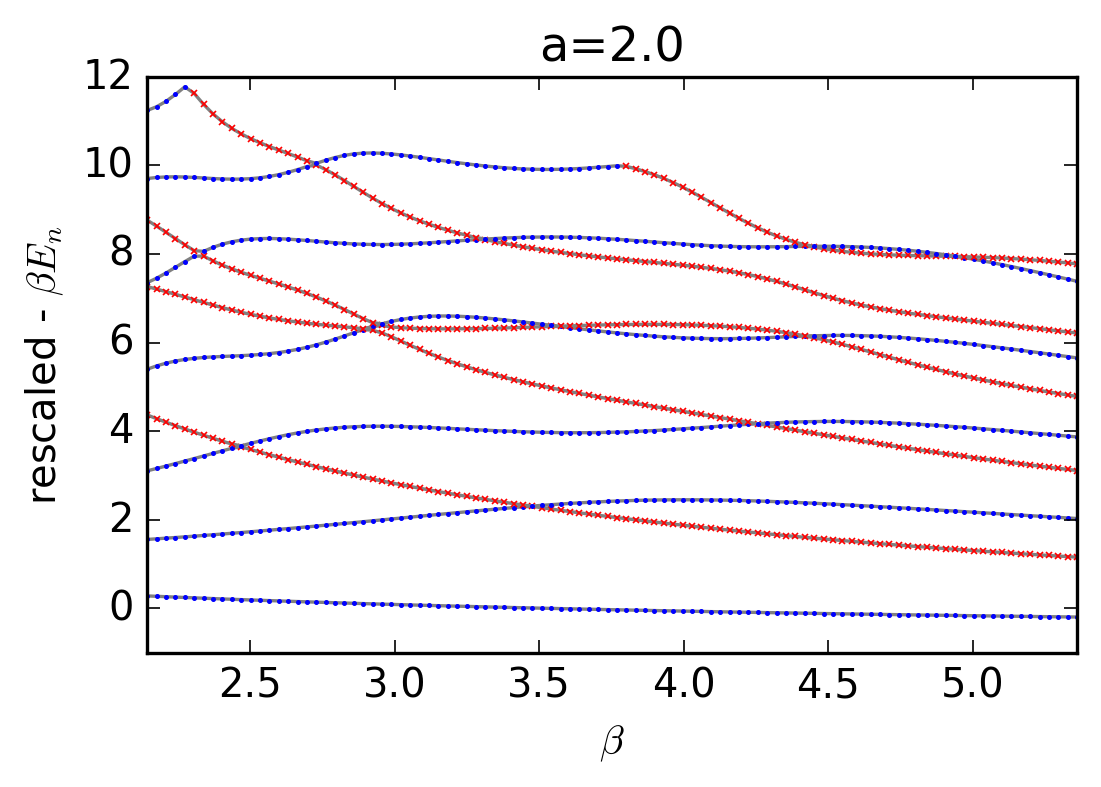

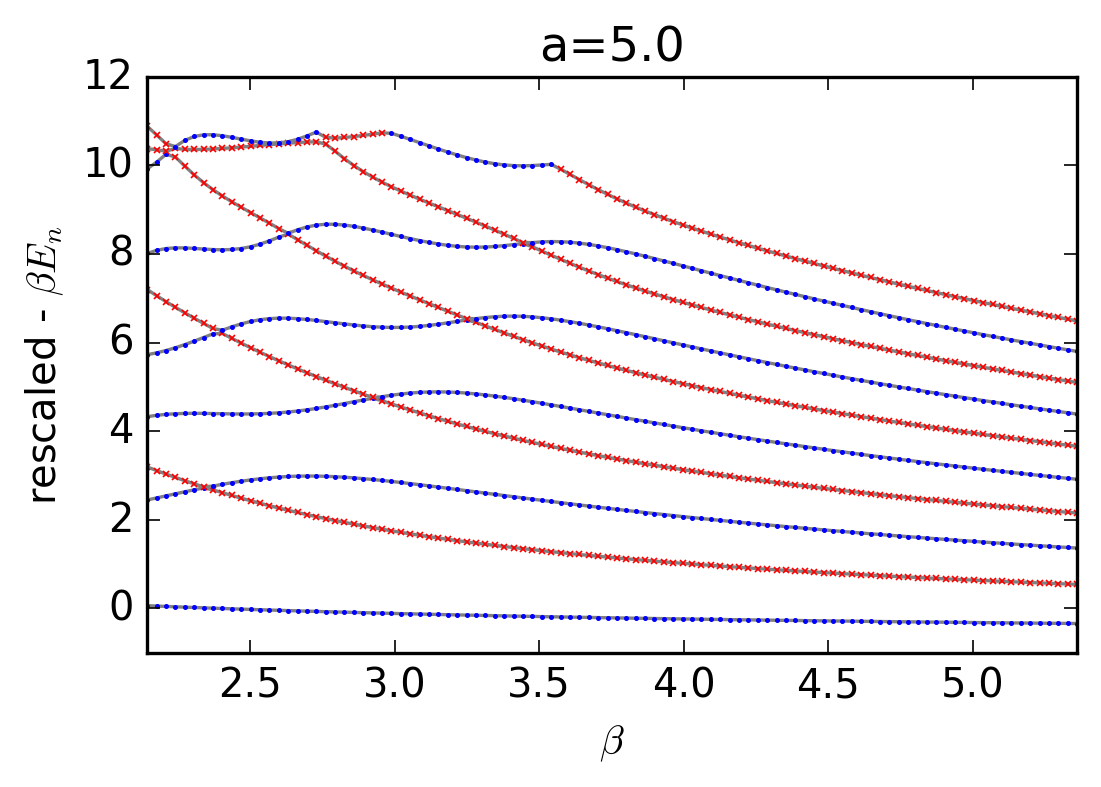

In [11]:
beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace
a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]
for a_q in a_Range: 
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    print(filename_base, end=' ')

    w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

    f, (ax2) = plt.subplots(1, 1, figsize = (5,3), dpi=240, frameon=False)
    states_n = 10

    colors = pl.cm.jet(np.linspace(0,1,states_n))

    for k in range(0, states_n):
        
        EigEnergies_pos = np.array([])
        beta_list_pos = np.array([])
        EigEnergies_neg = np.array([])
        beta_list_neg = np.array([])
        EigEnergies_re = np.zeros((len(beta_list_fine)))

        for j_i, j in enumerate(beta_list_fine): 
            EigEnergies_re[j_i] = -np.log(np.abs(w_alph_list_fine[j_i][k]))
            
            if w_alph_list_fine[j_i][k] >= 0: 
                EigEnergies_pos = np.append(EigEnergies_pos, EigEnergies_re[j_i])
                beta_list_pos = np.append(beta_list_pos, beta_list_fine[j_i])
            else: 
                EigEnergies_neg = np.append(EigEnergies_neg, EigEnergies_re[j_i])
                beta_list_neg = np.append(beta_list_neg, beta_list_fine[j_i])
        
        ax2.plot(beta_list_fine, EigEnergies_re, '-', color="grey")
        ax2.plot(beta_list_pos, EigEnergies_pos, ".", markersize=2, linewidth=0,color="b")
        ax2.plot(beta_list_neg, EigEnergies_neg, "x", markersize=2, linewidth=0,color="r")

    ax2.set_xlabel(r"$\beta$")
    ax2.set_ylabel(r"rescaled - $\beta E_n$")
    ax2.set_xlim([beta_list_fine[0], beta_list_fine[-1]])
    ax2.set_ylim([-1, 12])
    ax2.set_title("a="+str(float(a_q)))
    filename = "Plots_W/CM_eps"+str(eps)+"_energy_asym_"+ a_q +".png"
    f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)

print("pos - blue")
print("neg - red")

#### Weights at certain $a$ and $\beta$

#### Entropy

Plots_W/JJ_CM_eps0.5_entropy_quart.png
minimums: [3 8 8 8 8 8] [2 2 2 2 2 2]
vN: 0 2.080808080808081


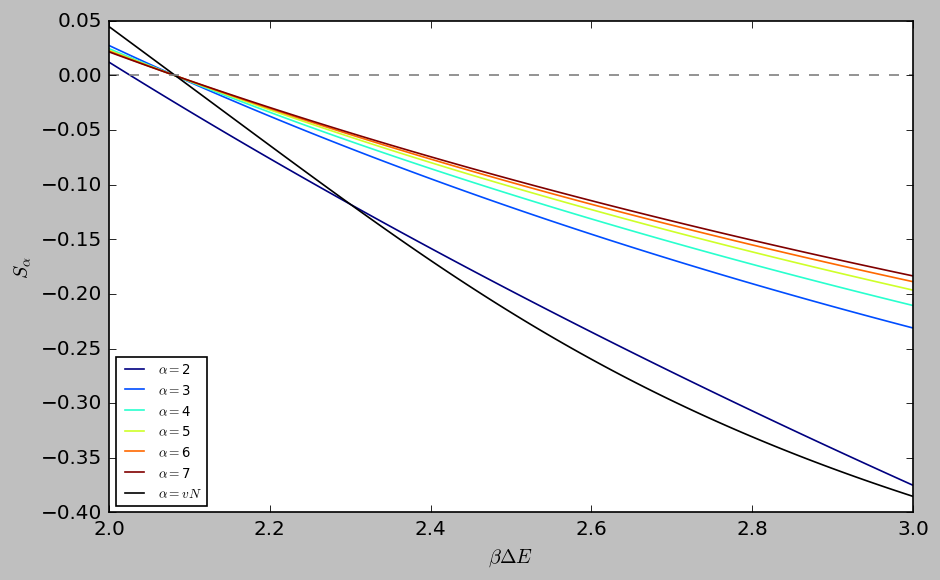

In [102]:
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)

powerRange = np.arange(2, 8, 1)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
# powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
    ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '-', color=colors[power_i],
             label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_list_fine[int(minS_point[power_i])]*levelSpace

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
ax1.plot(beta_list_fine*levelSpace, np.real(entropyV), '-', color='black', label=r"$\alpha=vN$")

ax1.plot(beta_list_fine*levelSpace, beta_list_fine*levelSpace*0, '--', color='gray')
# ax1.plot(beta_list_fine*0+beta_list_fine[np.int(minS_point[1])]*levelSpace, np.linspace(-.1,.2,len(beta_list_fine)), '--', color='gray')

ax1.set_ylabel(r"$S_\alpha$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.legend(fontsize=8, loc=3)
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_quart.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)
print("minimums:", minS_point, minS_beta)
print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace)


Plots_W/JJ_CM_eps0.5_entropy_asym_2e-1.png
minimums: [[92.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [96.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [96.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [96.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [96.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [96.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]] [[5.13300077 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [5.26295016 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [5.26295016 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [5.26295016 0.         0.         0.         0.         0.
  0.         0.         0.         0.   

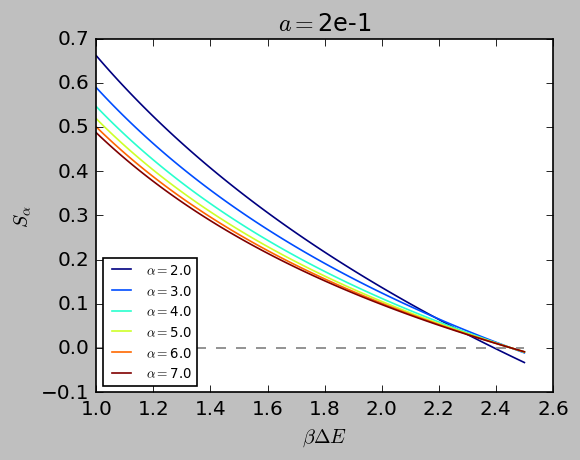

In [171]:
beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace
a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]
powerRange = np.arange(2., 8., 1)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
# powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros((len(powerRange), len(a_Range)))
minS_beta = np.zeros((len(powerRange), len(a_Range)))
for a_q_i, a_q in enumerate(a_Range[4:5]): 
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)
    
    f, ax1 = plt.subplots(1, 1, figsize = (5,4), dpi=120, frameon=True)

    colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

    for power_i, power in enumerate(powerRange):
        entropy2 = np.zeros_like(beta_list_fine, complex)
        for i in range(len(entropy2)): 
            entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
        
        ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '-', color=colors[power_i],
                 label=r"$\alpha=$"+str(round(power, 6)))

        minS_point[power_i, a_q_i] = np.argmin(np.abs(entropy2))
        minS_beta[power_i, a_q_i] = beta_list_fine[int(minS_point[power_i, a_q_i])]

    entropyV = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
#     ax1.plot(beta_list_fine*levelSpace, np.real(entropyV), '-', color='black', label=r"$\alpha=vN$")

    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*levelSpace*0, '--', color='gray')
    # ax1.plot(beta_list_fine*0+beta_list_fine[np.int(minS_point[1])]*levelSpace, np.linspace(-.1,.2,len(beta_list_fine)), '--', color='gray')

    ax1.set_ylabel(r"$S_\alpha$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax1.legend(fontsize=8, loc=3)
    ax1.set_title(r"$a = $"+a_q)
    f.tight_layout()

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_asym_"+a_q+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)
#     print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace)

print("minimums:", minS_point, minS_beta)



Plots_W/JJ_CM_eps0.5_entropy_asymSmall_dependence.png


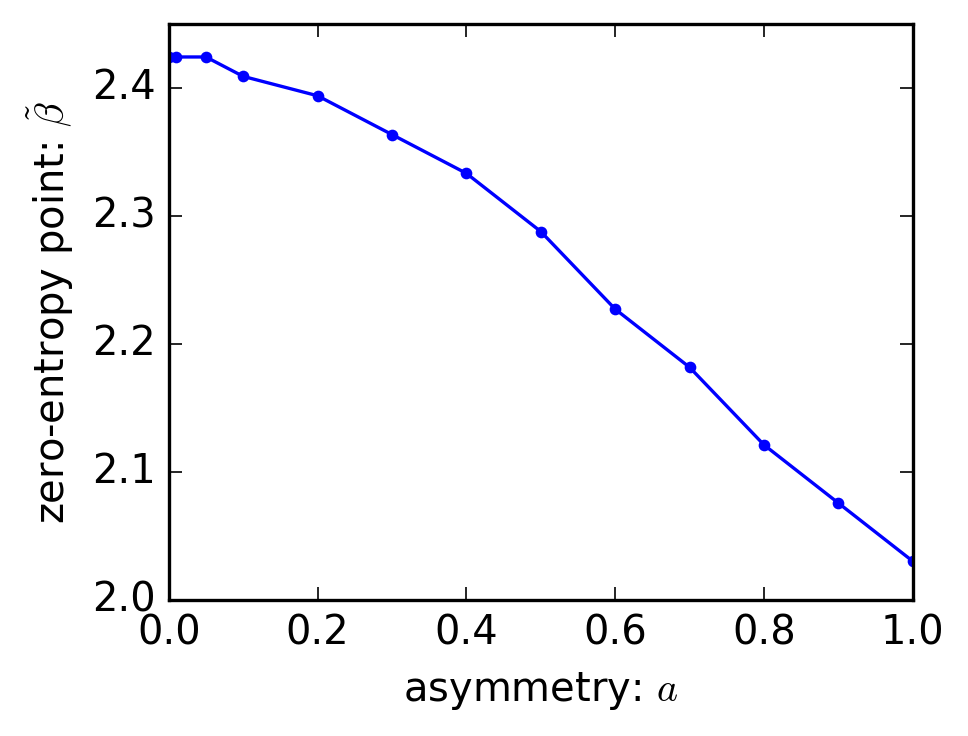

In [278]:
a_Range_q = np.zeros(len(a_Range))
for a_q_i, a_q in enumerate(a_Range): 
    a_Range_q[a_q_i] = float(a_Range[a_q_i])

f, ax1 = plt.subplots(1, 1, figsize = (4,3), dpi=240, frameon=False)
ax1.plot(a_Range_q[:-2], minS_beta[0,:-2]*levelSpace, '.-')
# ax1.plot(a_Range_q, minS_beta[2,:]*levelSpace, '.-')
ax1.set_xlabel(r"asymmetry: $a$")
ax1.set_ylabel(r"zero-entropy point: $\tilde{\beta}$")
# ax1.set_xscale("log")

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_asymSmall_dependence.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

#### Compute coupling matrix (AGP)

In [103]:
def readInWF(filename_base, filename_base_s, beta):     
    
    filename_weights = filename_base + str(round(beta,6)) + ".txt"
    filename_states = filename_base_s + str(round(beta,6)) + ".txt"
    
    ## Read the weights and states from text files
    w_alph = np.loadtxt("diagW/"+filename_weights, dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/"+filename_states, dtype = "complex", delimiter=',', comments='#')
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx)), 3)
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    return x1_range_q, w_alph/np.sum(w_alph), psi_alph

beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
a_Range = ["1e-1"]
for a_q in a_Range: 
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"
    
    beta = beta_Range[3]
    print(filename_base, beta)
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)

print(len(psi_alph), len(x_range_q))

SingleT_asym_1e-1/JJ_CM_weights_nearMore 2.2416269188294686


IndexError: index 10 is out of bounds for axis 1 with size 10

SingleT_asym_1e-1/JJ_CM_weights_nearMore 

Text(0.5, 1.0, 'a=0.1')

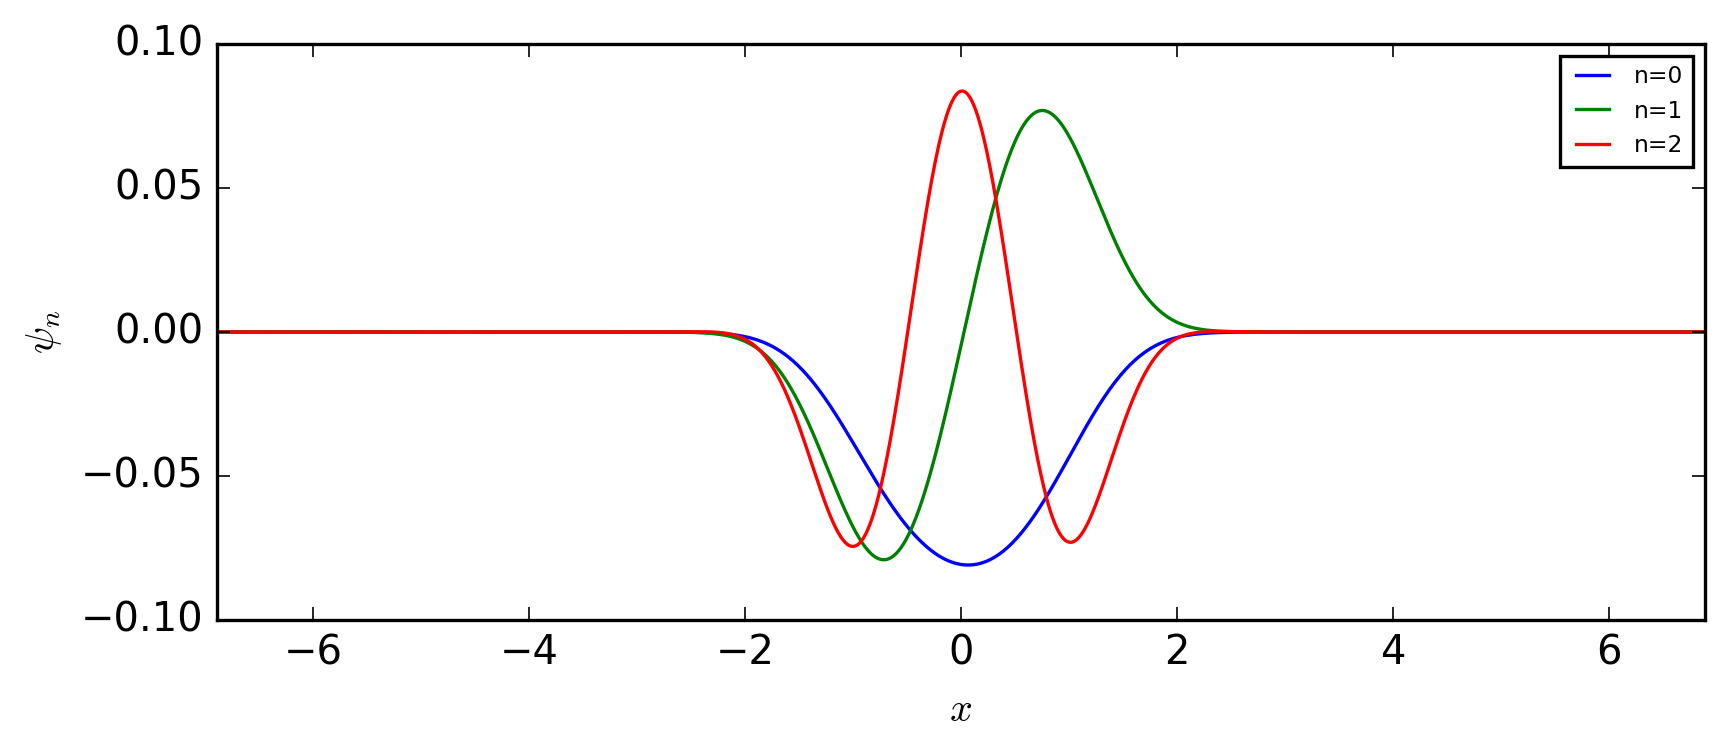

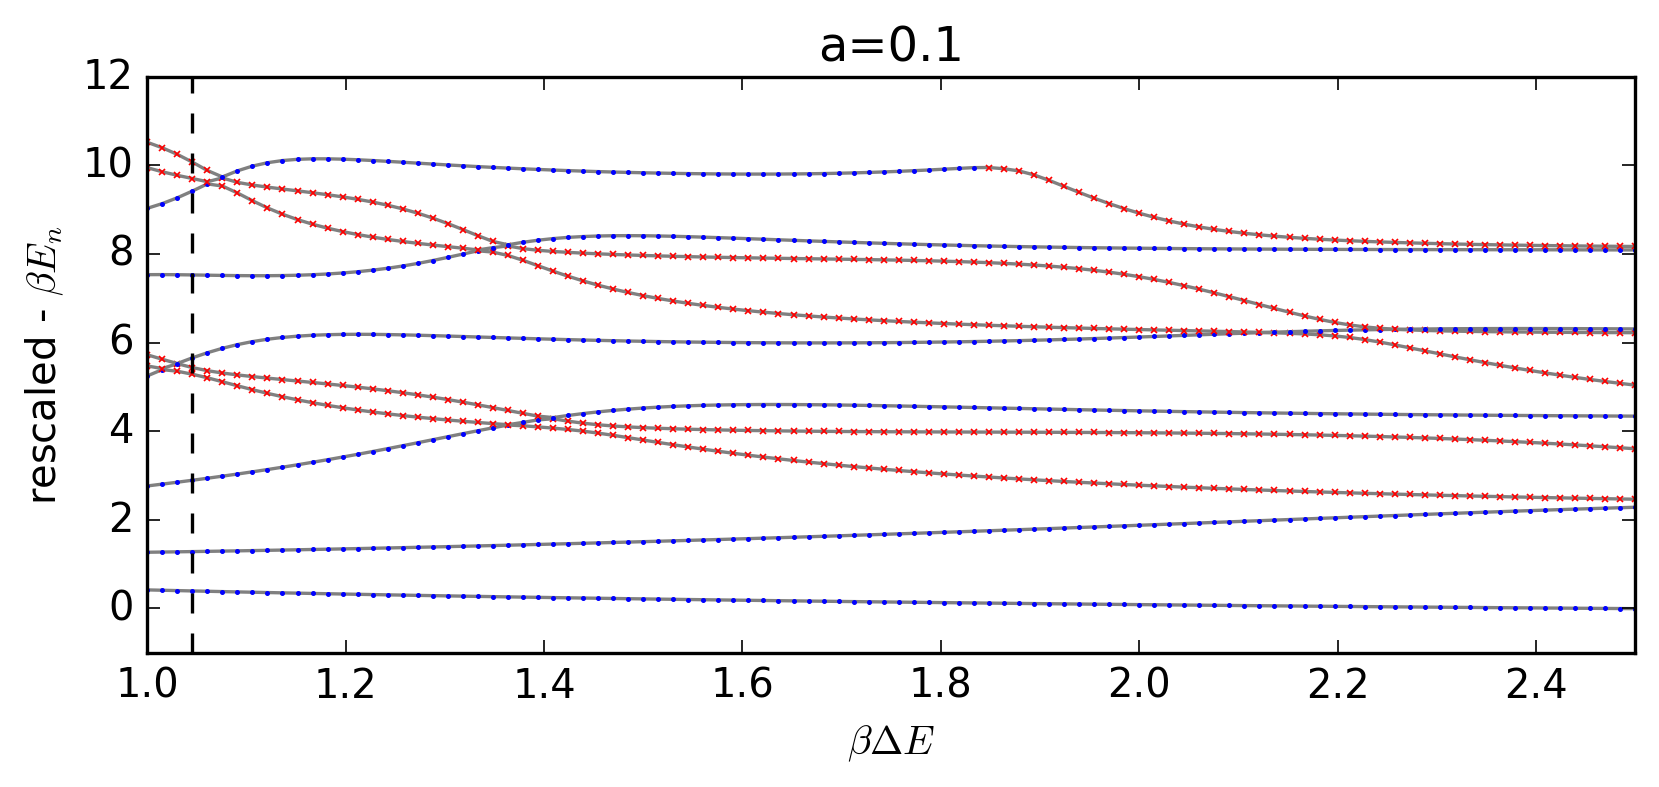

In [8]:
##Plot eigenstates
f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
ax1.plot(x_range_q, np.real(psi_alph[:,0]), label="n=0")
ax1.plot(x_range_q, np.real(psi_alph[:,1]), label="n=1")
ax1.plot(x_range_q, np.real(psi_alph[:,2]), label="n=2")
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$\psi_n$")
ax1.set_xlabel(r"$x$")
ax1.set_xlim([x_range_q[0], x_range_q[-1]])

beta_list_fine = np.linspace(1.0, 2.5, 100) / levelSpace

a_q = a_Range[0]
filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
print(filename_base, end=' ')

w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
states_n = 10

colors = pl.cm.jet(np.linspace(0,1,states_n))

for k in range(0, states_n):

    EigEnergies_pos = np.array([])
    beta_list_pos = np.array([])
    EigEnergies_neg = np.array([])
    beta_list_neg = np.array([])
    EigEnergies_re = np.zeros((len(beta_list_fine)))

    for j_i, j in enumerate(beta_list_fine): 
        EigEnergies_re[j_i] = -np.log(np.abs(w_alph_list_fine[j_i][k]))

        if w_alph_list_fine[j_i][k] >= 0: 
            EigEnergies_pos = np.append(EigEnergies_pos, EigEnergies_re[j_i])
            beta_list_pos = np.append(beta_list_pos, beta_list_fine[j_i])
        else: 
            EigEnergies_neg = np.append(EigEnergies_neg, EigEnergies_re[j_i])
            beta_list_neg = np.append(beta_list_neg, beta_list_fine[j_i])

    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re, '-', color="grey")
    ax2.plot(beta_list_pos*levelSpace, EigEnergies_pos, ".", markersize=2, linewidth=0,color="b")
    ax2.plot(beta_list_neg*levelSpace, EigEnergies_neg, "x", markersize=2, linewidth=0,color="r")
    
ax2.plot(np.linspace(0,1)*0+beta*levelSpace, np.linspace(-1,12), 'k--')
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax2.set_xlim([1, 2.5])
ax2.set_ylim([-1, 12])
ax2.set_title("a="+str(float(a_q)))

In [67]:
## Compute matrix components 

def V(x): 
    a=float(a_Range[0])
    return omega/4 * (x**4 - a*x)

def M_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta): 
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    W1_psi = np.dot(d_beta_W, psi_alph[:,k])
    A_n = np.vdot(W1_psi, psi_alph[:,j]) / Zx
    
    return np.abs(A_n)**2 / (np.real(w_alph[j] - w_alph[k])**2)

n_Max = 10
Coupling_M = np.zeros((n_Max, n_Max))

d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
for x1_i, x1 in enumerate(x_range_q): 
    xi = x1 - x_range_q
    x_x = (x1 + x_range_q) / 2
    d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                        * np.exp((-m*xi**2)/(2.*beta*eps**2)-beta*V(x_x))
    
for j in range(2,n_Max): 
    for k in range(n_Max): 
        if j!=k: 
            Coupling_M[j,k] = M_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta)
            Coupling_M[k,j] = M_nm(k,j, d_beta_W, x_range_q, w_alph, psi_alph, beta)


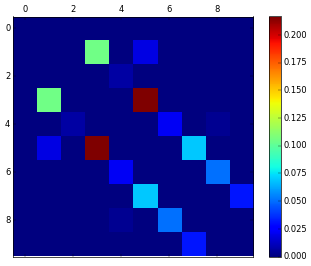

In [68]:
fig, ax1 = plt.subplots(1, 1, figsize = (8,6), dpi=50, frameon=False)
im = ax1.matshow(Coupling_M, cmap=plt.cm.jet)
# im = ax1.matshow(np.log10(Coupling_M, where=Coupling_M!=0), cmap=plt.cm.jet)

# Add a colorbar
fig.colorbar(im, ax=ax1)


In [69]:
## Computing coupling vs. beta
n_Max = 10
Coup_M_beta = np.zeros((n_Max, n_Max,len(beta_Range)))

beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
a_q = a_Range[0]
for beta_i, beta in enumerate(beta_Range): 
    print(beta_i, end=" ")
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"
    
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    
    Coupling_M = np.zeros((n_Max, n_Max))

    d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
    for x1_i, x1 in enumerate(x_range_q): 
        xi = x1 - x_range_q
        x_x = (x1 + x_range_q) / 2
        d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                        * np.exp((-m*xi**2)/(2.*beta*eps**2)-beta*V(x_x))

    for j in range(n_Max): 
        for k in range(j+1,n_Max): 
            Coupling_M[j,k] = M_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta)
            Coupling_M[k,j] = M_nm(k,j, d_beta_W, x_range_q, w_alph, psi_alph, beta)

    Coup_M_beta[:,:, beta_i] = Coupling_M[:,:]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Plots_W/JJ_CM_eps0.5_AGP_asym_0.png


Text(0.5, 1.0, '$a=0.0$')

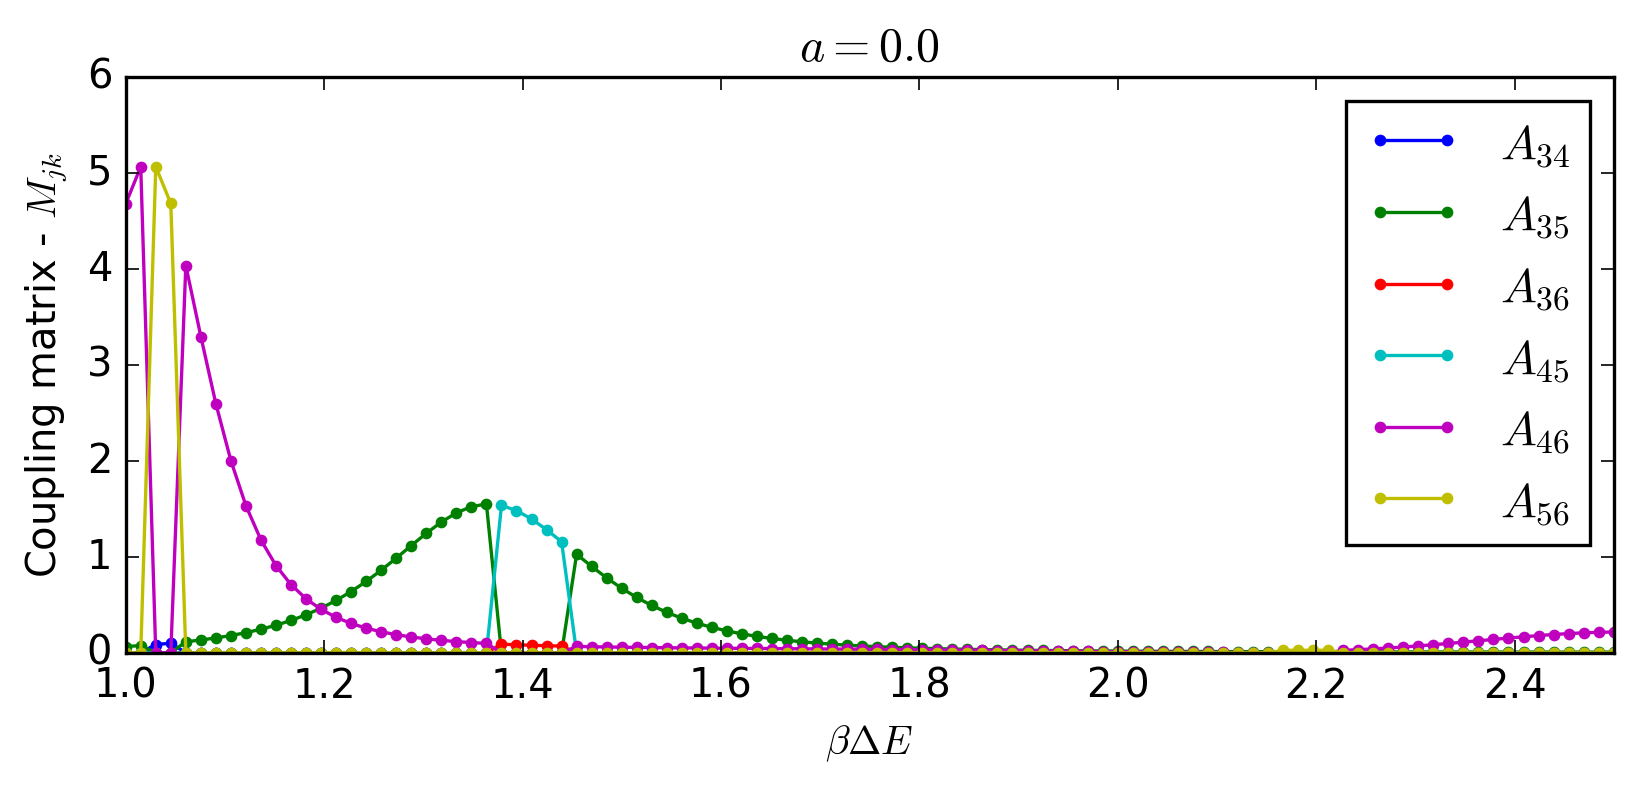

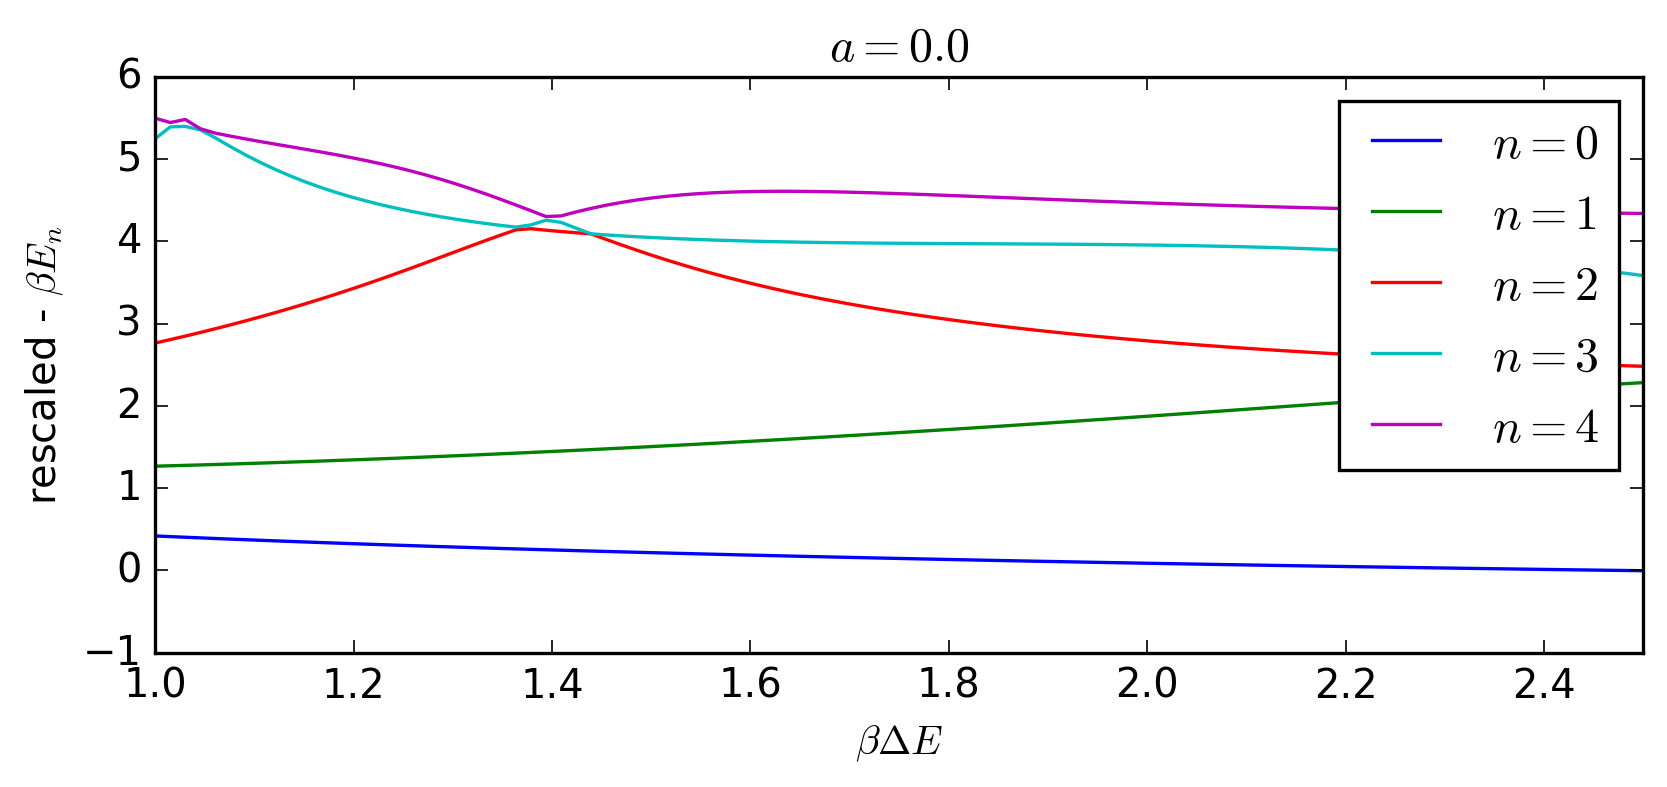

In [70]:
filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

for j in range(3,n_Max-3): 
    for k in range(j+1,n_Max-3): 
        ax2.plot(beta_list_fine*levelSpace, Coup_M_beta[j-1,k-1,:], ".-", label=r"$A_{"+str(j)+str(k)+"}$")
    
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"Coupling matrix - $M_{jk}$")
ax2.set_xlim([1, 2.5])
# ax2.set_ylim([-0.1,2])
ax2.set_title(r"$a="+str(float(a_q))+"$")
ax2.legend()
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_AGP_asym_"+ a_q +".png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
states_n = 5
for k in range(0, states_n):
    EigEnergies_re = np.zeros((len(beta_list_fine)))

    for j_i, j in enumerate(beta_list_fine): 
        EigEnergies_re[j_i] = -np.log(np.abs(w_alph_list_fine[j_i][k]))

    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re, '-', label=r"$n="+str(k)+"$")
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax2.set_xlim([1, 2.5])
ax2.set_ylim([-1, 6])
ax2.legend()
ax2.set_title(r"$a="+str(float(a_q))+"$")

##### Repeating calc for all $a$

In [17]:
a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]

for a_q in a_Range: 
    Coup_M_beta = np.zeros((4,4,len(beta_Range)))

    beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
    print(a_q)
    
    for beta_i, beta in enumerate(beta_Range): 
        print(beta_i, end=" ")
        filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
        filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"

        x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)

        n_Max = 5
        Coupling_M = np.zeros((n_Max, n_Max))

        for j in range(n_Max): 
            for k in range(j,n_Max): 
                if j!=k: 
                    Coupling_M[j,k] = M_nm(j,k, x_range_q, w_alph, psi_alph, beta)
                    Coupling_M[k,j] = M_nm(k,j, x_range_q, w_alph, psi_alph, beta)

        Coup_M_beta[:,:, beta_i] = Coupling_M[1:,1:]

    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

    f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

    for j in range(1,n_Max): 
        for k in range(j+1,n_Max): 
            ax2.plot(beta_list_fine*levelSpace, Coup_M_beta[j-1,k-1,:], ".-", label=r"$A_{"+str(j)+str(k)+"}$")

    ax2.set_xlabel(r"$\beta \Delta E$")
    ax2.set_ylabel(r"Coupling matrix - $M_{jk}$")
    ax2.set_xlim([1, 2.5])
    ax2.set_ylim([-0.1,2])
    ax2.set_title(r"$a="+str(float(a_q))+"$")
    ax2.legend()
    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_AGP_asym_"+ a_q +".png"
    f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)
    plt.close()

0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Plots_W/JJ_CM_eps0.5_AGP_asym_0.png
1e-2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Plots_W/JJ_CM_eps0.5_AGP_asym_1e-2.png
5e-2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Plots_W/JJ_CM_eps0.5_AGP_asym_5e-2.png
1e-1

#### Norm of AGP

$$ \text{Norm}[n] = \sum_j \frac{ |\langle j| \partial_\beta W | n\rangle|^2 }{ (w_j - w_n)^2 }$$ 

In [109]:
## Computing coupling vs. beta

# def V(x): 
#     a=float(a_Range[0])
#     return omega/4 * x**4
#     return omega/4 * (x**4 - a*x)

a_Range = ["0"]
# beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
beta_Range = np.linspace(0.1, 4.0, 200) / levelSpace
n_Max = 10

A_n = np.zeros((n_Max, len(beta_Range))); A_n_weight = np.zeros((len(beta_Range)))
entropy = np.zeros_like(beta_Range, complex)
a_q = a_Range[0]
for beta_i, beta in enumerate(beta_Range):  
    print(beta_i, end=" ")
#     filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
#     filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"
#     filename_base = "SingleT_quartic/JJ_CM_weights_nearMore"
#     filename_base_s = "SingleT_quartic/JJ_CM_states_nearMore"
#     filename_base = "SingleT_asym/JJ_CM_weights_nearMore"
#     filename_base_s = "SingleT_asym/JJ_CM_states_nearMore" 
    filename_base = "SingleT_JJ_3T/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_JJ_3t/JJ_CM_states_nearMore"

    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    w_alph /=np.sum(w_alph)
    
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
    for x1_i, x1 in enumerate(x_range_q): 
        xi = x1 - x_range_q
        x_x = (x1 + x_range_q) / 2
        d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                             * np.exp((-m*xi**2)/(2.*beta*eps**2)) * np.exp(-beta*V(x_x)) / Zx
    for j in range(n_Max): 
        dbW_psi = np.dot(d_beta_W,psi_alph[:,j])
        for k in range(n_Max): 
            if j!=k: 
                A_n[j,beta_i]+= np.abs(np.vdot(psi_alph[:,k],dbW_psi))**2/np.real(w_alph[j] - w_alph[k])**2
    for j in range(n_Max): 
        A_n_weight[beta_i] += np.sum(np.real(w_alph[:n_Max])**2 * np.abs(A_n[:,beta_i])**2)
    entropy[beta_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

Plots_W/CM_eps0.5_AGPnorm_asym.png


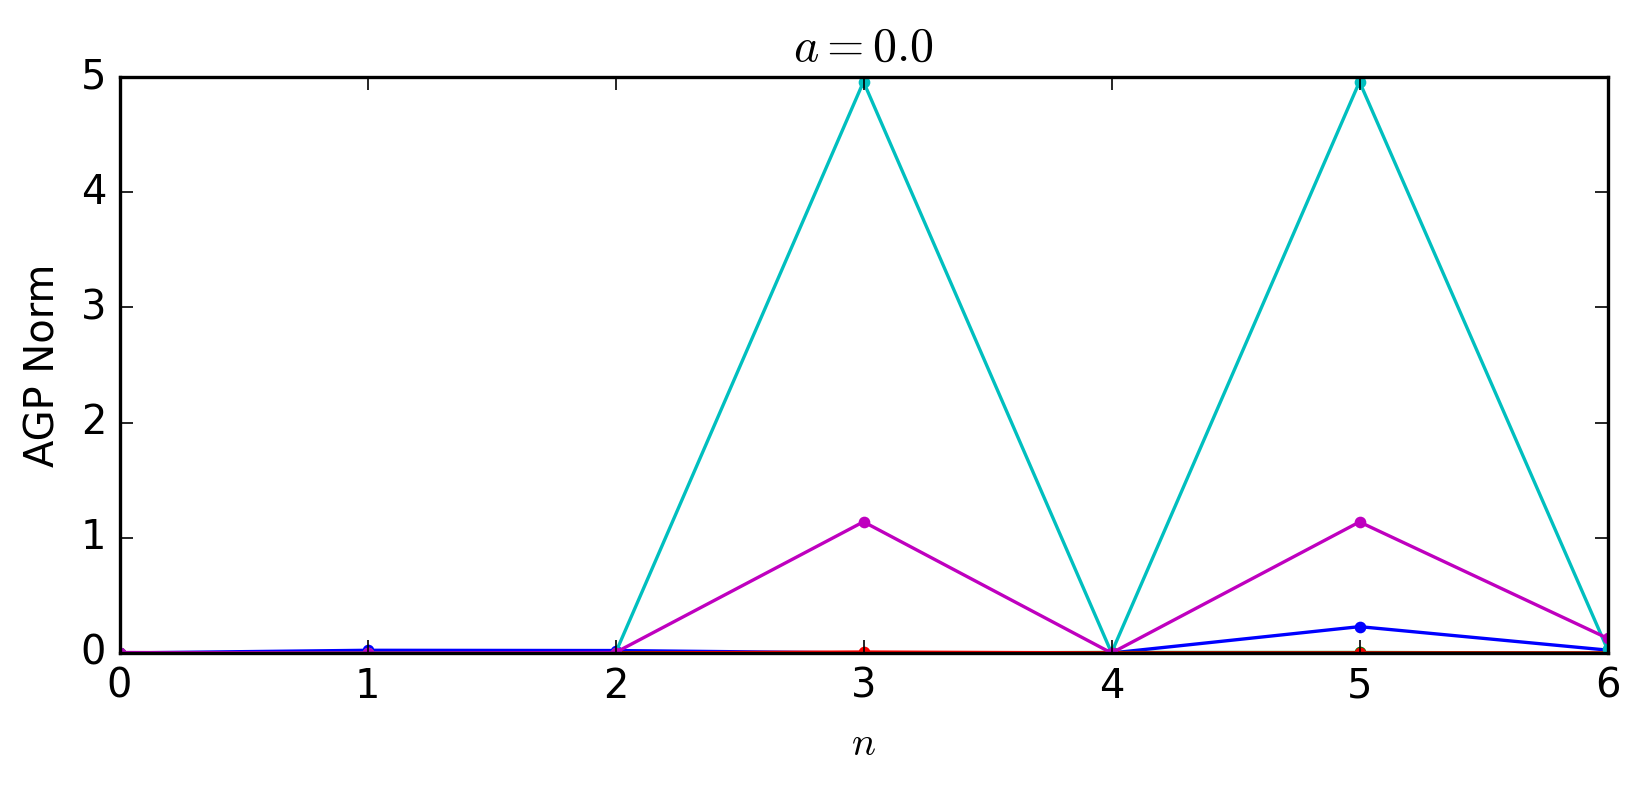

In [110]:
f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

# ax2.plot(A_n[:7,0], '.-', label=beta_Range[0])
ax2.plot(A_n[:7,25], '.-', label=beta_Range[25])
ax2.plot(A_n[:7,50], '.-', label=beta_Range[50])
ax2.plot(A_n[:7,75], '.-', label=beta_Range[75])
ax2.plot(A_n[:7,105], '.-', label=beta_Range[75])
ax2.plot(A_n[:7,122], '.-', label=beta_Range[75])
ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"AGP Norm")
# ax2.legend(fontsize=8)
ax2.set_title(r"$a="+str(float(a_q))+"$")
filename = "Plots_W/CM_eps"+str(eps)+"_AGPnorm_asym.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


Plots_W/CM_eps0.5_AGPnorm_weighted_asym.png


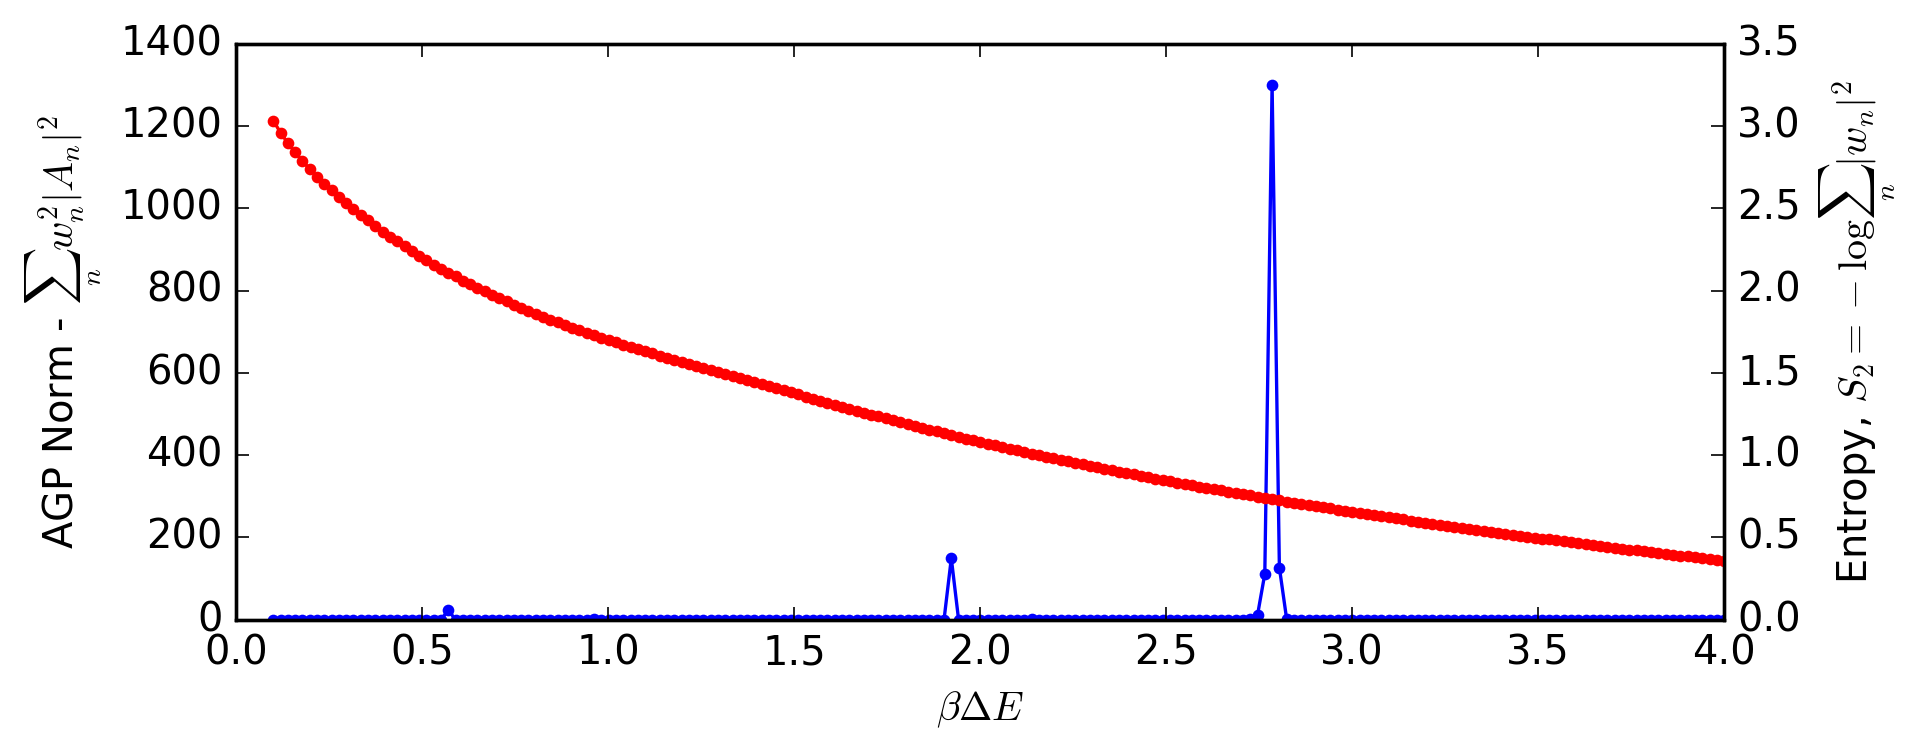

In [111]:
f, (ax) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

ax.plot(beta_Range*levelSpace, A_n_weight, '.-')    
ax.set_xlabel(r"$\beta \Delta E$")
ax.set_ylabel(r"AGP Norm - $\sum_n w_n^2 |A_n|^2$")
# ax.set_title(r"$a="+str(float(a_q))+"$")
# ax.set_ylim(0,10)

ax2 = ax.twinx()
ax2.plot(beta_Range*levelSpace, np.abs(entropy), 'r.-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_eps"+str(eps)+"_AGPnorm_weighted_asym.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


### Recreating the Distributions 

In [662]:
def readInWF(filename_base, beta):     
    filename = filename_base + str(round(beta,6)) + ".txt"
    filename_weights = "JJ_CM_weights_nearMore" + str(round(beta,6)) + ".txt"
    
    ## Read the histogram array using Numpy commands. 
#     w_alph = np.loadtxt("diagW/SingleT_asym/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
#     psi_alph = np.loadtxt("diagW/SingleT_asym/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Read the histogram array using Numpy commands. 
    w_alph = np.loadtxt("diagW/SingleT_quartic/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/SingleT_quartic/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx)), 3)
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    return x1_range_q, sorted_w_alph[:20], sorted_psi_alph[:,:20]

## quartic
beta_list_fine = np.linspace(0.1, 4.0, 200) / levelSpace

## Get weights
beta_test = beta_list_fine[10]
x1_range_q, w_alph, psi_alph = readInWF("JJ_CM_states_nearMore", beta_test)

(-150.0, 150.0)

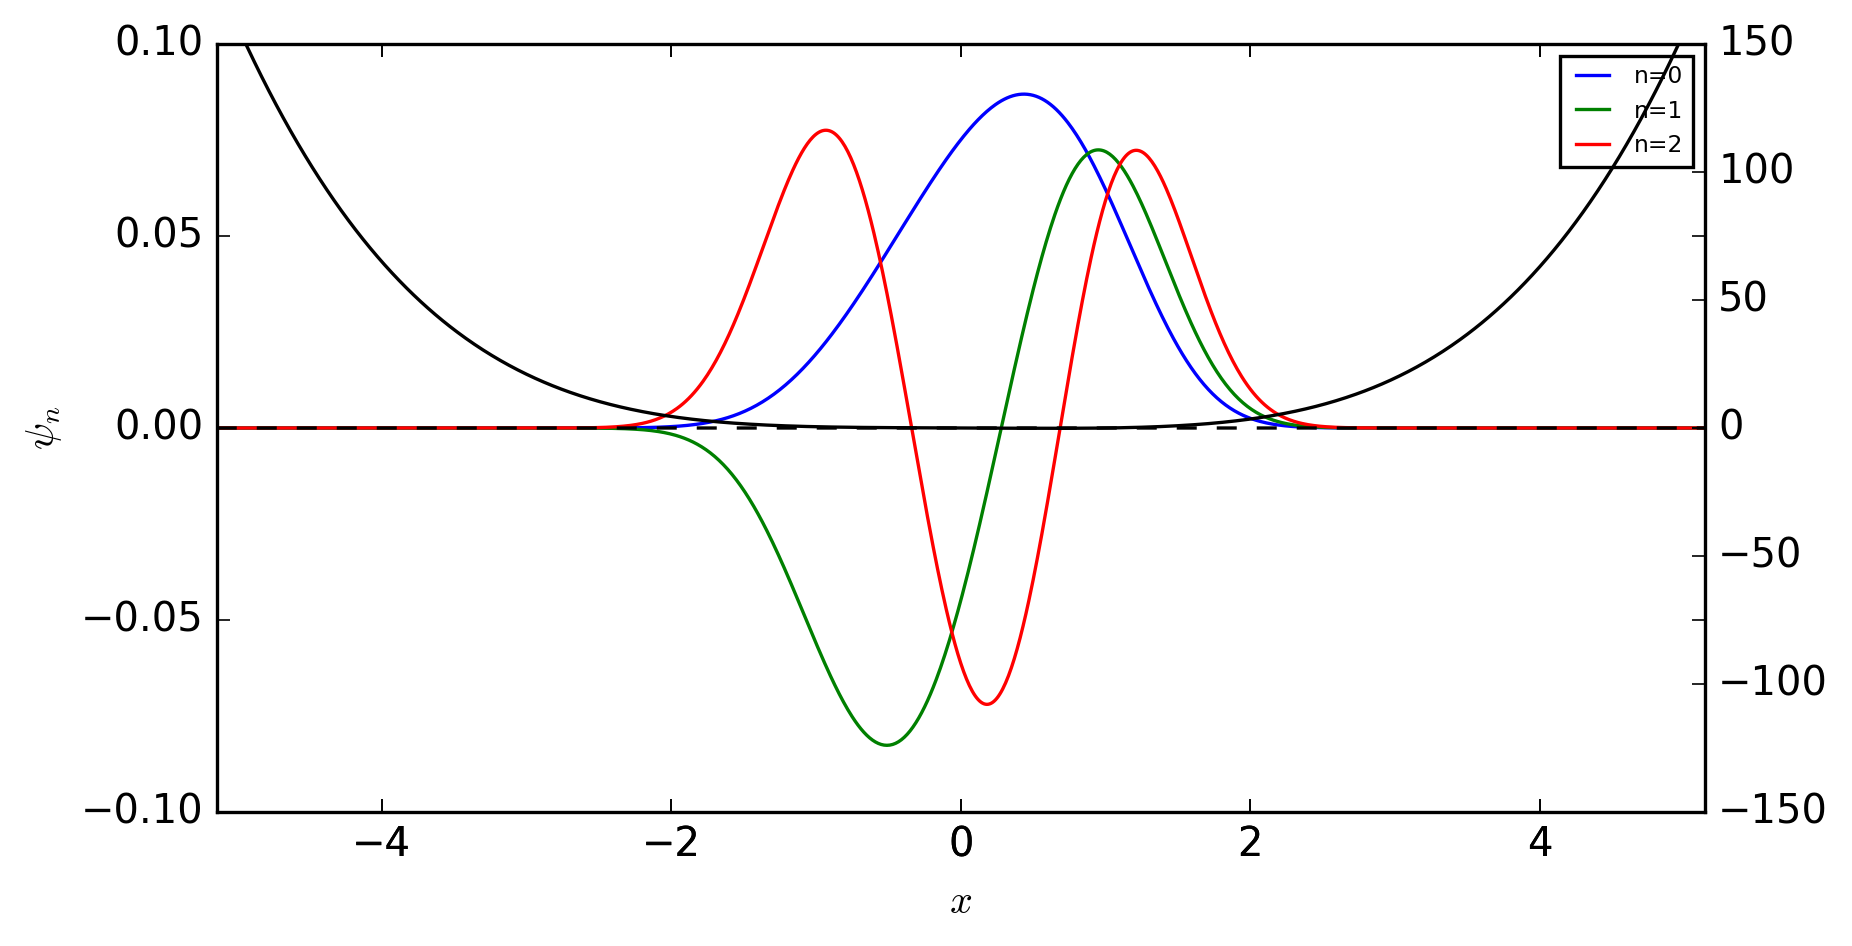

In [382]:
##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
ax1.plot(x1_range_q, np.real(psi_alph[:,0]), label="n=0")
ax1.plot(x1_range_q, np.real(psi_alph[:,1]), label="n=1")
ax1.plot(x1_range_q, np.real(psi_alph[:,2]), label="n=2")
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$\psi_n$")
ax1.set_xlabel(r"$x$")
ax1.set_xlim([x1_range_q[0], x1_range_q[-1]])

ax2 = f.add_subplot(111, sharex=ax1, frameon=False)
ax2.plot(x1_range_q, V(x1_range_q), color='k')
ax2.plot(x1_range_q, V(x1_range_q)*0, 'k--')
ax2.yaxis.tick_right()
ax2.set_ylim([-150, 150])

Text(0.5, 0, '$x$')

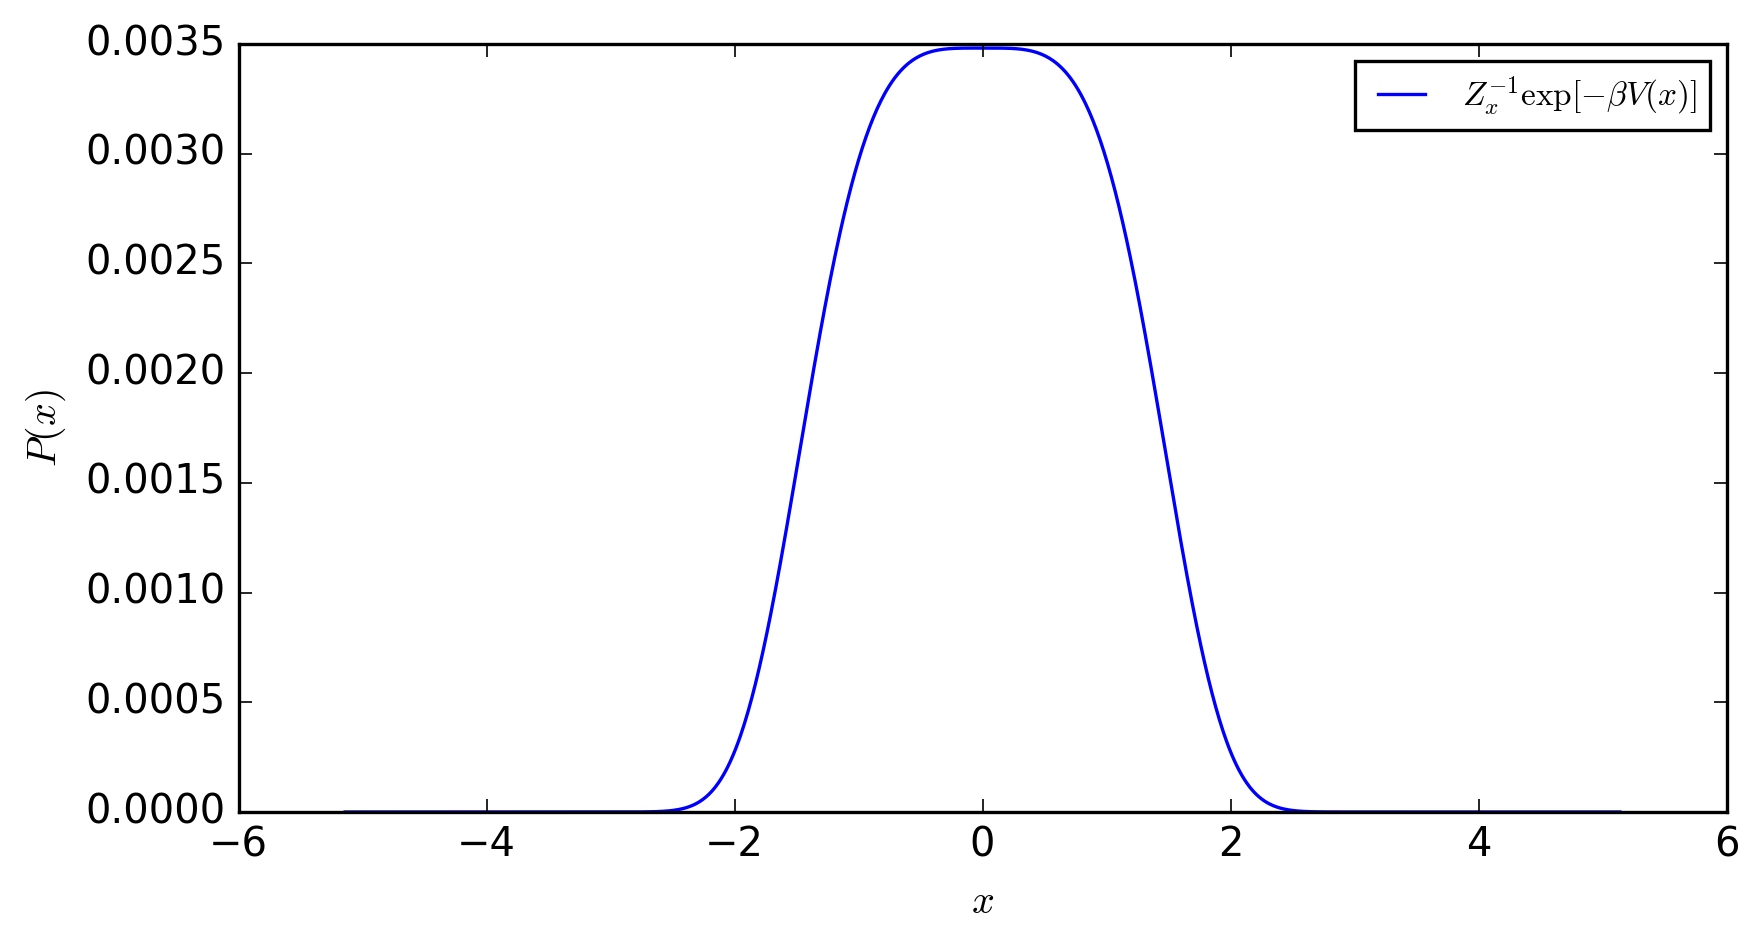

In [387]:
## Create/Plot Gibbs distribution 

def V(x): 
    a=0
    return omega/4 * (x**4 - a*x)

def class_Distr(x, beta): 
    P = np.exp(-beta * (V(x)))
    return P

P_gibbs = class_Distr(x1_range_q, beta_test)
P_gibbs /= np.sum(P_gibbs)

##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
ax1.plot(x1_range_q, P_gibbs, label=r"$Z_x^{-1}\exp[-\beta V(x)]$")
ax1.legend(fontsize=10)

ax1.set_ylabel(r"$P(x)$")
ax1.set_xlabel(r"$x$")

Plots_W/JJ_CM_eps0.5_distr_a0_nMax1.png
Plots_W/JJ_CM_eps0.5_distr_a0_nMax2.png
Plots_W/JJ_CM_eps0.5_distr_a0_nMax3.png
Plots_W/JJ_CM_eps0.5_distr_a0_nMax4.png
Plots_W/JJ_CM_eps0.5_distr_a0_nMax5.png


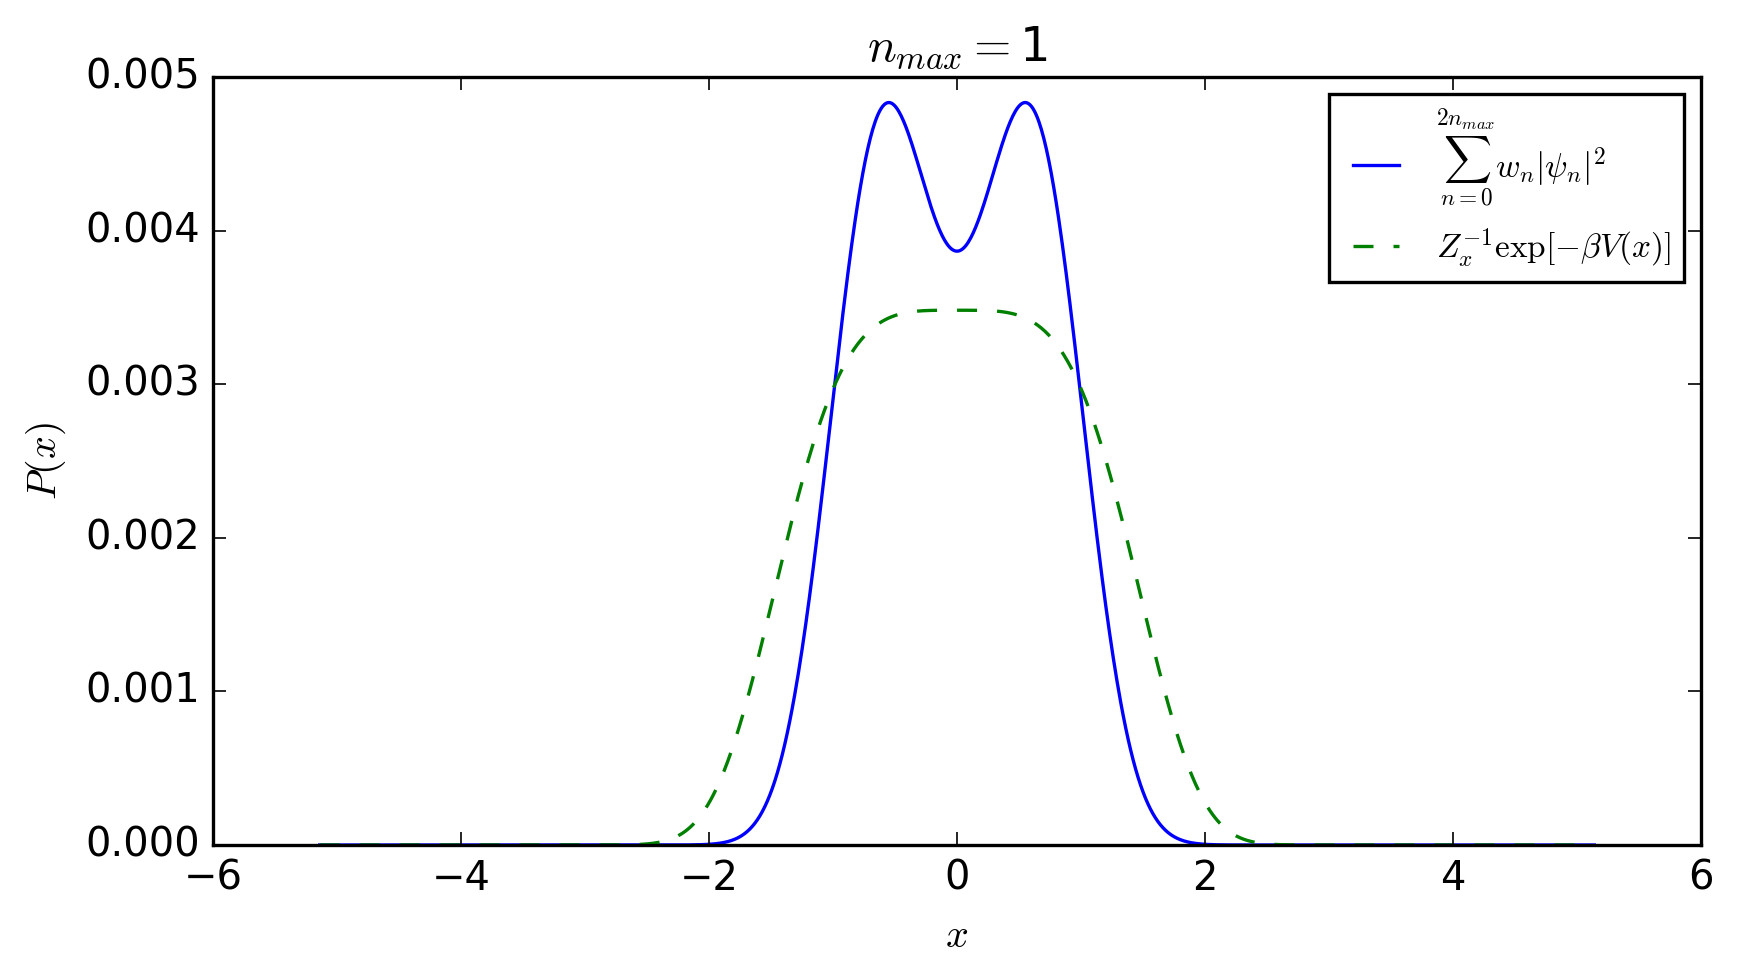

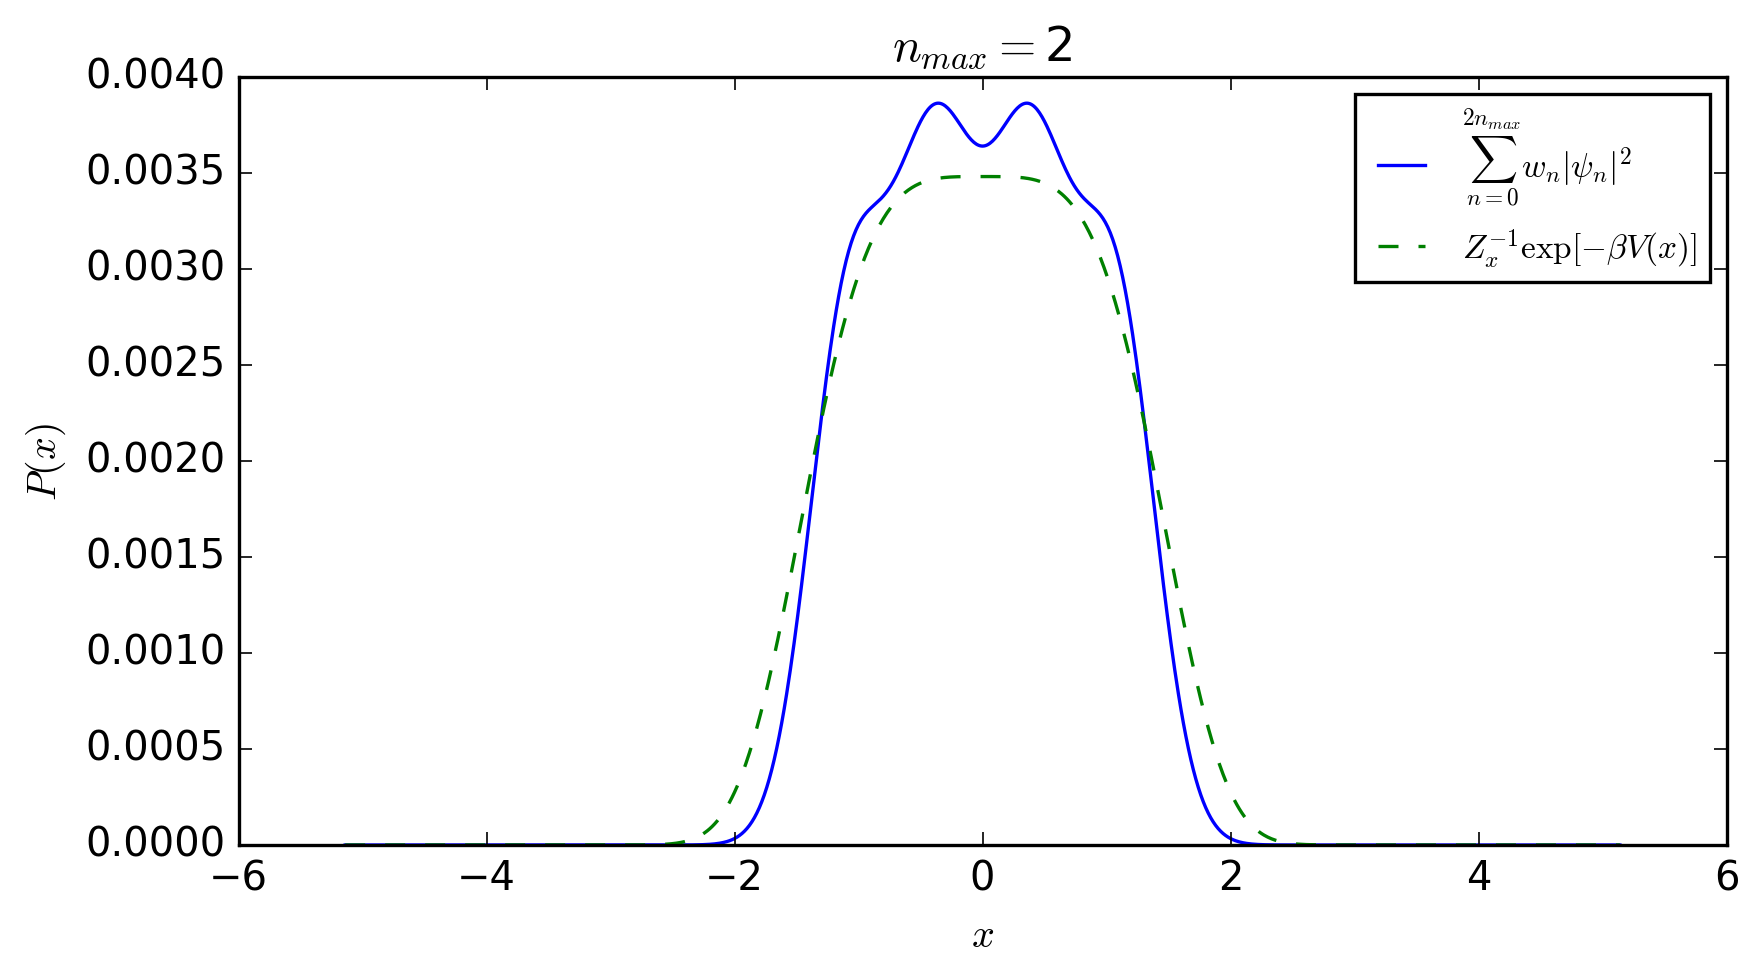

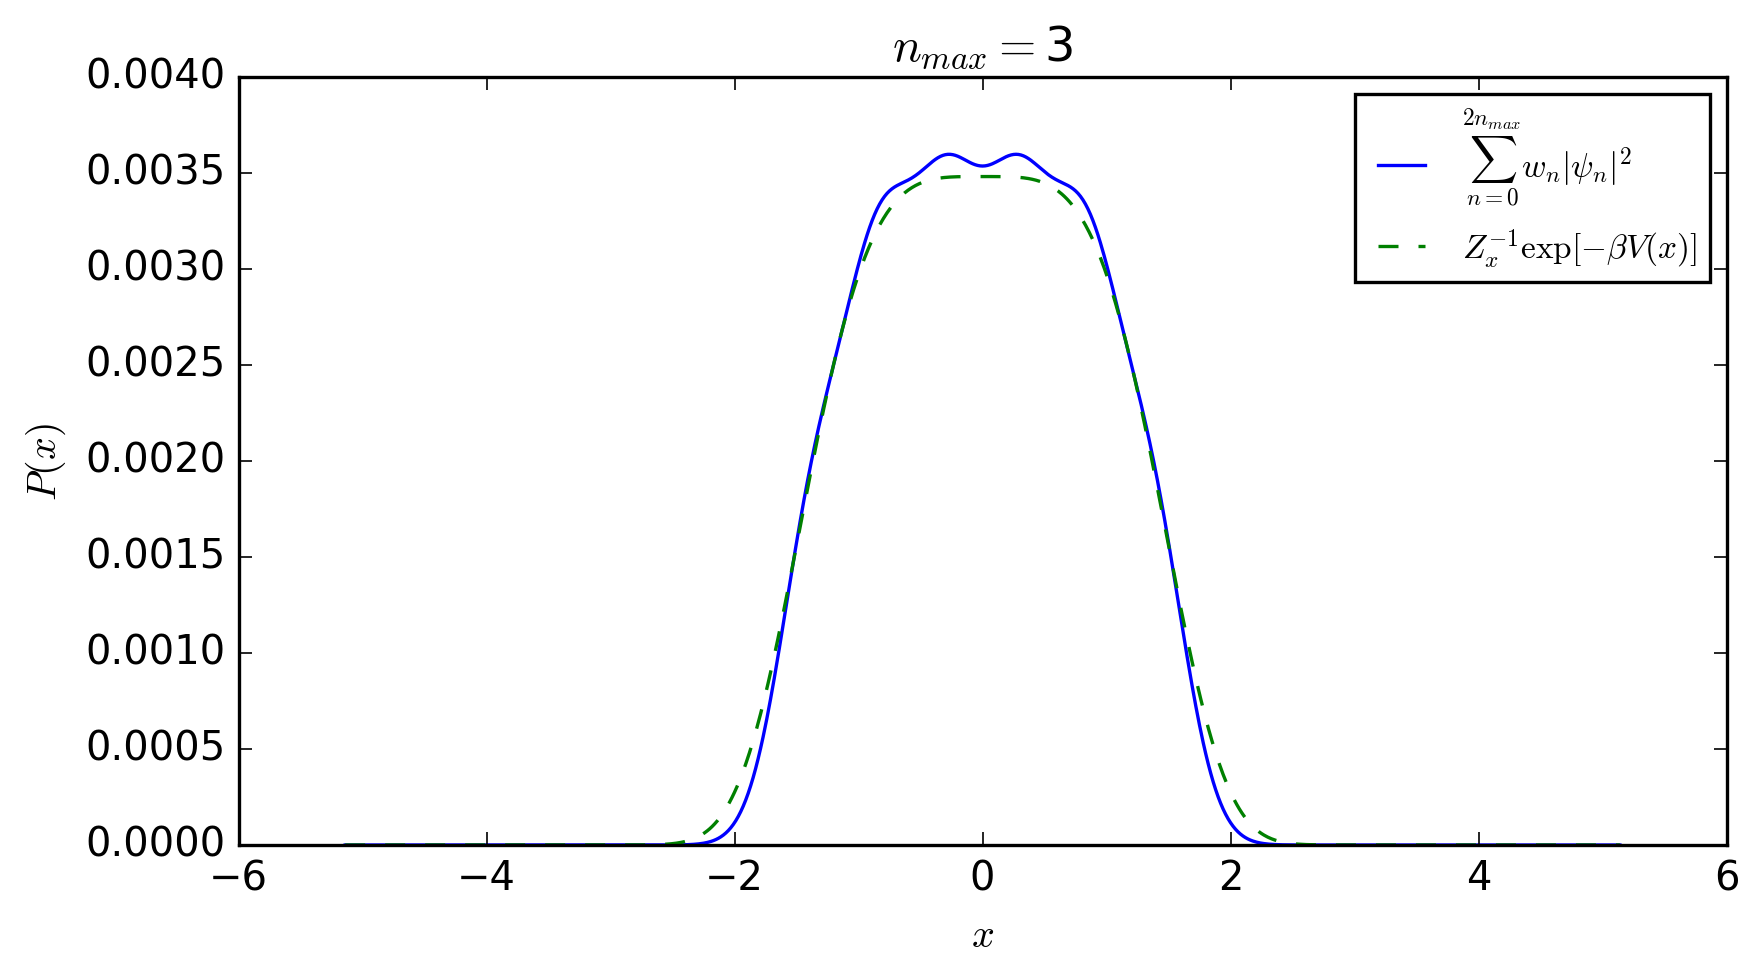

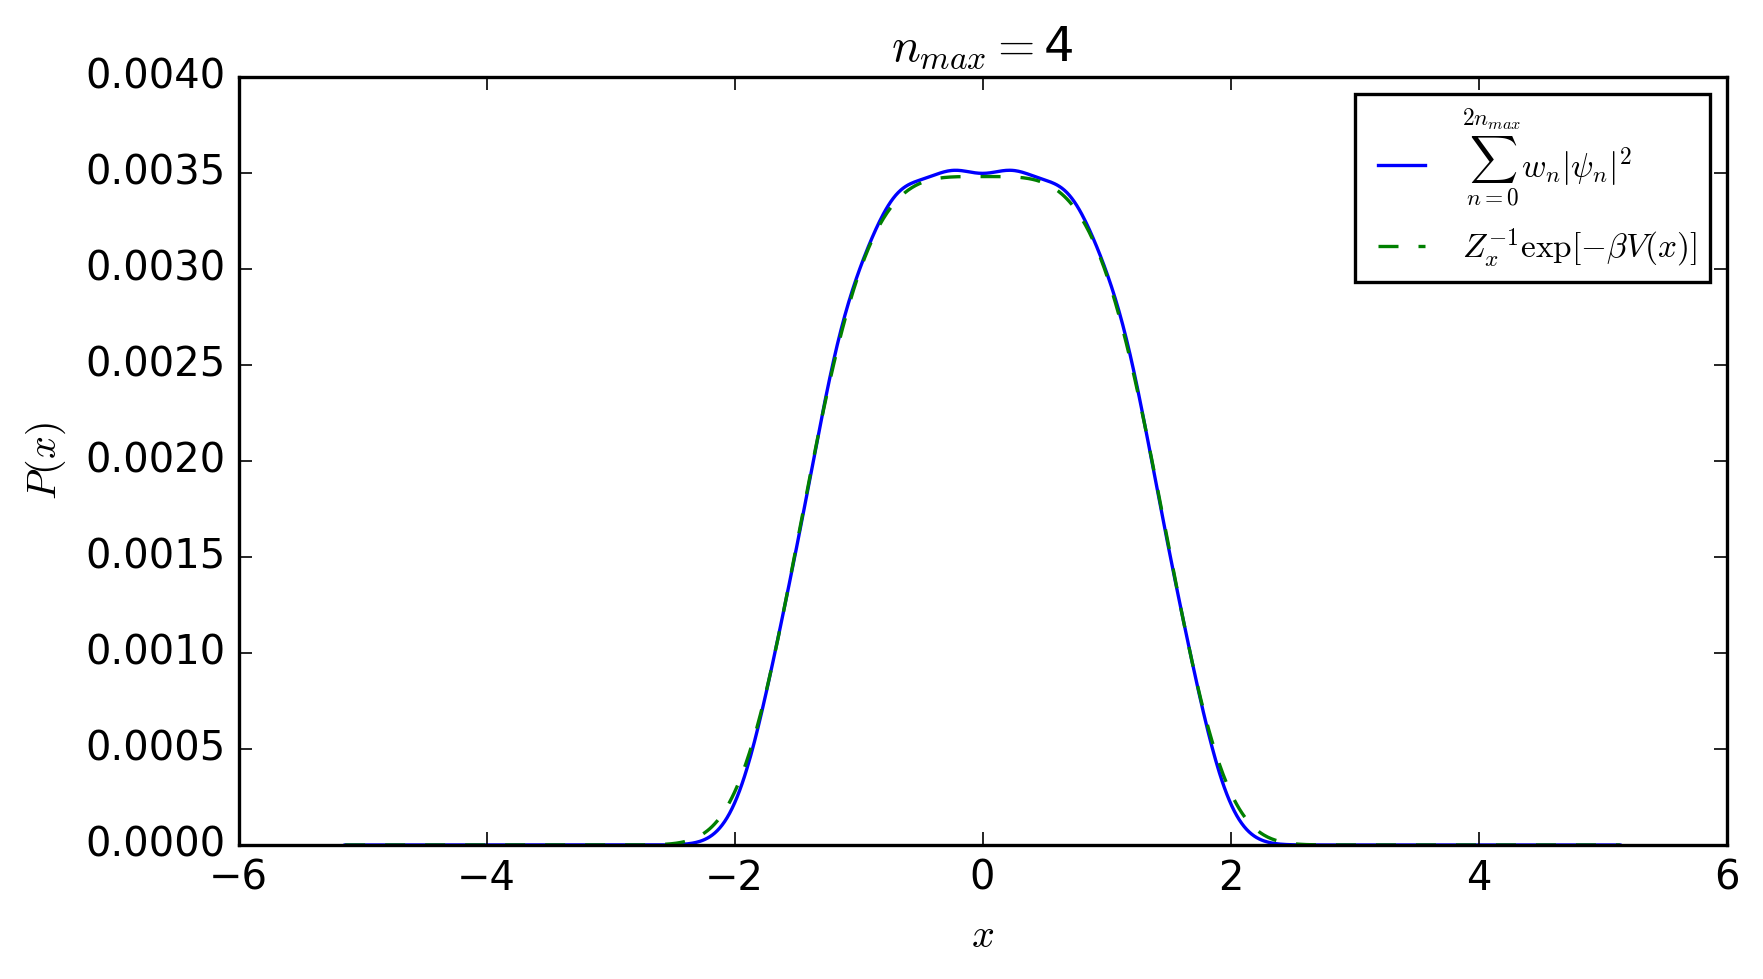

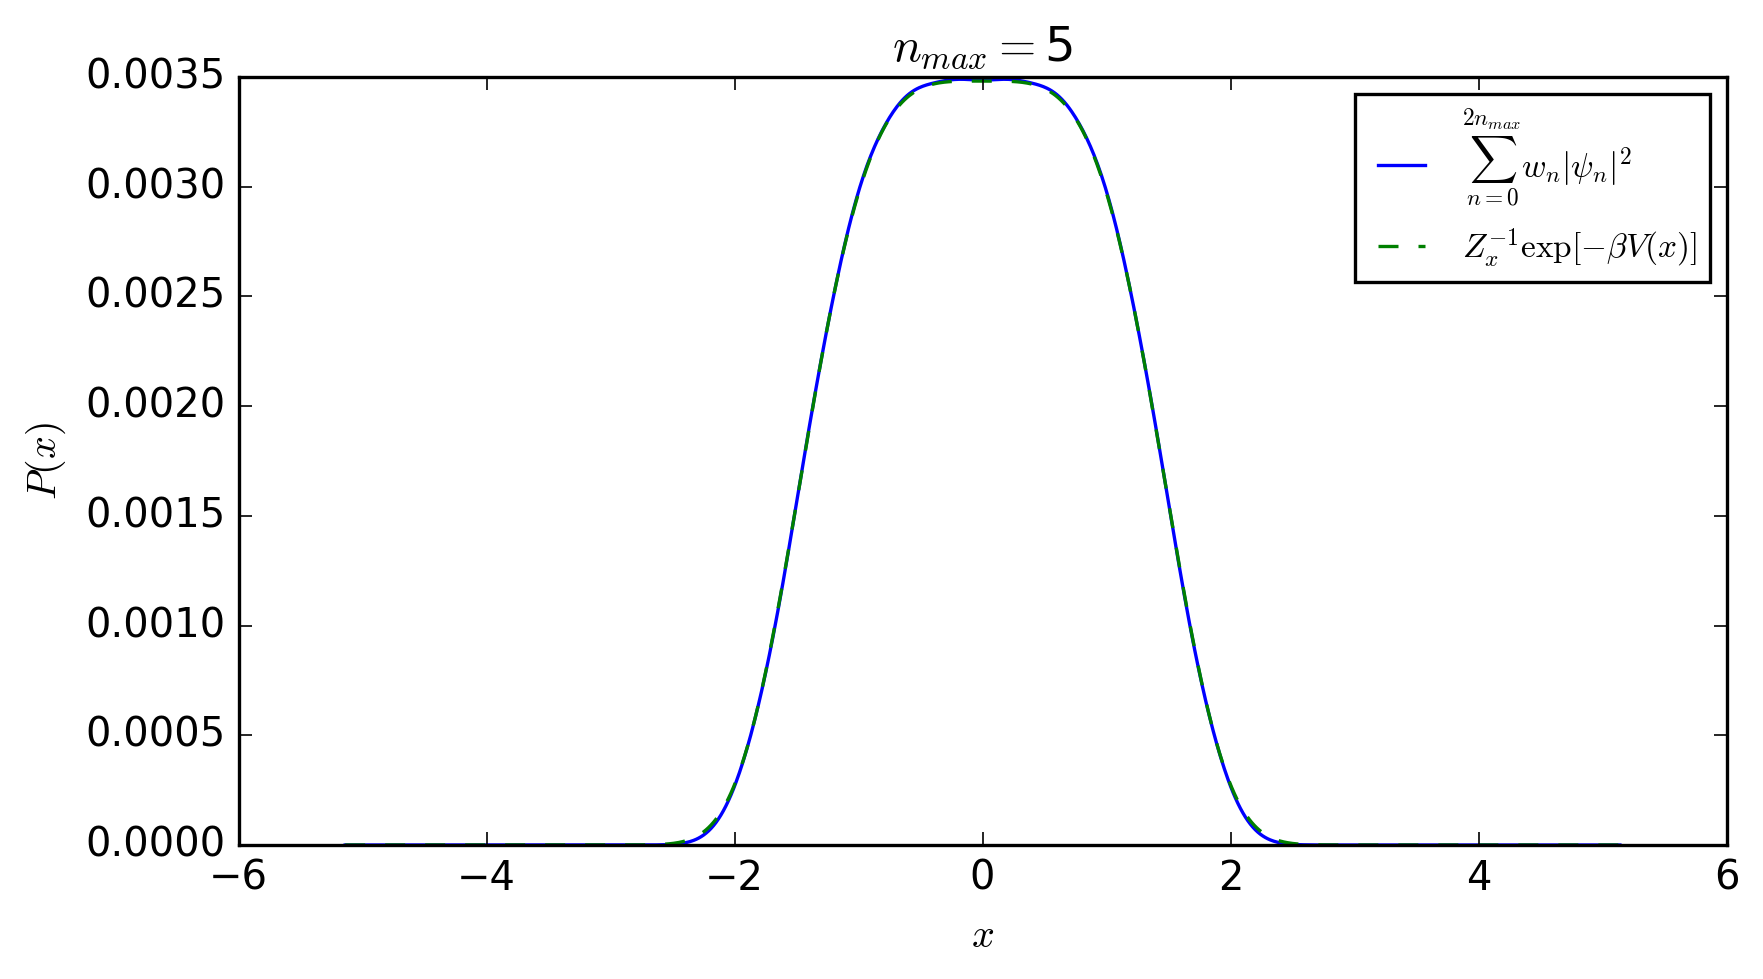

In [389]:
## Compare to sum of first 2n states

for n_max in range(1,6): 
    P_gibbs_re = np.zeros(len(x1_range_q))

    for n in range(n_max): 
        P_gibbs_re += np.real(w_alph[2*n] * np.abs(psi_alph[:,2*n])**2)
        P_gibbs_re += np.real(w_alph[2*n+1] * np.abs(psi_alph[:,2*n+1])**2)
    P_gibbs_re /= np.sum(P_gibbs_re)

    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
    ax1.plot(x1_range_q, P_gibbs_re, label=r"$\sum_{n=0}^{2n_{max}} w_n |\psi_n|^2$")
    ax1.plot(x1_range_q, P_gibbs, '--', label=r"$Z_x^{-1}\exp[-\beta V(x)]$")
    ax1.legend(fontsize=10)
    ax1.set_title(r"$n_{max} = $"+str(n_max))
    ax1.set_ylabel(r"$P(x)$")
    ax1.set_xlabel(r"$x$")
    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_distr_a0_nMax"+str(n_max)+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)

## Compute/Diagonalize, optimizing for $\epsilon$ 

In [20]:
def compStates_e(eps, beta): 
    """
    Compute, plot, and return the weights from diagonalizing 
    the W-function (of the classical Gibbs distributions at inverse-temp beta)
    
    Arguments
        beta : inverse temperature. 
    """
    w_alph_list = []
    psi_alph_list = []

    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01

    #Define extended range of x1
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx))
    x2_range_q = x1_range_q.copy()
    n_x1q = len(x1_range_q); 
    n_x2q = len(x2_range_q);

    #Define range of x
    # Find the x-index where true x-range starts
    x_max = np.pi
    x_min = -np.pi
    x_range_q = np.append(np.flip(-1*np.arange(dx,x_max,dx)), np.arange(0,x_max,dx))
    n_xq = len(x_range_q);
    found_x_beg = np.where(x1_range_q ==x_range_q[0])[0][0]
    found_x_end = -1*(found_x_beg)

    ## Compute the W-function
    W_mat = np.zeros((n_x1q, n_x2q), dtype=complex)
    Z_x = np.sum(np.exp(-beta*V(x_range_q)))
    for x1_i, x1 in enumerate(x1_range_q): 
        for x2_i, x2 in enumerate(x2_range_q):
            x_x = (x1+x2)/2
            xi_x = x1-x2
            W_mat[x1_i, x2_i] = np.exp(-beta*V(x_x))*np.exp(-m*xi_x**2/(2.*eps**2*beta))/Z_x

    ## Diagonalize the W-function
    w_alph, psi_alph = np.linalg.eigh(W_mat)

    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
        
    return sorted_w_alph, sorted_psi_alph

### Computing W for $\epsilon$ range around the crossings

In [25]:
def comp_Write_e(eps, beta):  
    w_alph, psi_alph = compStates_e(eps, beta)

    foldername = "SingleT_quart_beta2_eps"
    foldername = "SingleT_quart_beta5_eps"
    
    ## Write the weights to a text file
    filename = "diagW/"+ foldername +"/JJ_CM_weights_eps" +str(round(eps, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, w_alph, delimiter=',')

    ## Write the states to a text file
    filename = "diagW/"+ foldername +"/JJ_CM_states_eps" +str(round(eps, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, psi_alph[:,20], delimiter=',', header=listToStr, comments='#')

beta = 2
eps_list = np.arange(1,81)/80
for eps_i, eps in enumerate(eps_list): 
    print(eps_i, end=' ')
    comp_Write_e(eps, beta)

0 1 

KeyboardInterrupt: 

### Read-in data from files

In [34]:
## Read from file
def readInNew(filename_base, eps_list): 
    
    foldername = "SingleT_quart_beta2_eps"
#     foldername = "SingleT_quart_beta5_eps"
    
    weights_list = []
    for eps_i, eps in enumerate(eps_list): 
        filename = filename_base + str(round(eps,6)) + ".txt"
        w_alph = np.loadtxt("diagW/"+ foldername +"/"+filename,dtype = "complex", delimiter=',', comments='#')
        weights_list += [w_alph[:600]/np.sum(w_alph[:600])]
    return np.asarray(weights_list)

beta = 2
eps_list = np.arange(1,81)/80
w_alph = readInNew("JJ_CM_weights_eps", eps_list)

print("Found this many weights:", np.shape(w_alph))
print(np.sum(w_alph))

Found this many weights: (80, 600)
(80+0j)


#### Weights at given T

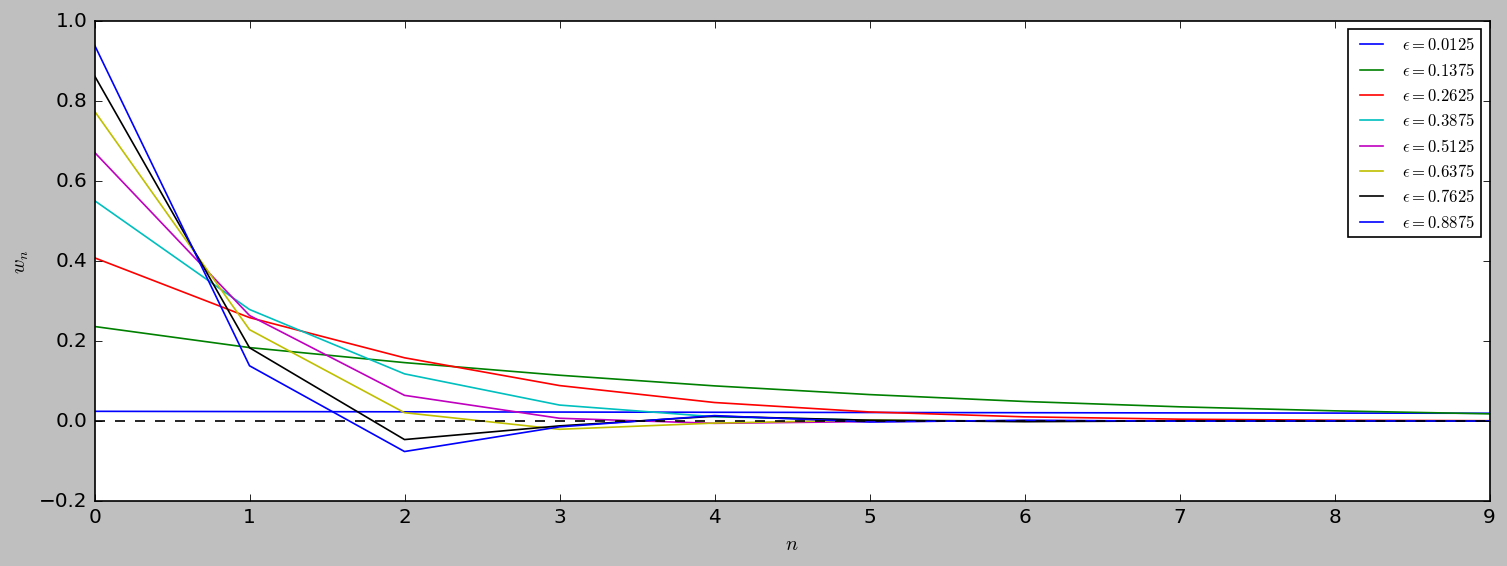

In [35]:
f, ax1 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

for eps_i, eps in enumerate(eps_list):
    if eps_i%10 == 0: 
        ax1.plot(np.arange(0,10), np.real(w_alph[eps_i,:10]), label=r'$\epsilon='+str(eps)+'$')
ax1.plot(np.arange(0,10), 0*np.arange(0,10), 'k--')
ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$w_n$")
ax1.legend(fontsize=10)
filename = "Plots_W/CM_eps"+str(eps)+"_JJ3T_weights.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 

## Comparing $W$ to few-state approx.

Define a "distance": $Tr (W-W_1)^2$, which is nothing but _the sum of the excluded weights_, $\sum_{i=n_max}^N |w_i|^2$. How does that distance change as we increase $n_{max}$? 

Plots_W/CM_beta2_quart_GibbsCompare.png


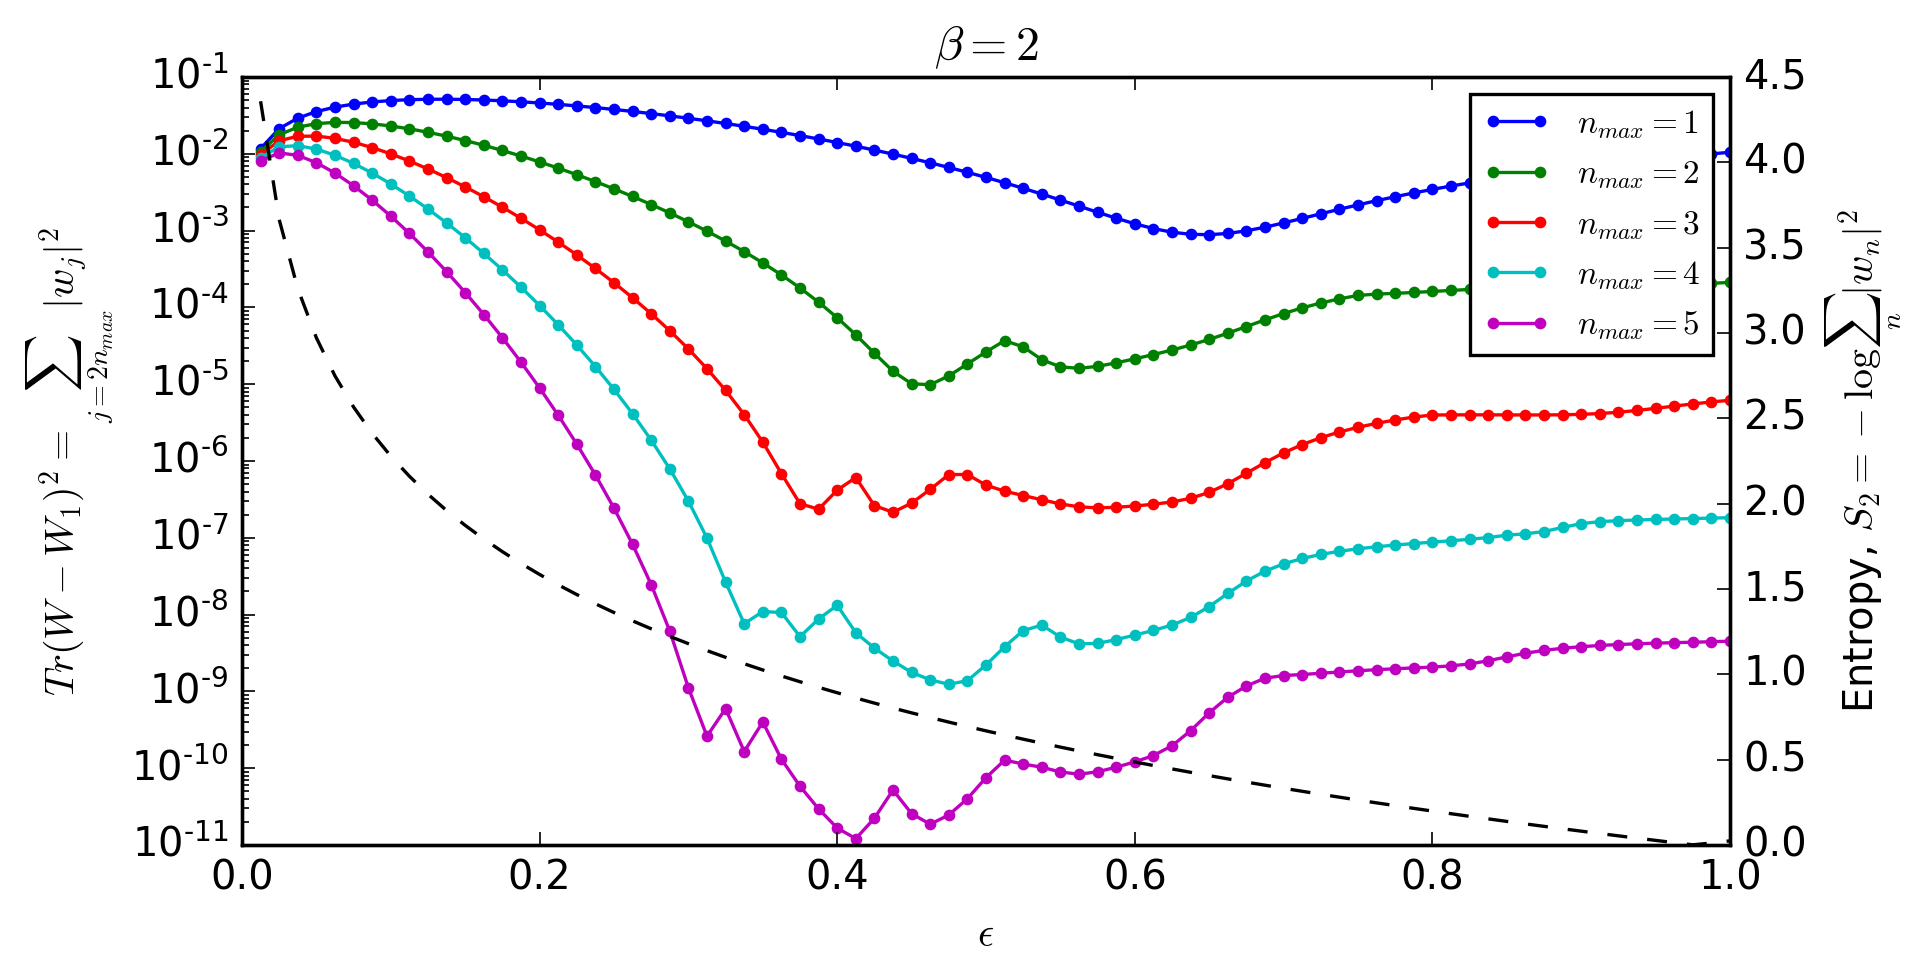

In [38]:
n_max_Range = np.arange(1, 6)

distances = np.zeros((len(n_max_Range),len(eps_list)))
entropy = np.zeros_like(eps_list, complex)

for n_max_i, n_max in enumerate(n_max_Range): 
    for j_i, j in enumerate(eps_list): 
        w_alph_i = w_alph[j_i,:]
        distances[n_max_i, j_i] = np.sum(np.abs(w_alph_i[2*n_max:])**2)

for j_i, j in enumerate(eps_list):   
    w_alph_i = w_alph[j_i,:]
    entropy[j_i] = -1*np.log(np.abs(np.sum( np.power(w_alph_i, 2) )))
    
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
for n_max_i, n_max in enumerate(n_max_Range): 
    ax1.plot(eps_list, distances[n_max_i,:], ".-",label=r"$n_{max} = "+str(n_max_Range[n_max_i])+"$")
ax1.legend(fontsize=10)
ax1.set_ylabel(r"$Tr (W-W_1)^2 = \sum_{j=2n_{max}} |w_j|^2$")
ax1.set_xlabel(r"$\epsilon$")
ax1.set_yscale('log')
ax1.set_title(r"$\beta = "+ str(beta) +"$")
ax2 = ax1.twinx()
ax2.plot(eps_list, np.abs(entropy), 'k--')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_beta"+str(beta)+"_quart" + "_GibbsCompare.png"
print(filename)
# f.savefig(filename, dpi=200, bbox_inches='tight') 


## Testing

In [ ]:
beta = beta_list_fine[-1]

sigma_x = beta*eps**2 / m
dx = 0.01
#Define extended range of x1
x1_max = np.pi
x1_min = -np.pi
x1_range_q = np.append(np.flip(-1*np.arange(0,x1_max+dx+sigma_x,dx)), np.arange(0,x1_max+dx+sigma_x,dx))
n_x1q = len(x1_range_q); 

print(sigma_x, beta, eps)
print(x1_range_q)

In [4]:
def createScript(jobName, filename, beta):
#     print("qsub" ,filename)
    file = open(filename,"w+")

    file.write("#!/bin/bash -l \n \n" )

    file.write("# Set SCC Project \n")
    file.write("#$ -P bunuc \n")

    file.write("# Specify hard time limit for the job. \n")
    file.write("#   The job will be aborted if it runs longer than this time. \n")
    file.write("#$ -l h_rt=12:00:00 \n \n")

    file.write("# Send an email when the job finishes or if it is aborted (by default no email is sent). \n")
    file.write("#$ -m a \n \n")

    file.write("# Reuest a node with at least 4 GB of memory per core \n")
    file.write("#$ -l mem_per_core=8G \n \n")

    file.write("# Request a paralell environemtn with _ cores \n")
    file.write("#$ -pe omp 1 \n \n")
    
    # ----- Assign Job Name -----
    file.write("# Give job a name \n")
    file.writelines(["#$ -N ", str(jobName), "\n \n"])

    file.write("# Combine output and error files into a single file \n")
    file.write("#$ -j y \n \n")

    file.write("# Specify the output file name \n")
    file.write("#$ -o cm_W_output.txt \n \n")

    file.write("# Keep track of information related to the current job \n \n")

    file.writelines(["module load python3", "\n \n"])
    file.writelines(["python3 CM_Solver_Wdiag_single.py ", str(beta), "\n \n"])

    file.close()

    
# beta_list_nearMore = np.linspace(0.01, 5.0, 50) / levelSpace
beta_list_nearMore = np.linspace(1.85, 2.05, 100) / levelSpace

for i in range(len(beta_list_nearMore)):
    jobname = 'cm_W' + str(beta_list_nearMore[i])
    filename = 'diagW/scripts_wide/cm_W_submit' + str(round(beta_list_nearMore[i], 6))+'.sh'
#     createScript(jobname, filename, beta_list_nearMore[i])
    
    print('qsub cm_W_submit' + str(round(beta_list_nearMore[i], 6))+'.sh')
    

qsub cm_W_submit3.966705.sh
qsub cm_W_submit3.971037.sh
qsub cm_W_submit3.975368.sh
qsub cm_W_submit3.9797.sh
qsub cm_W_submit3.984032.sh
qsub cm_W_submit3.988363.sh
qsub cm_W_submit3.992695.sh
qsub cm_W_submit3.997027.sh
qsub cm_W_submit4.001358.sh
qsub cm_W_submit4.00569.sh
qsub cm_W_submit4.010021.sh
qsub cm_W_submit4.014353.sh
qsub cm_W_submit4.018685.sh
qsub cm_W_submit4.023016.sh
qsub cm_W_submit4.027348.sh
qsub cm_W_submit4.03168.sh
qsub cm_W_submit4.036011.sh
qsub cm_W_submit4.040343.sh
qsub cm_W_submit4.044675.sh
qsub cm_W_submit4.049006.sh
qsub cm_W_submit4.053338.sh
qsub cm_W_submit4.05767.sh
qsub cm_W_submit4.062001.sh
qsub cm_W_submit4.066333.sh
qsub cm_W_submit4.070665.sh
qsub cm_W_submit4.074996.sh
qsub cm_W_submit4.079328.sh
qsub cm_W_submit4.083659.sh
qsub cm_W_submit4.087991.sh
qsub cm_W_submit4.092323.sh
qsub cm_W_submit4.096654.sh
qsub cm_W_submit4.100986.sh
qsub cm_W_submit4.105318.sh
qsub cm_W_submit4.109649.sh
qsub cm_W_submit4.113981.sh
qsub cm_W_submit4.118313.